# Final project. Оценка кредитоспособности клиентов финансовой организации

## <a id="content"></a> Содержание

* [Введение](#intro)
* [Основная таблица заявок *application*](#main_table)
    * [Разведывательный анализ данных](#eda)
        * [Признаки c параметрами кредита *feat_loan*](#feat_loan)
        * [Признаки, характеризующие доход и место работы *feat_income*](#feat_income)
        * [Признаки, характеризующие платежеспособность *feat_solvency*](#feat_solvency)
        * [Признаки, отслеживающие обращения в КБ *feat_enquiries*](#feat_enquiries)
        * [Признаки, описывающие владение активами *feat_assets*](#feat_assets)
        * [Признаки рэнкинга региона проживания *feat_geosocial*](#feat_geosocial)
        * [Признаки, описывающие клиента *feat_personal*](#feat_personal)
        * [Признаки важных событий *feat_events*](#feat_events)
        * [Признаки, отслеживающие перемещения клиентов *feat_relocation*](#feat_relocation)
        * [Признаки подачи сопутствующих документов *feat_docs*](#feat_docs)
        * [Признаки с параметрами жилья клиентов *feat_housing*](#feat_housing)
        * [Признаки с данными о способах связи *feat_contacts*](#feat_contacts)
    * [Отбор и преобразование признаков](#features_1)
    * [Базовая модель](#default_model)
* [Вспомогательные таблицы с кредитной историей](#joined_tables)
    * [Описательный анализ и отбор признаков в таблице *bureau*](#tbl_bureau)
    * [Описательный анализ и отбор признаков в таблице *bureau_balance*](#tbl_bureau_balance)
    * [Описательный анализ и отбор признаков в таблице *previous_application*](#tbl_previous_application)
    * [Описательный анализ и отбор признаков в таблице *installments_payments*](#tbl_installments_payments)
    * [Описательный анализ и отбор признаков в таблице *pos_cash_balance*](#tbl_pos_cash_balance)
    * [Описательный анализ и отбор признаков в таблице *credit_card_balance*](#tbl_credit_card_balance)
    * [Преобразование новых признаков](#features_2)
* [Построение прогнозной модели](#main_model)
    * [Подготовка данных для модели](#data_prep)
    * [Оптимизация модели и гиперпараметров](#model_hp)
    * [Прогноз для тестовой выборки](#model_predict)
    * [Сохранение модели](#model_save)
    * [Оценка прогноза для соревнования Kaggle](#model_results)
* [Результаты и выводы](#conclusions)

## <a id="intro"></a> Введение

В качестве финального проекта по программе профессиональной переподготовки по специальности "Курс по Data Science" разработана модель предсказания кредитоспособности клиентов финансовой организации на основании исходных данных, использованных в соревновании на платформе *Kaggle* [Home Credit Default Risk](https://www.kaggle.com/competitions/home-credit-default-risk).

Модель машинного обучения предсказывает вероятность того, что клиент финансовой организации допустит просрочку свыше *Х* дней по первым из *Y* кредитных платежей, на основании сведений, содержащихся в семи связанных таблицах. Доступная информация включает в себя основную таблицу с текущими заявками на заключение кредитных договоров и вспомогательные таблицы с данными о ранее оформленных заявках клиентов, кредитной истории за последние несколько лет, произведенных транзакциях в рамках платежных календарей по кредитам и поведенческих привычках клиентов.

Общая структура данных представлена на диаграмме:

![ER diagram](./er_diagram.png)

При разработке модели классификации клиентов помимо базовых модулей для манипулирования и анализа данных, а также решения задач машинного обучения, использовались следующие инструменты:
* [Duckdb](https://duckdb.org/) &mdash; бессерверная OLAP база данных для создания признаков посредством агрегации данных в смежных таблицах;
* [Feature-engine](https://feature-engine.trainindata.com/) &mdash; совместимая с *sklearn* API библиотека для создания, трансформации и отбора признаков;
* [XGBoost](https://xgboost.readthedocs.io/) &mdash; библиотека с реализацией алгоритма градиентного бустинга для линейных моделей и деревьев решений;
* [Optuna](https://optuna.org/) &mdash; фреймфорк для оптимизации гиперпараметров;
* [Joblib](https://joblib.readthedocs.io/) &mdash; сериализация пайплайна готовой модели для последующего инференса в будущем.

Реализация проекта выполнена в следующей последовательности:
1. Создание локальной базы данных, поддерживающей *SQL* запросы, из группы отдельных исходных *csv* файлов;
2. Разведывательный анализ данных основной таблицы *application* с последующим созданием шагов пайплайна для обработки (выбросы, пропущенные значения) и преобразования (кодирование категориальных переменных) признаков;
3. Предварительный анализ данных во вспомогательных таблицах и формирование перечня потенциальных вновь созданных признаков;
4. Формирование итогового *SQL* запроса для выгрузки итогового набора исходных данных, используемых в обучении модели;
5. Финальный отбор признаков с применением кросс-валидации промежуточных моделей с использованием метрики *AUC ROC* (площадь под ROC-кривой);
6. Построение пространства гиперпараметров модели и поиск их оптимальной комбинации для обучения финальной модели машинного обучения;
7. Сохранение обученной модели для последующей использования при прогнозировании в формате сериализованного *joblib* файла;
8. Предсказание ответов для тестовой выборки и подготовка файла прогнозов для *Kaggle* соревнования.

Финальная модель позволяет достичь значение около 0.78 метрики *AUC ROC* при кросс-валидации и значение 0.7732 в рейтинговой таблице соревнования.

In [1]:
import numpy as np
from scipy import stats
import pandas as pd
rng = np.random.default_rng(seed=12345)
np.set_printoptions(suppress=True, precision=4)
pd.options.display.float_format = '{:,.4f}'.format
pd.options.mode.copy_on_write = True
pd.options.future.infer_string = False
pd.options.future.no_silent_downcasting = True

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

from feature_engine.selection import DropFeatures
from feature_engine.outliers import ArbitraryOutlierCapper
from feature_engine.imputation import (
        MeanMedianImputer,
        CategoricalImputer,
        AddMissingIndicator,
        ArbitraryNumberImputer
)
from feature_engine.encoding import (
        MeanEncoder,
        OrdinalEncoder,
        RareLabelEncoder
)

from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, RocCurveDisplay

import duckdb
import xgboost as xgb
from xgboost import XGBClassifier
import optuna

import os
import gc
import json
import joblib
import utils

c:\Users\kdorofeev\AppData\Local\miniconda3\envs\skillf\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def post_query_process(df):
    col_list = df.columns

    df = df.replace({-99999:np.NaN})

    if 'HOUR_APPR_PROCESS_START' in col_list:
        df['HOUR_APPR_PROCESS_START'] = df['HOUR_APPR_PROCESS_START'].astype('object')

    if 'FLAG_OWN_CAR' in col_list:
        df['FLAG_OWN_CAR'] = df['FLAG_OWN_CAR'].astype('object').replace({'Y':1, 'N':0}).astype('int')

    if 'FLAG_OWN_REALTY' in col_list:
        df['FLAG_OWN_REALTY'] = df['FLAG_OWN_REALTY'].astype('object').replace({'Y':1, 'N':0}).astype('int')

    if 'DAYS_BIRTH' in col_list:
        df['DAYS_BIRTH'] = -np.round(df['DAYS_BIRTH']//182.5)
    
    if 'CODE_GENDER' in col_list:
        df['CODE_GENDER'] = df['CODE_GENDER'].replace({'XNA':np.NaN})

    if 'NAME_EDUCATION_TYPE' in col_list:
        df['NAME_EDUCATION_TYPE'] = df['NAME_EDUCATION_TYPE'].replace({'Academic degree':'Higher education'})

    if 'DAYS_EMPLOYED' in col_list:
        df['DAYS_EMPLOYED'] = df['DAYS_EMPLOYED'].replace({365243:np.NaN})

    if 'DAYS_EMPLOYED' in col_list:
        df['DAYS_EMPLOYED'] = -np.round(df['DAYS_EMPLOYED']/182.5)   

    if 'DAYS_ID_PUBLISH' in col_list:
        df['DAYS_ID_PUBLISH'] = -np.round(df['DAYS_ID_PUBLISH']/182.5)   
    
    if 'DAYS_LAST_PHONE_CHANGE' in col_list:
        df['DAYS_LAST_PHONE_CHANGE'] = -np.round(df['DAYS_LAST_PHONE_CHANGE']/182.5)      

    if 'DAYS_REGISTRATION' in col_list:
        df['DAYS_REGISTRATION'] = -np.round(df['DAYS_REGISTRATION']/182.5)    

    if 'AMT_ANNUITY' in col_list and 'AMT_CREDIT' in col_list:
        df['AMT_ANN_CR_RATIO'] = df['AMT_ANNUITY'] / df['AMT_CREDIT'] * 100

    if 'AMT_CREDIT' in col_list and 'AMT_INCOME_TOTAL' in col_list:
        df['AMT_CR_INC_RATIO'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL'] * 100

    if 'AMT_ANNUITY' in col_list and 'PA_ACT_LOANS_ANN_SUM' in col_list and 'AMT_INCOME_TOTAL' in col_list:
        df['AMT_ANN_INC_RATIO'] = (df['AMT_ANNUITY'] + df['PA_ACT_LOANS_ANN_SUM']) / df['AMT_INCOME_TOTAL'] * 100  

    if 'OCCUPATION_TYPE' in col_list:
        def low_skill_personnel(row):
            if row['OCCUPATION_TYPE'] in ['Low-skill Laborers', 'Waiters/barmen staff']:
                return 1
            else:
                return 0
        df['OCCUPATION_LOW_SKILL'] = df.apply(low_skill_personnel, axis='columns')
        
    return df

In [3]:
# File and database table names
df_names = [fn[0:-4].lower() for fn in os.listdir('./data/') if fn.endswith('csv')]
file_names = [os.path.join(os.getcwd(), 'data', fn) for fn in os.listdir('./data/') if fn.endswith('csv') and not fn.startswith('columns')]

# # Clean column description file
# df_tmp = pd.read_csv(os.path.abspath('./data/HomeCredit_columns_description.csv'), usecols=[1,2,3,4], encoding='cp1250', encoding_errors='replace', dtype_backend='numpy_nullable')
# df_tmp['Desc'] = df_tmp.apply(utils.col_desc, axis='columns')
# df_tmp = df_tmp.drop(columns=['Description', 'Special'])
# df_tmp.to_csv(os.path.abspath('./data/columns_description_clean.csv'), index=False)

# Create and fill DB
conx = duckdb.connect(database=os.path.abspath('./data/home_credit.duckdb'))

# for i, fn in enumerate(file_names):
#     conx.execute(f"CREATE TABLE {df_names[i]} AS SELECT * FROM read_csv_auto('{fn}', header=true)")

df = conx.execute("select * from application_train").fetch_df()
df = post_query_process(df)

## <a id="main_table"></a> Основная таблица заявок *application*

### <a id="eda"></a> Разведывательный анализ данных

В основной таблице текущих заявок присутствует 120 признака (за исключением идентификатора заявки), которые для удобства анализа разбиты на 12 тематических групп. Для независимой переменной соотношения классов не сбалансировано - только 8% наблюдений относится к проблемным кредитам.

In [4]:
with open('app_vars.json', 'r') as f:
    app_vars = json.load(f)

for k, v in app_vars.items():
    globals()[k] = v
    print(f'{k:<15}: {v[0:5]}')

feat_loan      : ['AMT_ANNUITY', 'AMT_CREDIT', 'AMT_GOODS_PRICE', 'HOUR_APPR_PROCESS_START', 'NAME_CONTRACT_TYPE']
feat_income    : ['AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE']
feat_solvency  : ['DEF_30_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']
feat_enquiries : ['AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_WEEK']
feat_assets    : ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_HOUSING_TYPE', 'OWN_CAR_AGE']
feat_geosocial : ['REGION_POPULATION_RELATIVE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY']
feat_personal  : ['CNT_CHILDREN', 'CNT_FAM_MEMBERS', 'CODE_GENDER', 'DAYS_BIRTH', 'NAME_EDUCATION_TYPE']
feat_events    : ['DAYS_EMPLOYED', 'DAYS_ID_PUBLISH', 'DAYS_LAST_PHONE_CHANGE', 'DAYS_REGISTRATION']
feat_relocation: ['LIVE_CITY_NOT_WORK_CITY', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 

In [5]:
pd.concat([
    df['TARGET'].value_counts(),
    df['TARGET'].value_counts(normalize=True)*100], 
    axis=1
)

count  proportion
TARGET                    
0       282686     91.9271
1        24825      8.0729

#### <a id="feat_loan"></a> Признаки c параметрами кредита *feat_loan*

Первой группой переменных являются признаки, относящиеся к непосредственным характеристикам кредита в заявке: тип кредита, размер кредита и платежа по нему, а также день недели и время подачи заявки. К сожалению, в таблице отсутствует срок кредита, что не позволяет напрямую рассчитать примерный процент по кредиту и, соответственно, оценку риска клиента для финансовой организации. С учетом того, что для небольшого количества заявок отсутствуют данные по размеру обязательного платежа, пропущенные значения заполняются медианным значением. Данная величина (24 903 д.е.) примерно соответствует среднему размеру платежа для кредитов соответствующего объема (безотносительно срока кредита).

В данных представлены наблюдения по двум типам кредитов - кредит наличными и возобновляемый кредит (в виде кредитной карты) в соотношении 9.5 к 1, которые имеют существенно отличающиеся уровни просрочек по кредитам. Подавляющее большинство кредитов имеют размер в диапазоне от 270 до 809 тыс. денежных единиц (далее - д.е.). При этом, для кредитов, размер которых лежит в диапазоне от медианного значения до правой границы межквартильного размаха, наблюдается повышенный процент проблемных кредитов. Значения переменной *AMT_GOODS_PRICE* (стоимость товаров, для покупки которых оформляется кредит) практически на 100% линейно зависимы от значений в переменной *AMT_CREDIT* (размер кредита).

Временные характеристики, связанные с заявками, имеют ограниченное влияние на процент проблемных кредитов. Для их трансформации используется кодирование с использованием среднего значения целевого признака со сглаживанием (для снижения важности для нечастных категорий).

Дополнительно на основе данных признаков рассчитаны новые:
* **AMT_ANN_CR_RATIO** &mdash; соотношение платежа по кредиту к его размеру;
* **AMT_CR_INC_RATIO** &mdash; соотношение размера кредита к совокупному доходу клиента.

47531      450,000.0000
50035      450,000.0000
51594      539,100.0000
55025      296,280.0000
59934      360,000.0000
75873      219,249.0000
89343      157,500.0000
123872     929,088.0000
207186     486,000.0000
227939     628,069.5000
239329     792,000.0000
241835   1,483,231.5000
Name: AMT_CREDIT, dtype: float64

Mean installment to loan amount: 27109
Median installment to loan amount: 24903


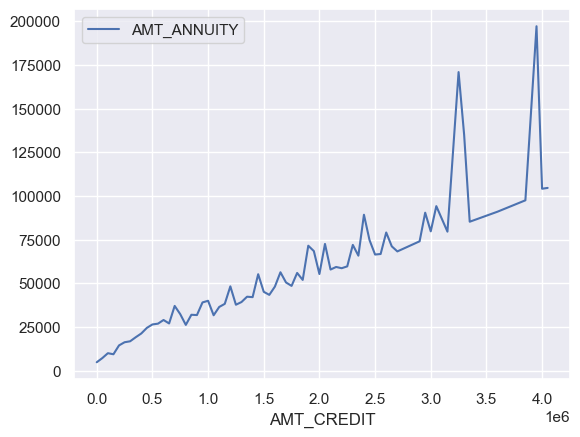

In [6]:
display(df.loc[df['AMT_ANNUITY'].isnull(), 'AMT_CREDIT'])

print(f"Mean installment to loan amount: {df['AMT_ANNUITY'].mean():.0f}")
print(f"Median installment to loan amount: {df['AMT_ANNUITY'].median():.0f}")

pd.concat(
    [df['AMT_ANNUITY'], np.floor(df['AMT_CREDIT']/50000)*50000], axis=1
    ).groupby('AMT_CREDIT').median().plot();

In [7]:
utils.info_ext(df, feat_loan)

dtype     obs  nulls  nulls_pct
AMT_ANNUITY                 float64  307499     12     0.0000
AMT_CREDIT                  float64  307511      0     0.0000
AMT_GOODS_PRICE             float64  307233    278     0.0009
HOUR_APPR_PROCESS_START      object  307511      0     0.0000
NAME_CONTRACT_TYPE           object  307511      0     0.0000
WEEKDAY_APPR_PROCESS_START   object  307511      0     0.0000

In [8]:
utils.top_unique_values(df[feat_loan], topvals=7, dropna=False)

Unique values               Top 1  \
AMT_ANNUITY                        13673       9000.0 (2.1%)   
AMT_CREDIT                          5603     450000.0 (3.2%)   
AMT_GOODS_PRICE                     1003     450000.0 (8.5%)   
HOUR_APPR_PROCESS_START               24          10 (12.3%)   
NAME_CONTRACT_TYPE                     2  Cash loans (90.5%)   
WEEKDAY_APPR_PROCESS_START             7     TUESDAY (17.5%)   

                                             Top 2            Top 3  \
AMT_ANNUITY                         13500.0 (1.8%)    6750.0 (0.7%)   
AMT_CREDIT                         675000.0 (2.9%)  225000.0 (2.7%)   
AMT_GOODS_PRICE                    225000.0 (8.2%)  675000.0 (8.1%)   
HOUR_APPR_PROCESS_START                 11 (12.1%)       12 (11.1%)   
NAME_CONTRACT_TYPE          Revolving loans (9.5%)                –   
WEEKDAY_APPR_PROCESS_START       WEDNESDAY (16.9%)   MONDAY (16.5%)   

                                       Top 4            Top 5  \
AMT_ANNUITY                   10125.0 (0.7%)   37800.0 (0.5%)   
AMT_CREDIT                   180000.0 (2.4%)  270000.0 (2.4%)   
AMT_GOODS_PRICE              900000.0 (5.0%)  270000.0 (3.7%)   
HOUR_APPR_PROCESS_START           13 (10.1%)        14 (9.0%)   
NAME_CONTRACT_TYPE                         –                –   
WEEKDAY_APPR_PROCESS_START  THURSDAY (16.5%)   FRIDAY (16.4%)   

                                       Top 6            Top 7  Other  
AMT_ANNUITY                   11250.0 (0.5%)   26217.0 (0.5%)  93.3%  
AMT_CREDIT                   900000.0 (2.0%)  254700.0 (1.5%)  83.1%  
AMT_GOODS_PRICE              180000.0 (3.3%)  454500.0 (3.0%)  60.2%  
HOUR_APPR_PROCESS_START             9 (8.9%)        15 (8.1%)  28.4%  
NAME_CONTRACT_TYPE                         –                –      –  
WEEKDAY_APPR_PROCESS_START  SATURDAY (11.0%)    SUNDAY (5.3%)      –

In [9]:
utils.iqr_outliers(df[feat_loan])

min           Q1         mean       median  \
AMT_ANNUITY      1,615.5000  16,524.0000  27,108.5739  24,903.0000   
AMT_CREDIT      45,000.0000 270,000.0000 599,025.9997 513,531.0000   
AMT_GOODS_PRICE 40,500.0000 238,500.0000 538,396.2074 450,000.0000   

                          Q3            max          std  Values < 1.5IQR  \
AMT_ANNUITY      34,596.0000   258,025.5000  14,493.7137                0   
AMT_CREDIT      808,650.0000 4,050,000.0000 402,490.1226                0   
AMT_GOODS_PRICE 679,500.0000 4,050,000.0000 369,445.8593                0   

                 Values > 1.5IQR  
AMT_ANNUITY                 7504  
AMT_CREDIT                  6562  
AMT_GOODS_PRICE            14728

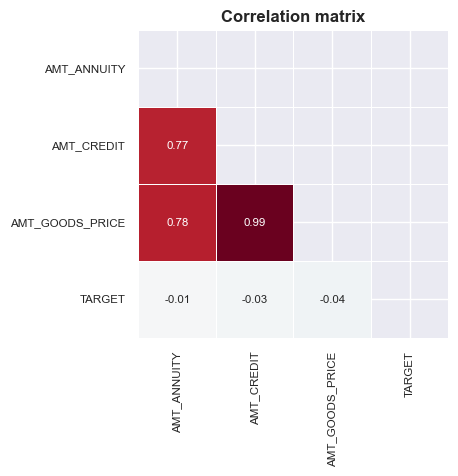

In [10]:
utils.corr_cols(df, feat_loan)

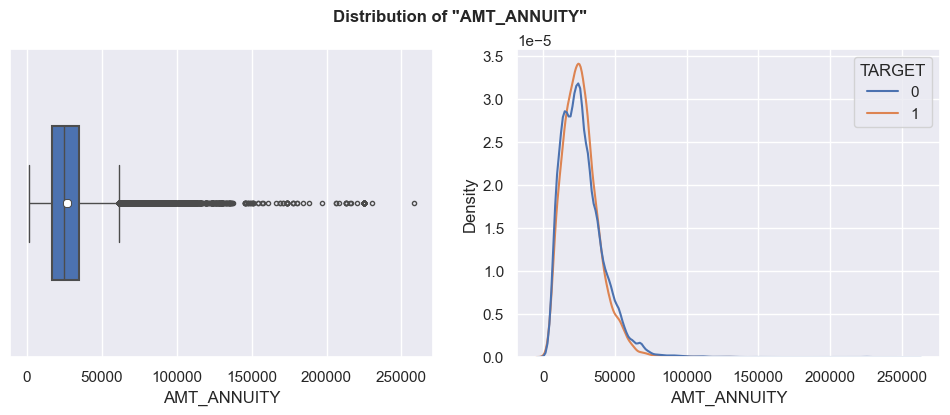

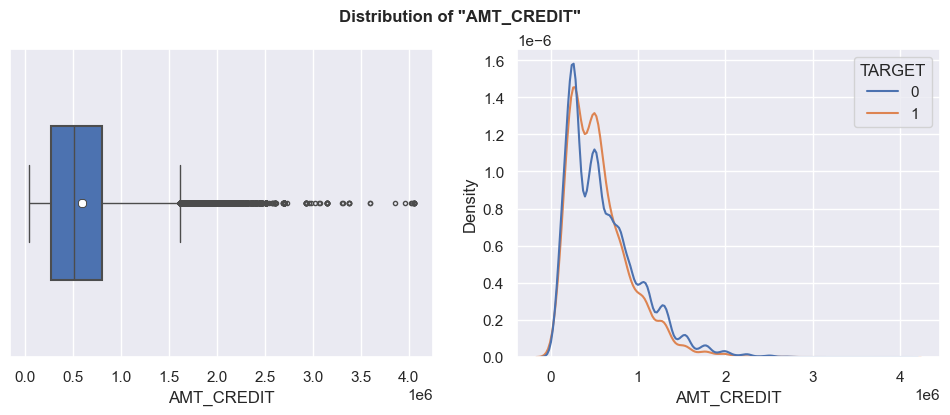

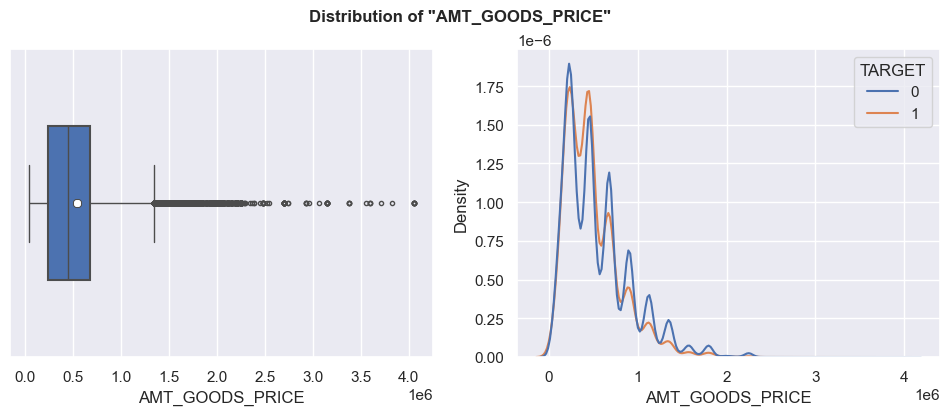

In [11]:
for col in utils.select_vars(df[feat_loan], numeric=True):
    utils.numvar_plot(df, col)

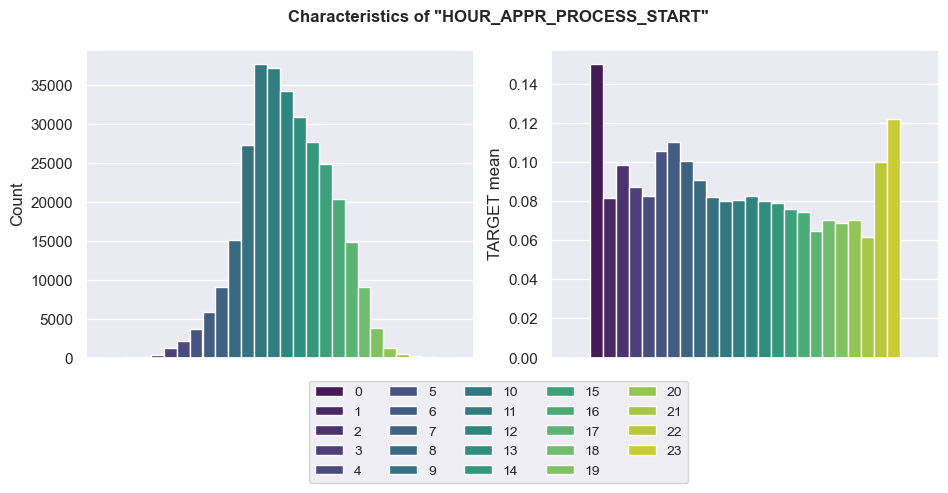

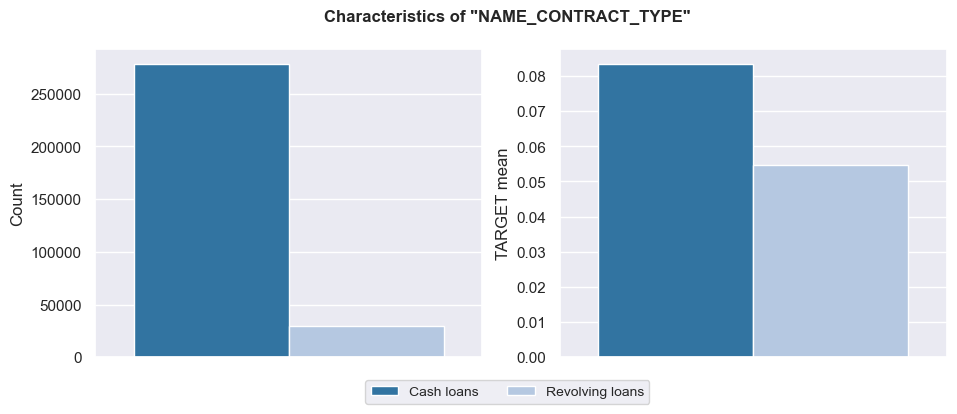

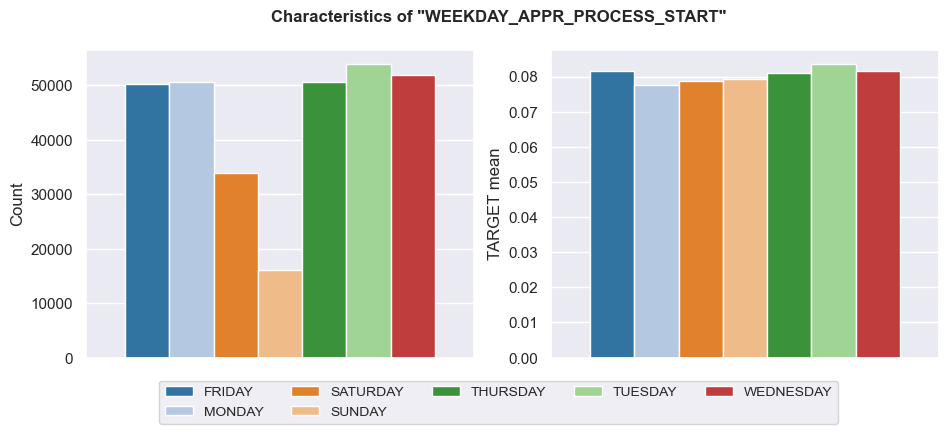

In [12]:
for col in utils.select_vars(df[feat_loan], numeric=False):
    utils.catvar_plot(df, col)

#### <a id="feat_income"></a> Признаки, характеризующие доход и место работы *feat_income*

Второй группой переменных являются признаки, относящиеся к уровню дохода, месту и профессии основной работы. Уровень дохода имеет сильную положительную асимметрию: в данных присутствуют около сотни наблюдений с доходом более 1 млн д.е. при среднем доходе в 169 д.е. (p-value двухстороннего теста Колмогорова-Смирнова равно 0.0000). Несмотря на это, предлагается не обрезать экстремальные значения с использованием стандартных подходов (±1,5х межквартильного размаха/±3 станд. отклонения), так как это приведет к изменению слишком большого количества наблюдений и некорректным значениям новых признаков (например: отношение размера кредита к общему доходу). Вместо этого, в ручном режиме максимальный доход будет ограничен для примерно топ-10 наблюдений.

Переменные *NAME_INCOME_TYPE*, *OCCUPATION_TYPE* и *ORGANIZATION_TYPE* содержат информацию о типе дохода, который является основным для клиента, его профессию и отраслевую классификацию. С учетом большого количества категорий в указанных переменных, для которых присутствует всего наблюдений, данные категории агрегированы в одну категорию *Редкие* и закодированы с использованием среднего значения целевого признака.

Дополнительно на основе данных признаков рассчитаны новые:
* **OCCUPATION_LOW_SKILL** &mdash; признак-индикатор, указывающий, если клиент относиться к категории низкоквалифицированных рабочих (когда *OCCUPATION_TYPE* == 'Low-skill Laborers').

In [13]:
print(f"Two-sided p-value for KS test: {stats.kstest(df['AMT_INCOME_TOTAL'], stats.norm.cdf, alternative='two-sided')[1]:.4f}")

df['AMT_INCOME_TOTAL'].sort_values(ascending=False)[0:10]

Two-sided p-value for KS test: 0.0000


12840    117,000,000.0000
203693    18,000,090.0000
246858    13,500,000.0000
77768      9,000,000.0000
131127     6,750,000.0000
103006     4,500,000.0000
204564     4,500,000.0000
187833     4,500,000.0000
287463     4,500,000.0000
181698     3,950,059.5000
Name: AMT_INCOME_TOTAL, dtype: float64

In [14]:
pd.crosstab(
    index=df['OCCUPATION_LOW_SKILL'], 
    columns=df['TARGET'], 
    normalize='index'
)

TARGET                    0      1
OCCUPATION_LOW_SKILL              
0                    0.9200 0.0800
1                    0.8515 0.1485

In [15]:
utils.info_ext(df, feat_income)

dtype     obs  nulls  nulls_pct
AMT_INCOME_TOTAL   float64  307511      0     0.0000
NAME_INCOME_TYPE    object  307511      0     0.0000
OCCUPATION_TYPE     object  211120  96391     0.3135
ORGANIZATION_TYPE   object  307511      0     0.0000

In [16]:
utils.top_unique_values(df[feat_income], topvals=5, dropna=False)

Unique values                           Top 1  \
AMT_INCOME_TOTAL           2548                135000.0 (11.6%)   
NAME_INCOME_TYPE              8                 Working (51.6%)   
OCCUPATION_TYPE              19                    None (31.3%)   
ORGANIZATION_TYPE            58  Business Entity Type 3 (22.1%)   

                                          Top 2                  Top 3  \
AMT_INCOME_TOTAL               112500.0 (10.1%)        157500.0 (8.6%)   
NAME_INCOME_TYPE   Commercial associate (23.3%)      Pensioner (18.0%)   
OCCUPATION_TYPE                Laborers (17.9%)    Sales staff (10.4%)   
ORGANIZATION_TYPE                   XNA (18.0%)  Self-employed (12.5%)   

                                  Top 4              Top 5  Other  
AMT_INCOME_TOTAL        180000.0 (8.0%)     90000.0 (7.3%)  54.3%  
NAME_INCOME_TYPE   State servant (7.1%)  Unemployed (0.0%)   0.0%  
OCCUPATION_TYPE       Core staff (9.0%)    Managers (6.9%)  24.4%  
ORGANIZATION_TYPE          Other (5.4%)    Medicine (3.6%)  38.3%

In [17]:
utils.iqr_outliers(df[feat_income])

min           Q1         mean       median  \
AMT_INCOME_TOTAL 25,650.0000 112,500.0000 168,797.9193 147,150.0000   

                           Q3              max          std  Values < 1.5IQR  \
AMT_INCOME_TOTAL 202,500.0000 117,000,000.0000 237,122.7607                0   

                  Values > 1.5IQR  
AMT_INCOME_TOTAL            14035

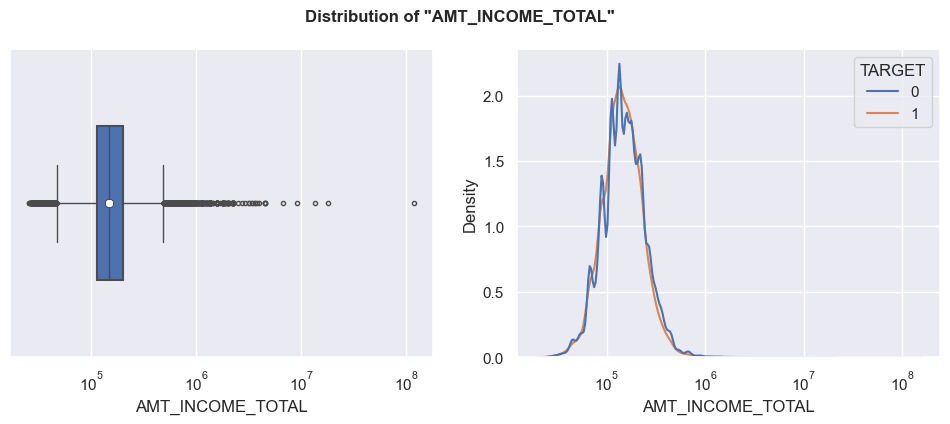

In [18]:
for col in utils.select_vars(df[feat_income], numeric=True, cat_lim=60):
    utils.numvar_plot(df, col, log_scale=True)

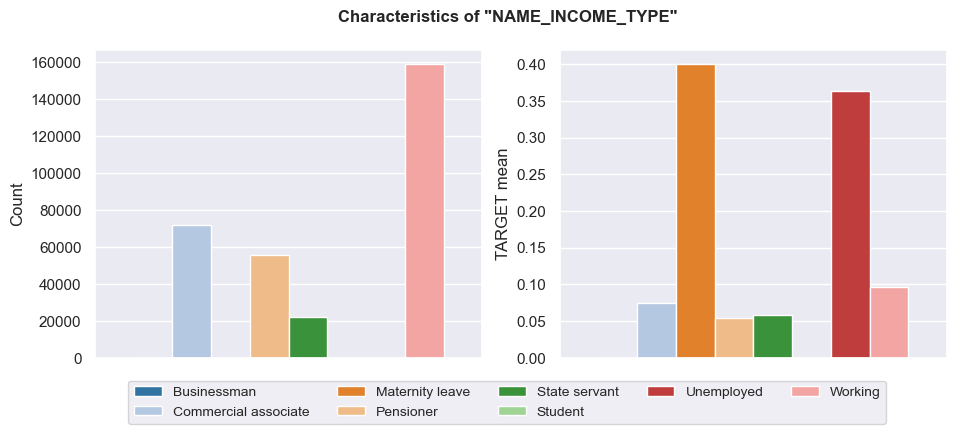

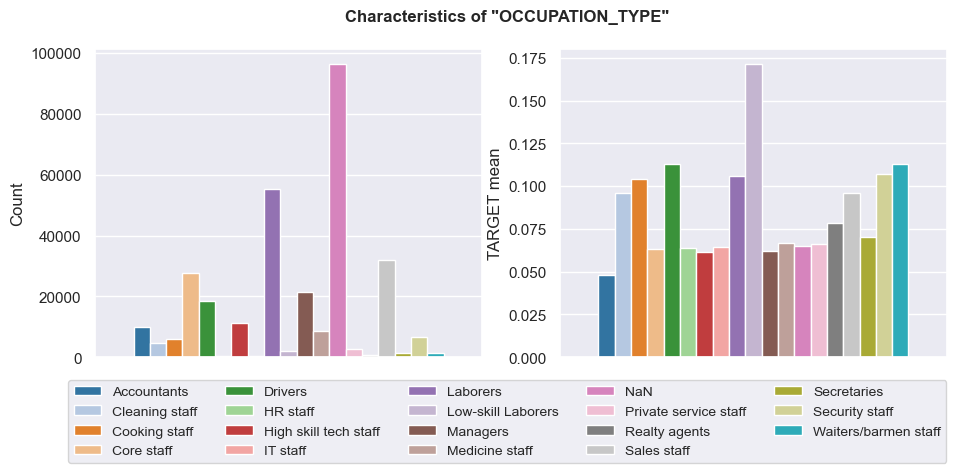

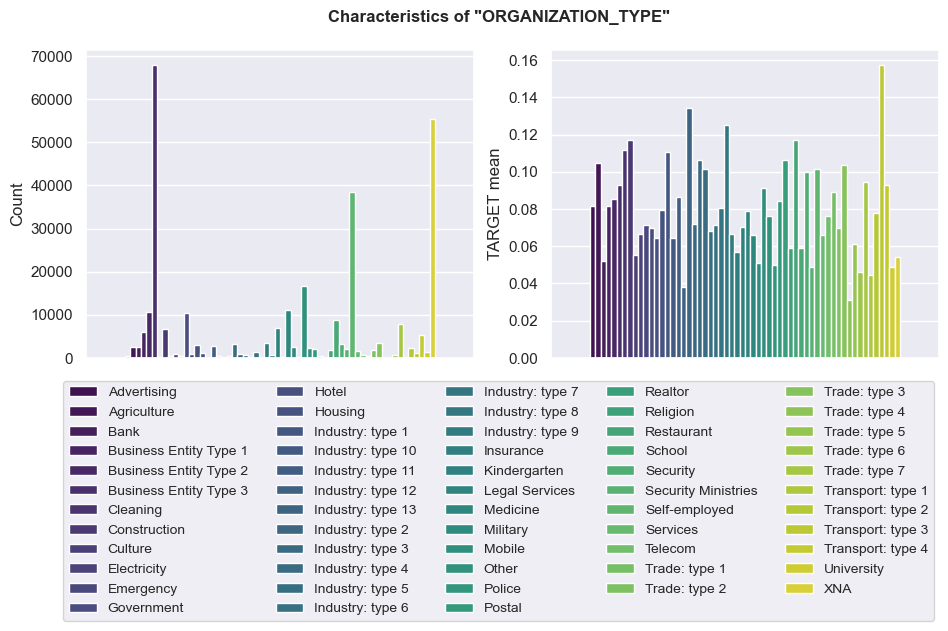

In [19]:
for col in utils.select_vars(df[feat_income], numeric=False, cat_lim=60):
    utils.catvar_plot(df, col)

#### <a id="feat_solvency"></a> Признаки, характеризующие платежеспособность *feat_solvency*

Третьей группой переменных являются признаки, относящиеся к объективной оценке кредитоспособности потенциальных клиентов. В первую очередь это три составных индикатора, принимающих значения от 0 до 1, вероятно, разработанные кредитными бюро (*EXT_SOURCE_n*). Данные признаки имеют довольно высокую корреляцию с целевой переменной и различные распределения в зависимости от значений зависимой переменной и, скорее всего, будут иметь высокую важности в разрабатываемых моделях. Для всех скоринговых оценок присутствуют пропущенные значения, в том числе для первого и третьего, с долями 56% и 20% наблюдений с пустыми значениями. Учет данным признаков в модели будет осуществлен с заполнением пропусков медианными значениями и добавлением признаков-индикаторов для обозначения строк с расчетными показателями.

В остальных признаках перечисляется количество человек в окружении клиента, которые допустили просрочку платежа или дефолт по кредитам (30 и 60 DPD). Так корреляция переменных с фактическими дефолтами с целевой переменной выше и показатель для 30 DPD имеют большую вариативность, предлагается использовать только переменную *DEF_30_CNT_SOCIAL_CIRCLE* с ограничением значений переменной и использованием переменной-индикатора для наблюдений с пропущенными значениями.

In [20]:
df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].agg(['mean', 'median', 'std'])

EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3
mean          0.5021        0.5144        0.5109
median        0.5060        0.5660        0.5353
std           0.2111        0.1911        0.1948

In [21]:
utils.info_ext(df, feat_solvency)

dtype     obs   nulls  nulls_pct
DEF_30_CNT_SOCIAL_CIRCLE  float64  306490    1021     0.0033
DEF_60_CNT_SOCIAL_CIRCLE  float64  306490    1021     0.0033
EXT_SOURCE_1              float64  134133  173378     0.5638
EXT_SOURCE_2              float64  306851     660     0.0021
EXT_SOURCE_3              float64  246546   60965     0.1983
OBS_30_CNT_SOCIAL_CIRCLE  float64  306490    1021     0.0033
OBS_60_CNT_SOCIAL_CIRCLE  float64  306490    1021     0.0033

In [22]:
utils.top_unique_values(df[feat_solvency], topvals=7, dropna=False)

Unique values                      Top 1  \
DEF_30_CNT_SOCIAL_CIRCLE            11                0.0 (88.2%)   
DEF_60_CNT_SOCIAL_CIRCLE            10                0.0 (91.3%)   
EXT_SOURCE_1                    114585                nan (56.4%)   
EXT_SOURCE_2                    119832  0.2858978721410488 (0.2%)   
EXT_SOURCE_3                       815                nan (19.8%)   
OBS_30_CNT_SOCIAL_CIRCLE            34                0.0 (53.3%)   
OBS_60_CNT_SOCIAL_CIRCLE            34                0.0 (53.5%)   

                                              Top 2  \
DEF_30_CNT_SOCIAL_CIRCLE                 1.0 (9.2%)   
DEF_60_CNT_SOCIAL_CIRCLE                 1.0 (7.1%)   
EXT_SOURCE_1              0.5810147955776347 (0.0%)   
EXT_SOURCE_2                             nan (0.2%)   
EXT_SOURCE_3               0.746300213050371 (0.5%)   
OBS_30_CNT_SOCIAL_CIRCLE                1.0 (15.9%)   
OBS_60_CNT_SOCIAL_CIRCLE                1.0 (15.9%)   

                                              Top 3  \
DEF_30_CNT_SOCIAL_CIRCLE                 2.0 (1.7%)   
DEF_60_CNT_SOCIAL_CIRCLE                 2.0 (1.0%)   
EXT_SOURCE_1              0.5464264086050881 (0.0%)   
EXT_SOURCE_2              0.2622583692422573 (0.1%)   
EXT_SOURCE_3              0.7136313997323308 (0.4%)   
OBS_30_CNT_SOCIAL_CIRCLE                 2.0 (9.7%)   
OBS_60_CNT_SOCIAL_CIRCLE                 2.0 (9.7%)   

                                               Top 4  \
DEF_30_CNT_SOCIAL_CIRCLE                  3.0 (0.4%)   
DEF_60_CNT_SOCIAL_CIRCLE                  nan (0.3%)   
EXT_SOURCE_1               0.4439821179601821 (0.0%)   
EXT_SOURCE_2              0.26525634018619443 (0.1%)   
EXT_SOURCE_3               0.6940926425266661 (0.4%)   
OBS_30_CNT_SOCIAL_CIRCLE                  3.0 (6.6%)   
OBS_60_CNT_SOCIAL_CIRCLE                  3.0 (6.6%)   

                                               Top 5  \
DEF_30_CNT_SOCIAL_CIRCLE                  nan (0.3%)   
DEF_60_CNT_SOCIAL_CIRCLE                  3.0 (0.2%)   
EXT_SOURCE_1               0.7657236984386736 (0.0%)   
EXT_SOURCE_2              0.15967923350263774 (0.1%)   
EXT_SOURCE_3               0.6706517530862718 (0.4%)   
OBS_30_CNT_SOCIAL_CIRCLE                  4.0 (4.6%)   
OBS_60_CNT_SOCIAL_CIRCLE                  4.0 (4.5%)   

                                              Top 6  \
DEF_30_CNT_SOCIAL_CIRCLE                 4.0 (0.1%)   
DEF_60_CNT_SOCIAL_CIRCLE                 4.0 (0.0%)   
EXT_SOURCE_1               0.528197430013715 (0.0%)   
EXT_SOURCE_2              0.2653117484731741 (0.1%)   
EXT_SOURCE_3              0.6528965519806539 (0.4%)   
OBS_30_CNT_SOCIAL_CIRCLE                 5.0 (3.1%)   
OBS_60_CNT_SOCIAL_CIRCLE                 5.0 (3.1%)   

                                               Top 7  Other  
DEF_30_CNT_SOCIAL_CIRCLE                  5.0 (0.0%)   0.0%  
DEF_60_CNT_SOCIAL_CIRCLE                  5.0 (0.0%)   0.0%  
EXT_SOURCE_1               0.4990017461254777 (0.0%)  43.6%  
EXT_SOURCE_2              0.26651977539251576 (0.1%)  99.0%  
EXT_SOURCE_3               0.5814837058057234 (0.4%)  77.7%  
OBS_30_CNT_SOCIAL_CIRCLE                  6.0 (2.1%)   4.7%  
OBS_60_CNT_SOCIAL_CIRCLE                  6.0 (2.1%)   4.6%

In [23]:
utils.iqr_outliers(df[feat_solvency])

min     Q1   mean  median     Q3      max    std  \
DEF_30_CNT_SOCIAL_CIRCLE 0.0000 0.0000 0.1434  0.0000 0.0000  34.0000 0.4467   
DEF_60_CNT_SOCIAL_CIRCLE 0.0000 0.0000 0.1000  0.0000 0.0000  24.0000 0.3623   
EXT_SOURCE_1             0.0146 0.3340 0.5021  0.5060 0.6751   0.9627 0.2111   
EXT_SOURCE_2             0.0000 0.3925 0.5144  0.5660 0.6636   0.8550 0.1911   
EXT_SOURCE_3             0.0005 0.3706 0.5109  0.5353 0.6691   0.8960 0.1948   
OBS_30_CNT_SOCIAL_CIRCLE 0.0000 0.0000 1.4222  0.0000 2.0000 348.0000 2.4010   
OBS_60_CNT_SOCIAL_CIRCLE 0.0000 0.0000 1.4053  0.0000 2.0000 344.0000 2.3798   

                          Values < 1.5IQR  Values > 1.5IQR  
DEF_30_CNT_SOCIAL_CIRCLE                0            35166  
DEF_60_CNT_SOCIAL_CIRCLE                0            25769  
EXT_SOURCE_1                            0                0  
EXT_SOURCE_2                            0                0  
EXT_SOURCE_3                            0                0  
OBS_30_CNT_SOCIAL_CIRCLE                0            19971  
OBS_60_CNT_SOCIAL_CIRCLE                0            19564

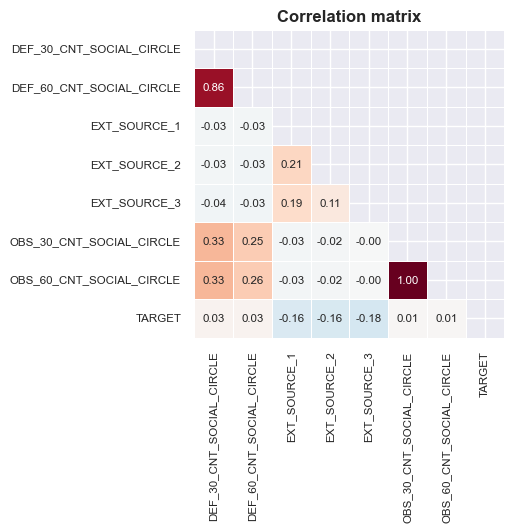

In [24]:
utils.corr_cols(df, feat_solvency)

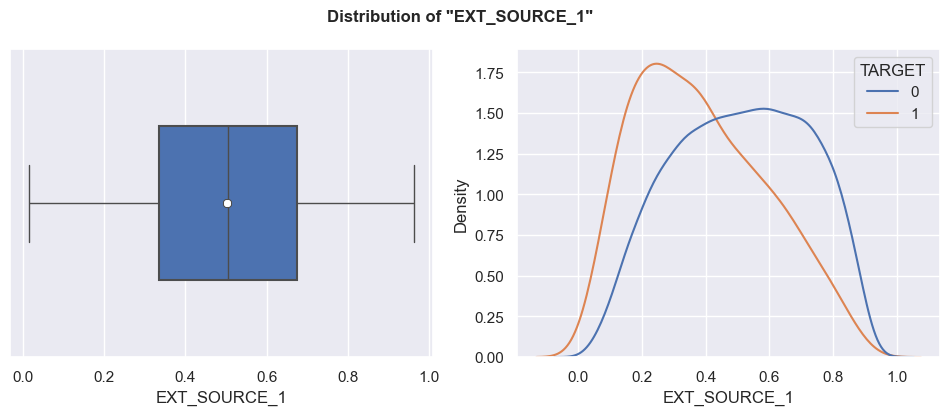

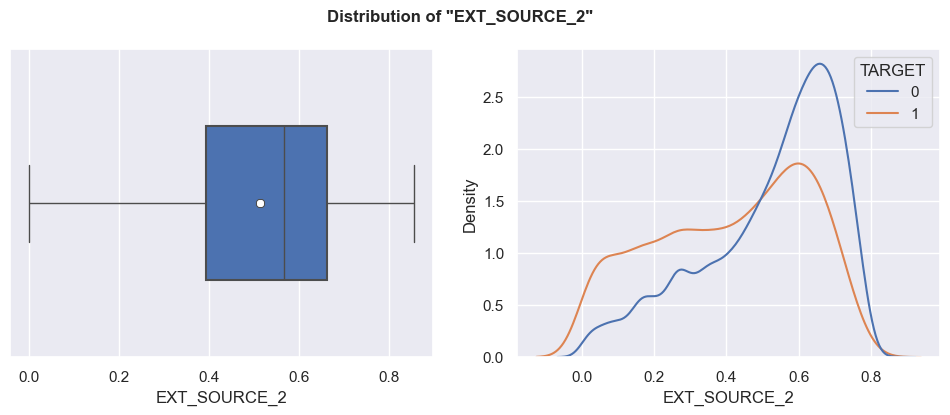

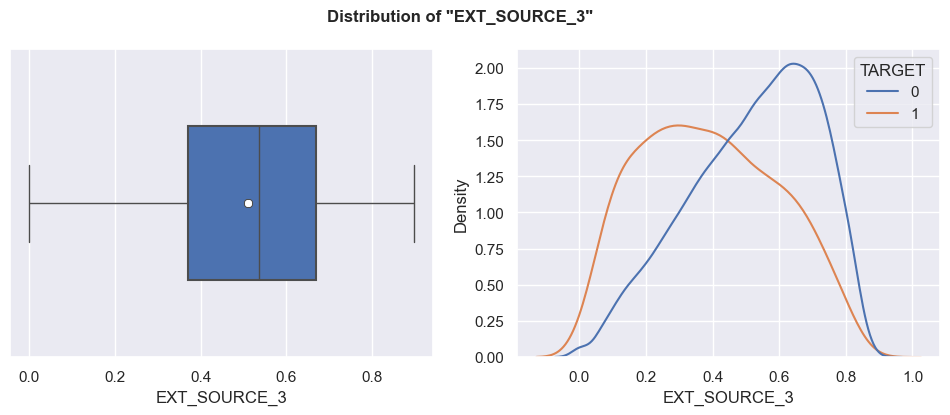

In [25]:
for col in utils.select_vars(df[feat_solvency], numeric=True):
    utils.numvar_plot(df, col)

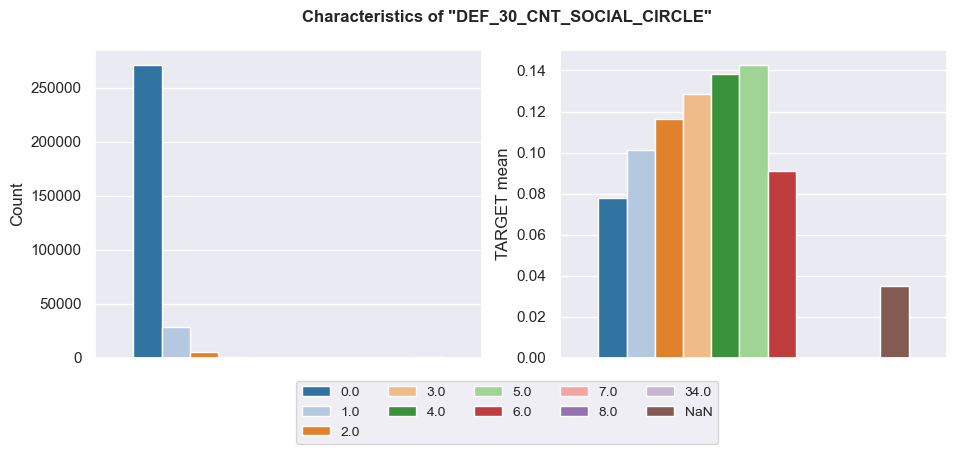

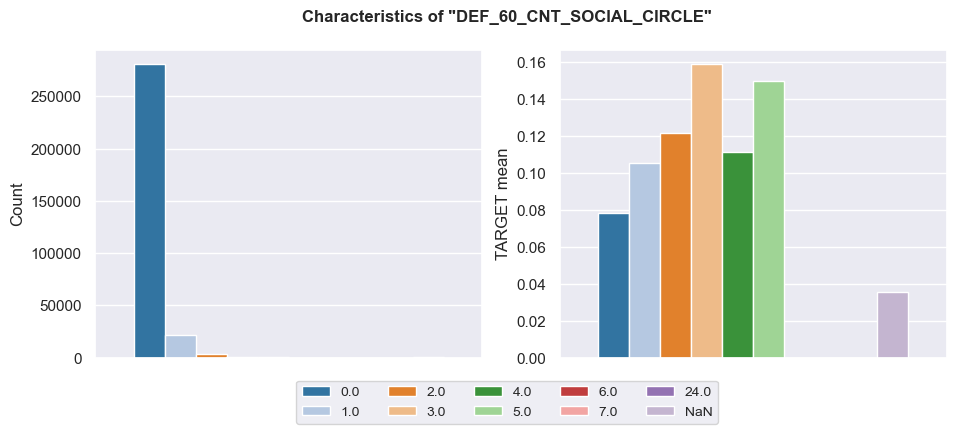

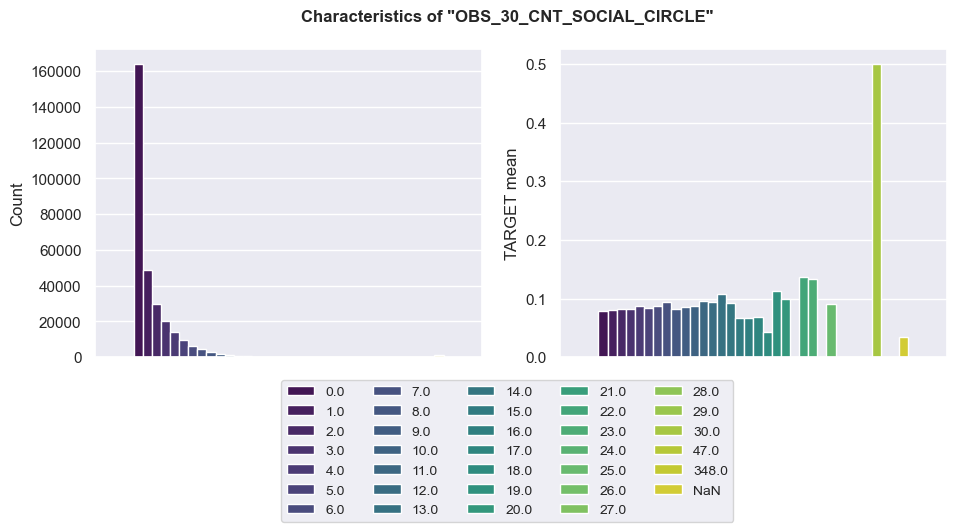

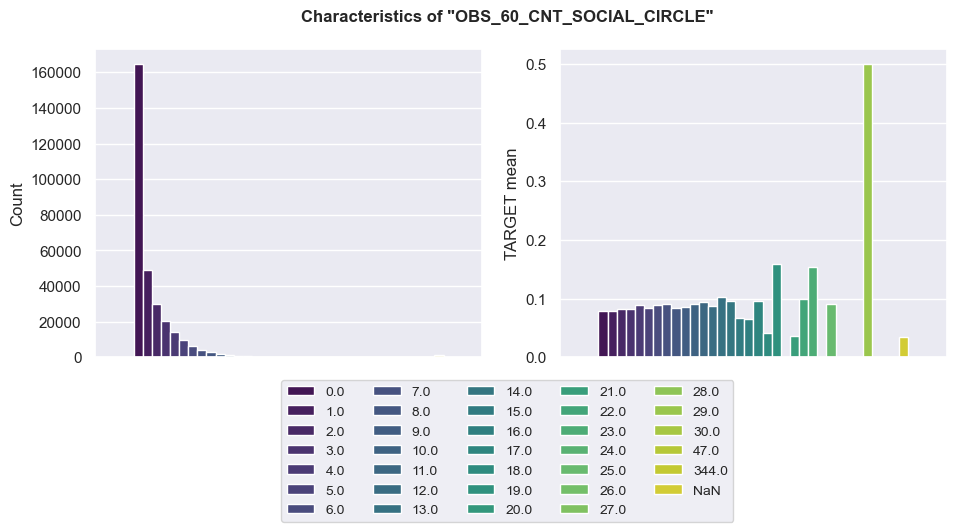

In [26]:
for col in utils.select_vars(df[feat_solvency], numeric=False):
    utils.catvar_plot(df, col)

#### <a id="feat_enquiries"></a> Признаки, отслеживающие обращения в КБ *feat_enquiries*

Четвертой группой переменных являются признаки количества обращений к кредитной истории клиента за определенный период до оформления заявки на кредит (час, день, неделя, месяц, квартал и год). Большего всего на целевой признак влияют изменения переменных с обращениями за час и день, которые используются как переменные-индикаторы (с учетом пропущенных значений).

In [27]:
pd.concat([
    df['TARGET'],
    df['AMT_REQ_CREDIT_BUREAU_DAY'].fillna(-1).replace(to_replace=[2,3,4,5,6,7,8,9], value=1, regex=True)
    ], axis=1
).groupby('AMT_REQ_CREDIT_BUREAU_DAY').agg(['mean', 'count'])

TARGET        
                            mean   count
AMT_REQ_CREDIT_BUREAU_DAY               
-1.0000                   0.1034   41519
0.0000                    0.0771  264503
1.0000                    0.0947    1489

In [28]:
utils.info_ext(df, feat_enquiries)

dtype     obs  nulls  nulls_pct
AMT_REQ_CREDIT_BUREAU_DAY   float64  265992  41519     0.1350
AMT_REQ_CREDIT_BUREAU_HOUR  float64  265992  41519     0.1350
AMT_REQ_CREDIT_BUREAU_MON   float64  265992  41519     0.1350
AMT_REQ_CREDIT_BUREAU_QRT   float64  265992  41519     0.1350
AMT_REQ_CREDIT_BUREAU_WEEK  float64  265992  41519     0.1350
AMT_REQ_CREDIT_BUREAU_YEAR  float64  265992  41519     0.1350

In [29]:
utils.top_unique_values(df[feat_enquiries], topvals=7, dropna=False)

Unique values        Top 1        Top 2  \
AMT_REQ_CREDIT_BUREAU_DAY             10  0.0 (86.0%)  nan (13.5%)   
AMT_REQ_CREDIT_BUREAU_HOUR             6  0.0 (86.0%)  nan (13.5%)   
AMT_REQ_CREDIT_BUREAU_MON             25  0.0 (72.3%)  nan (13.5%)   
AMT_REQ_CREDIT_BUREAU_QRT             12  0.0 (70.1%)  nan (13.5%)   
AMT_REQ_CREDIT_BUREAU_WEEK            10  0.0 (83.7%)  nan (13.5%)   
AMT_REQ_CREDIT_BUREAU_YEAR            26  0.0 (23.3%)  1.0 (20.6%)   

                                  Top 3        Top 4        Top 5       Top 6  \
AMT_REQ_CREDIT_BUREAU_DAY    1.0 (0.4%)   2.0 (0.0%)   3.0 (0.0%)  4.0 (0.0%)   
AMT_REQ_CREDIT_BUREAU_HOUR   1.0 (0.5%)   2.0 (0.0%)   3.0 (0.0%)  4.0 (0.0%)   
AMT_REQ_CREDIT_BUREAU_MON   1.0 (10.8%)   2.0 (1.8%)   3.0 (0.6%)  4.0 (0.3%)   
AMT_REQ_CREDIT_BUREAU_QRT   1.0 (11.0%)   2.0 (4.7%)   3.0 (0.6%)  4.0 (0.2%)   
AMT_REQ_CREDIT_BUREAU_WEEK   1.0 (2.7%)   2.0 (0.1%)   3.0 (0.0%)  4.0 (0.0%)   
AMT_REQ_CREDIT_BUREAU_YEAR  2.0 (16.3%)  nan (13.5%)  3.0 (10.9%)  4.0 (6.7%)   

                                 Top 7 Other  
AMT_REQ_CREDIT_BUREAU_DAY   5.0 (0.0%)  0.0%  
AMT_REQ_CREDIT_BUREAU_HOUR           –     –  
AMT_REQ_CREDIT_BUREAU_MON   5.0 (0.2%)  0.5%  
AMT_REQ_CREDIT_BUREAU_QRT   5.0 (0.0%)  0.0%  
AMT_REQ_CREDIT_BUREAU_WEEK  6.0 (0.0%)  0.0%  
AMT_REQ_CREDIT_BUREAU_YEAR  5.0 (3.9%)  4.6%

In [30]:
utils.iqr_outliers(df[feat_enquiries])

min     Q1   mean  median     Q3      max  \
AMT_REQ_CREDIT_BUREAU_DAY  0.0000 0.0000 0.0070  0.0000 0.0000   9.0000   
AMT_REQ_CREDIT_BUREAU_HOUR 0.0000 0.0000 0.0064  0.0000 0.0000   4.0000   
AMT_REQ_CREDIT_BUREAU_MON  0.0000 0.0000 0.2674  0.0000 0.0000  27.0000   
AMT_REQ_CREDIT_BUREAU_QRT  0.0000 0.0000 0.2655  0.0000 0.0000 261.0000   
AMT_REQ_CREDIT_BUREAU_WEEK 0.0000 0.0000 0.0344  0.0000 0.0000   8.0000   
AMT_REQ_CREDIT_BUREAU_YEAR 0.0000 0.0000 1.9000  1.0000 3.0000  25.0000   

                              std  Values < 1.5IQR  Values > 1.5IQR  
AMT_REQ_CREDIT_BUREAU_DAY  0.1108                0             1489  
AMT_REQ_CREDIT_BUREAU_HOUR 0.0838                0             1626  
AMT_REQ_CREDIT_BUREAU_MON  0.9160                0            43759  
AMT_REQ_CREDIT_BUREAU_QRT  0.7941                0            50575  
AMT_REQ_CREDIT_BUREAU_WEEK 0.2047                0             8536  
AMT_REQ_CREDIT_BUREAU_YEAR 1.8693                0             3364

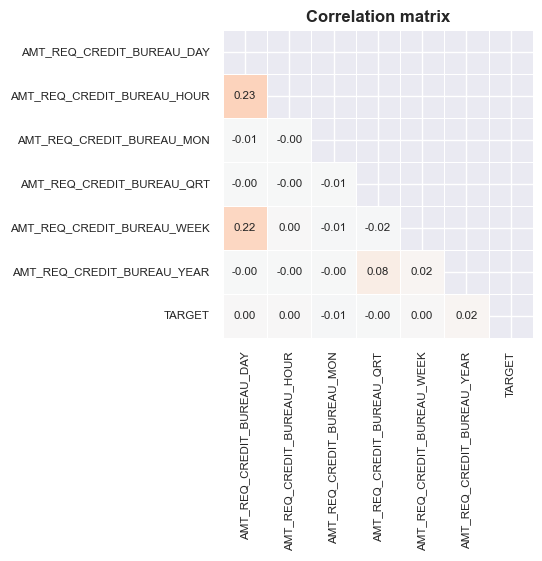

In [31]:
utils.corr_cols(df, feat_enquiries)

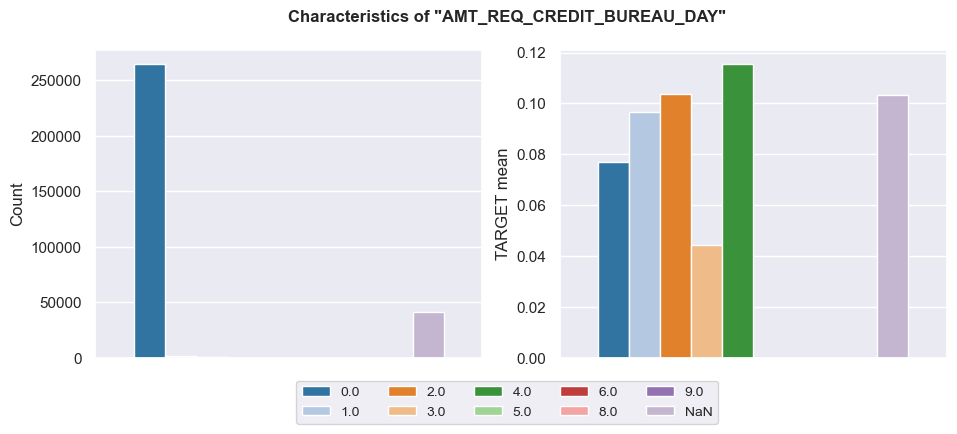

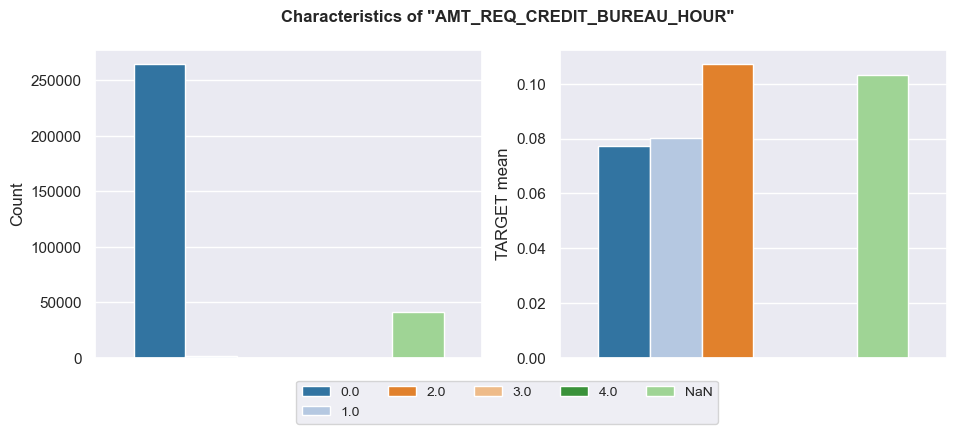

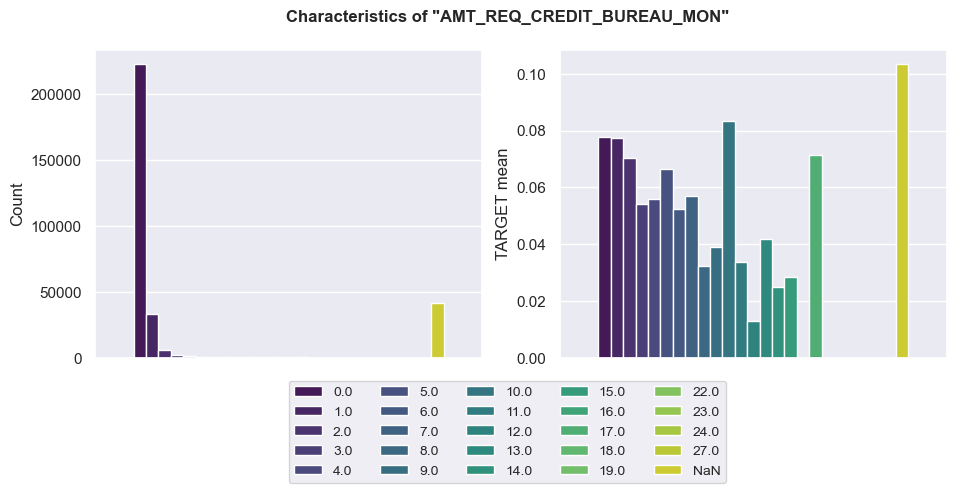

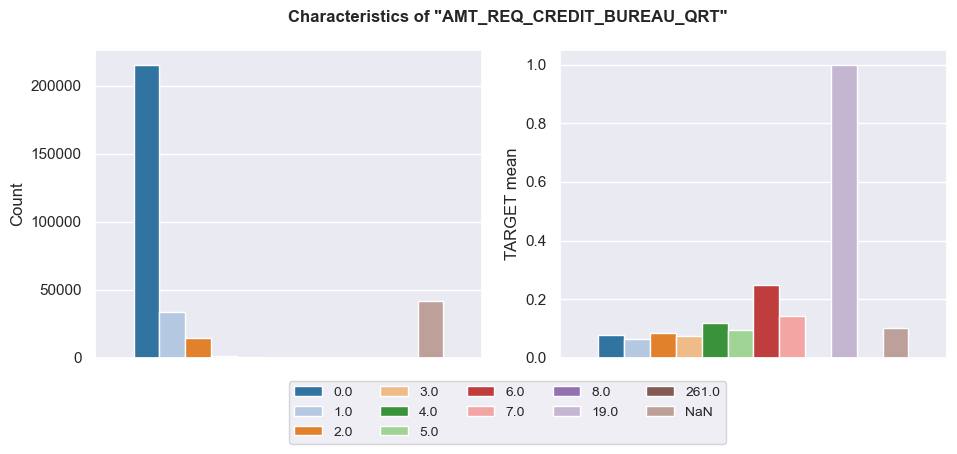

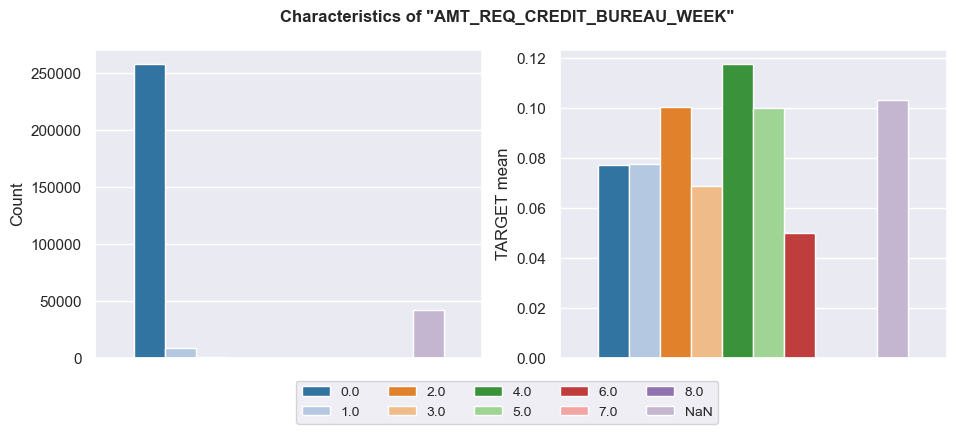

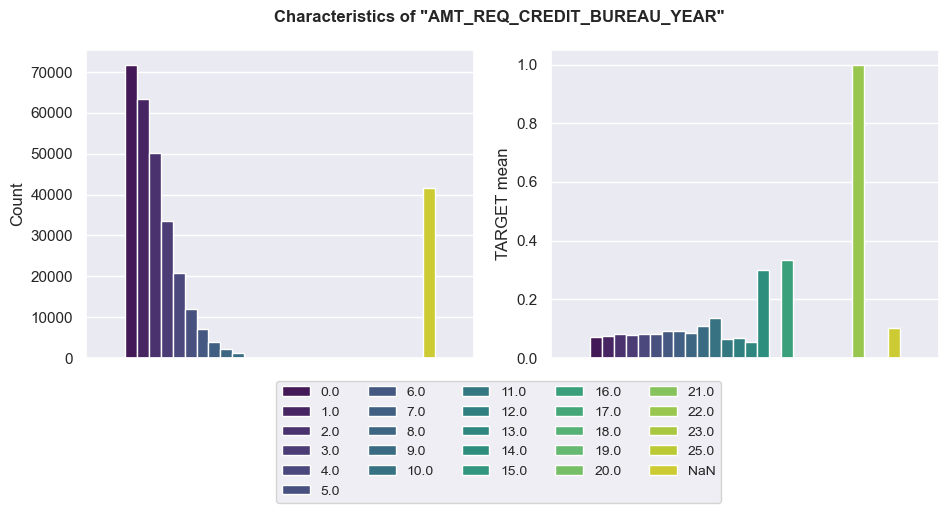

In [32]:
for col in utils.select_vars(df[feat_enquiries], numeric=False):
    utils.catvar_plot(df, col)

#### <a id="feat_assets"></a> Признаки, описывающие владение активами *feat_assets*

Пятой группой переменных являются признаки, которые указывают на владение клиентов движимым (автомобиль) и недвижимым имуществом (дом/квартира) и его характеристики. Возраст автомобиля клиента обрезан по значению трех лет (36 месяцев) с использованием переменной-индикатора для пропущенных значений. Вид постоянного жилья закодирован как среднее значение целевого признака с поправкой на редко встречаемые категории.

Например, и для владения автомобилем и жильем значение p-value для $\chi^2$ теста независимости меньше 0,05 и $H_0$ о статистической связи между двумя категориальными переменными может быть отвергнута.

In [33]:
pd.DataFrame({
    'OWN_CAR': stats.chi2_contingency(pd.crosstab(index=df['FLAG_OWN_CAR'], columns=df['TARGET']))[1],
    'OWN_REALTY': stats.chi2_contingency(pd.crosstab(index=df['FLAG_OWN_REALTY'], columns=df['TARGET']))[1]
}, index=[0])

OWN_CAR  OWN_REALTY
0   0.0000      0.0007

In [34]:
utils.info_ext(df, feat_assets)

dtype     obs   nulls  nulls_pct
FLAG_OWN_CAR         int32  307511       0     0.0000
FLAG_OWN_REALTY      int32  307511       0     0.0000
NAME_HOUSING_TYPE   object  307511       0     0.0000
OWN_CAR_AGE        float64  104582  202929     0.6599

In [35]:
utils.top_unique_values(df[feat_assets], topvals=6, dropna=False)

Unique values                      Top 1  \
FLAG_OWN_CAR                  2                  0 (66.0%)   
FLAG_OWN_REALTY               2                  1 (69.4%)   
NAME_HOUSING_TYPE             6  House / apartment (88.7%)   
OWN_CAR_AGE                  63                nan (66.0%)   

                                 Top 2                       Top 3  \
FLAG_OWN_CAR                 1 (34.0%)                           –   
FLAG_OWN_REALTY              0 (30.6%)                           –   
NAME_HOUSING_TYPE  With parents (4.8%)  Municipal apartment (3.6%)   
OWN_CAR_AGE                 7.0 (2.4%)                  6.0 (2.1%)   

                                     Top 4                    Top 5  \
FLAG_OWN_CAR                             –                        –   
FLAG_OWN_REALTY                          –                        –   
NAME_HOUSING_TYPE  Rented apartment (1.6%)  Office apartment (0.9%)   
OWN_CAR_AGE                     3.0 (2.1%)               8.0 (1.9%)   

                                    Top 6  Other  
FLAG_OWN_CAR                            –      –  
FLAG_OWN_REALTY                         –      –  
NAME_HOUSING_TYPE  Co-op apartment (0.4%)      –  
OWN_CAR_AGE                    2.0 (1.9%)  23.6%

In [36]:
utils.iqr_outliers(df[feat_assets])

min     Q1    mean  median      Q3     max     std  \
FLAG_OWN_CAR    0.0000 0.0000  0.3401  0.0000  1.0000  1.0000  0.4737   
FLAG_OWN_REALTY 0.0000 0.0000  0.6937  1.0000  1.0000  1.0000  0.4610   
OWN_CAR_AGE     0.0000 5.0000 12.0611  9.0000 15.0000 91.0000 11.9448   

                 Values < 1.5IQR  Values > 1.5IQR  
FLAG_OWN_CAR                   0                0  
FLAG_OWN_REALTY                0                0  
OWN_CAR_AGE                    0             4932

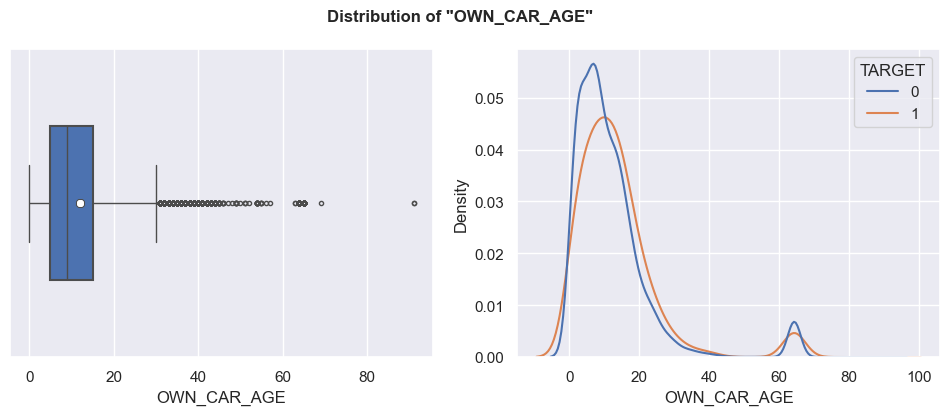

In [37]:
for col in utils.select_vars(df[feat_assets], numeric=True):
    utils.numvar_plot(df, col)

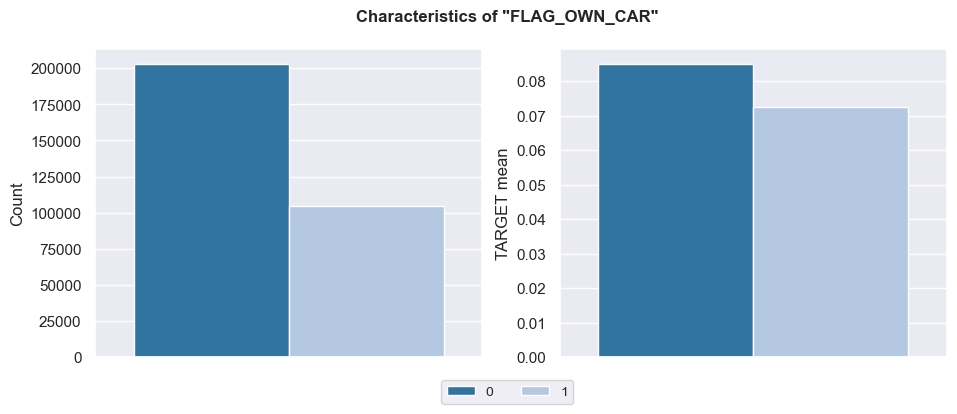

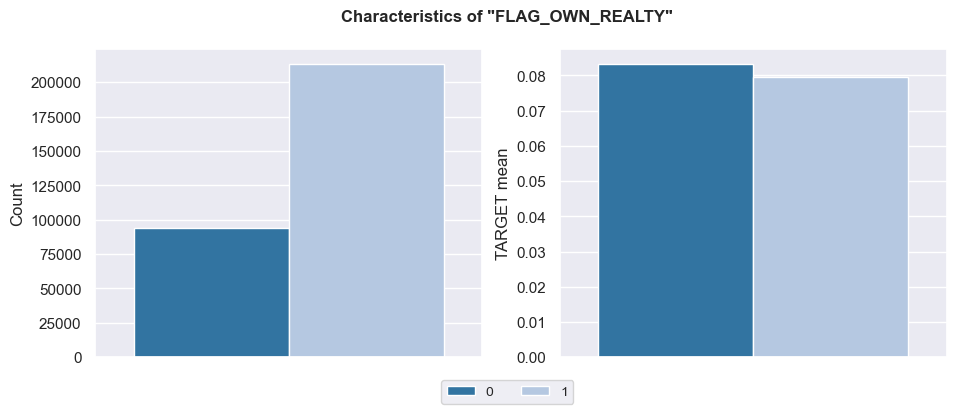

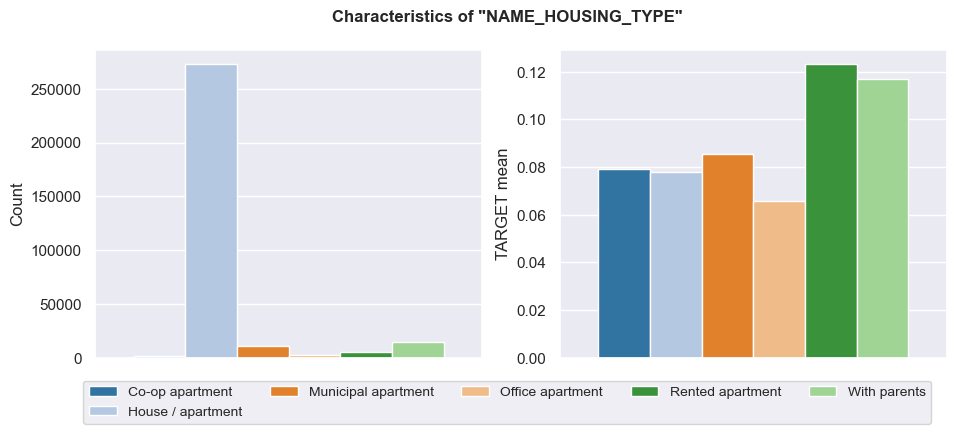

In [38]:
for col in utils.select_vars(df[feat_assets], numeric=False):
    utils.catvar_plot(df, col)

#### <a id="feat_geosocial"></a> Признаки рэнкинга региона проживания *feat_geosocial*

Шестая группа переменных содержит признаки, которые дают оценку социально-экономическому развития региона, в котором проживает потенциальный клиент. С учетом высокой корреляции между признаками *REGION_POPULATION_RELATIVE* и *REGION_RATING_CLIENT_W_CITY*, только последний из них включен в модель, как более специфичный.

In [39]:
utils.info_ext(df, feat_geosocial)

dtype     obs  nulls  nulls_pct
REGION_POPULATION_RELATIVE   float64  307511      0     0.0000
REGION_RATING_CLIENT           int64  307511      0     0.0000
REGION_RATING_CLIENT_W_CITY    int64  307511      0     0.0000

In [40]:
utils.top_unique_values(df[feat_geosocial], topvals=3, dropna=False)

Unique values                        Top 1  \
REGION_POPULATION_RELATIVE             81  0.035792000000000004 (5.3%)   
REGION_RATING_CLIENT                    3                    2 (73.8%)   
REGION_RATING_CLIENT_W_CITY             3                    2 (74.6%)   

                                      Top 2            Top 3  Other  
REGION_POPULATION_RELATIVE   0.04622 (4.4%)  0.030755 (4.0%)  86.3%  
REGION_RATING_CLIENT              3 (15.7%)        1 (10.5%)   0.0%  
REGION_RATING_CLIENT_W_CITY       3 (14.3%)        1 (11.1%)      –

In [41]:
utils.iqr_outliers(df[feat_geosocial])

min     Q1   mean  median     Q3    max    std  \
REGION_POPULATION_RELATIVE  0.0003 0.0100 0.0209  0.0188 0.0287 0.0725 0.0138   
REGION_RATING_CLIENT        1.0000 2.0000 2.0525  2.0000 2.0000 3.0000 0.5090   
REGION_RATING_CLIENT_W_CITY 1.0000 2.0000 2.0315  2.0000 2.0000 3.0000 0.5027   

                             Values < 1.5IQR  Values > 1.5IQR  
REGION_POPULATION_RELATIVE                 0             8412  
REGION_RATING_CLIENT                   32197            48330  
REGION_RATING_CLIENT_W_CITY            34167            43860

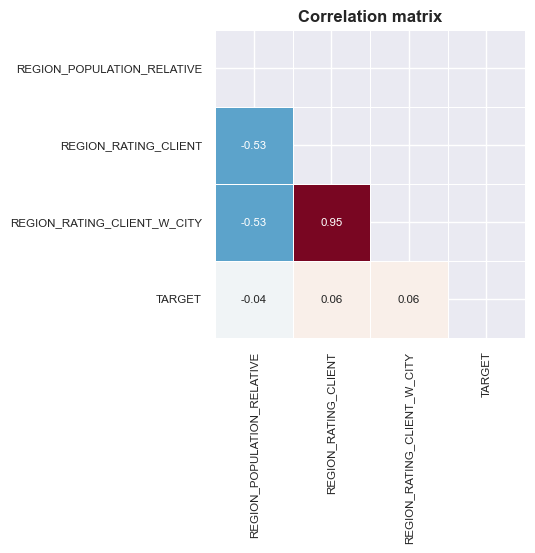

In [42]:
utils.corr_cols(df, feat_geosocial)


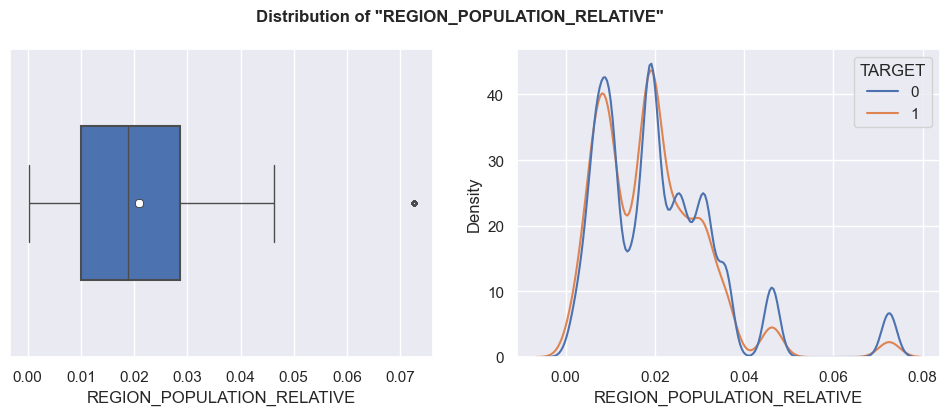

In [43]:
for col in utils.select_vars(df[feat_geosocial], numeric=True):
    utils.numvar_plot(df, col)

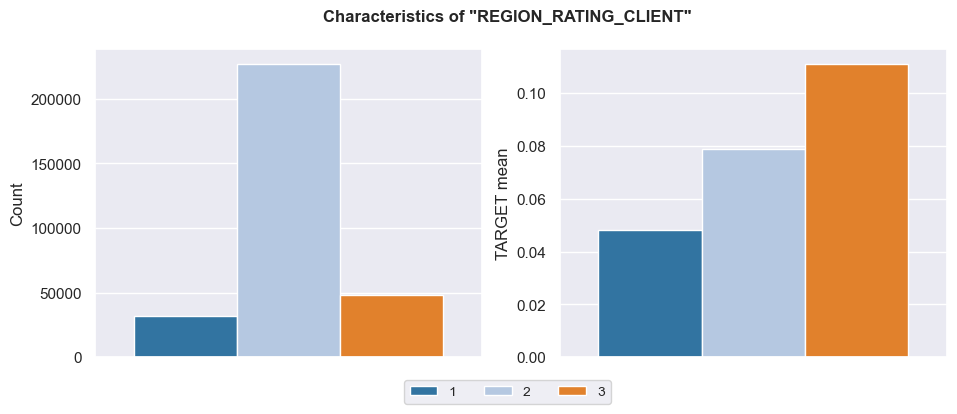

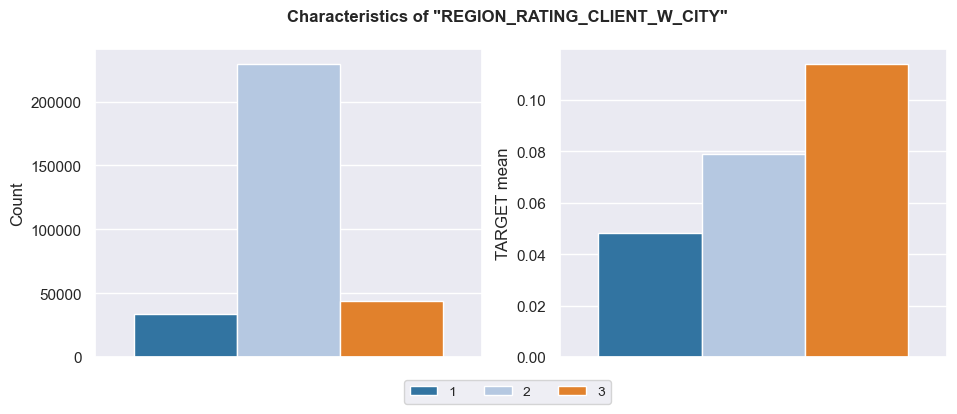

In [44]:
for col in utils.select_vars(df[feat_geosocial], numeric=False):
    utils.catvar_plot(df, col)

#### <a id="feat_personal"></a> Признаки, описывающие клиента *feat_personal*

Седьмой группой переменных являются признаки, относящиеся к личным характеристикам клиента (пол, возраст, количество детей, уровень образование и другие). Признак *CODE_GENDER* кодируется булевым значением с заполнением пропущенных значений на самое популярное наблюдение (*F*). Возраст, который изначально был представлен в виде количества дней с отрицательным знаком, переведен в метрику полных лет. Как видно из распределения данного признака в зависимости от целевой переменной большая пропорция молодых клиентов проявляет слабую финансовую дисциплину и наоборот.

In [45]:
utils.info_ext(df, feat_personal)

dtype     obs  nulls  nulls_pct
CNT_CHILDREN           int64  307511      0     0.0000
CNT_FAM_MEMBERS      float64  307509      2     0.0000
CODE_GENDER           object  307507      4     0.0000
DAYS_BIRTH           float64  307511      0     0.0000
NAME_EDUCATION_TYPE   object  307511      0     0.0000
NAME_FAMILY_STATUS    object  307511      0     0.0000
NAME_TYPE_SUITE       object  306219   1292     0.0042

In [46]:
utils.top_unique_values(df[feat_personal], topvals=7, dropna=False)

Unique values                                  Top 1  \
CNT_CHILDREN                   15                              0 (70.0%)   
CNT_FAM_MEMBERS                18                            2.0 (51.5%)   
CODE_GENDER                     3                              F (65.8%)   
DAYS_BIRTH                     98                            78.0 (1.5%)   
NAME_EDUCATION_TYPE             4  Secondary / secondary special (71.0%)   
NAME_FAMILY_STATUS              6                        Married (63.9%)   
NAME_TYPE_SUITE                 8                  Unaccompanied (80.8%)   

                                            Top 2                     Top 3  \
CNT_CHILDREN                            1 (19.9%)                  2 (8.7%)   
CNT_FAM_MEMBERS                       1.0 (22.1%)               3.0 (17.1%)   
CODE_GENDER                             M (34.2%)                nan (0.0%)   
DAYS_BIRTH                            79.0 (1.5%)               76.0 (1.4%)   
NAME_EDUCATION_TYPE      Higher education (24.4%)  Incomplete higher (3.3%)   
NAME_FAMILY_STATUS   Single / not married (14.8%)     Civil marriage (9.7%)   
NAME_TYPE_SUITE                    Family (13.1%)    Spouse, partner (3.7%)   

                                      Top 4           Top 5           Top 6  \
CNT_CHILDREN                       3 (1.2%)        4 (0.1%)        5 (0.0%)   
CNT_FAM_MEMBERS                  4.0 (8.0%)      5.0 (1.1%)      6.0 (0.1%)   
CODE_GENDER                               –               –               –   
DAYS_BIRTH                      56.0 (1.4%)     74.0 (1.4%)     75.0 (1.4%)   
NAME_EDUCATION_TYPE  Lower secondary (1.2%)               –               –   
NAME_FAMILY_STATUS         Separated (6.4%)    Widow (5.2%)  Unknown (0.0%)   
NAME_TYPE_SUITE             Children (1.1%)  Other_B (0.6%)     None (0.4%)   

                              Top 7  Other  
CNT_CHILDREN               6 (0.0%)   0.0%  
CNT_FAM_MEMBERS          7.0 (0.0%)   0.0%  
CODE_GENDER                       –   0.0%  
DAYS_BIRTH              77.0 (1.4%)  89.9%  
NAME_EDUCATION_TYPE               –      –  
NAME_FAMILY_STATUS                –      –  
NAME_TYPE_SUITE      Other_A (0.3%)   0.1%

In [47]:
utils.iqr_outliers(df[feat_personal])

min      Q1    mean  median       Q3      max     std  \
CNT_CHILDREN     0.0000  0.0000  0.4171  0.0000   1.0000  19.0000  0.7221   
CNT_FAM_MEMBERS  1.0000  2.0000  2.1527  2.0000   3.0000  20.0000  0.9107   
DAYS_BIRTH      42.0000 69.0000 88.3717 87.0000 108.0000 139.0000 23.9133   

                 Values < 1.5IQR  Values > 1.5IQR  
CNT_CHILDREN                   0             4272  
CNT_FAM_MEMBERS                0             4007  
DAYS_BIRTH                     0                0

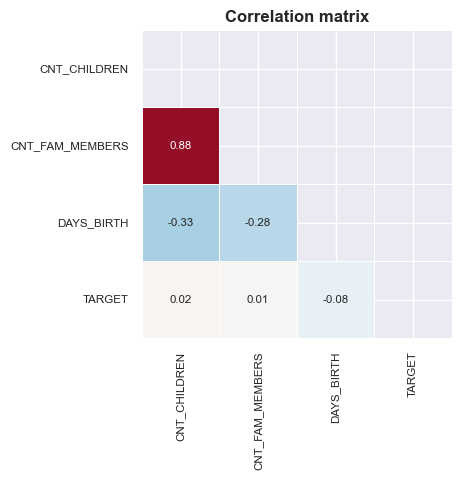

In [48]:
utils.corr_cols(df, feat_personal)

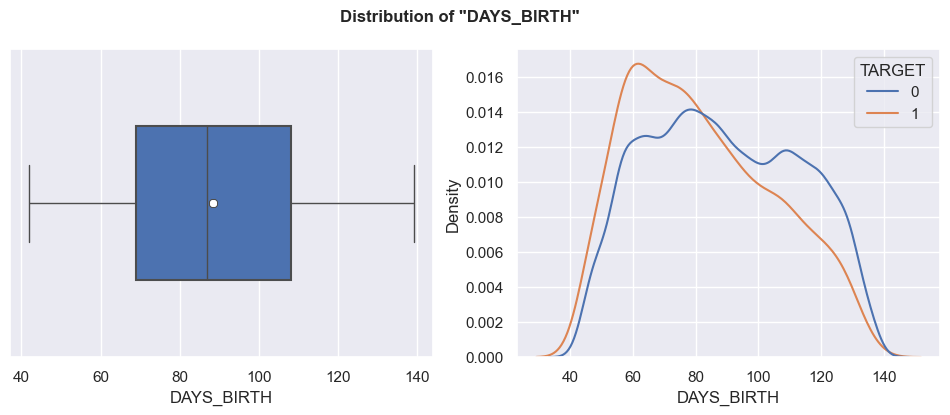

In [49]:
for col in utils.select_vars(df[feat_personal], numeric=True, cat_lim=25):
    utils.numvar_plot(df, col)

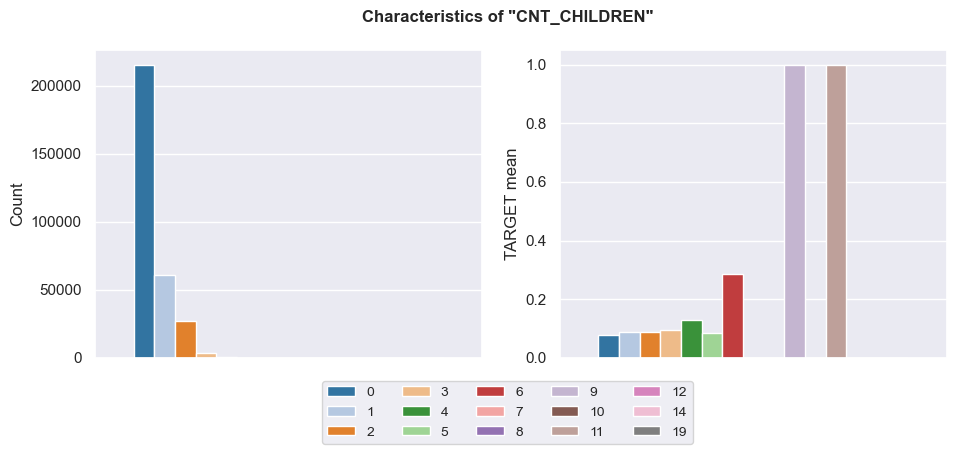

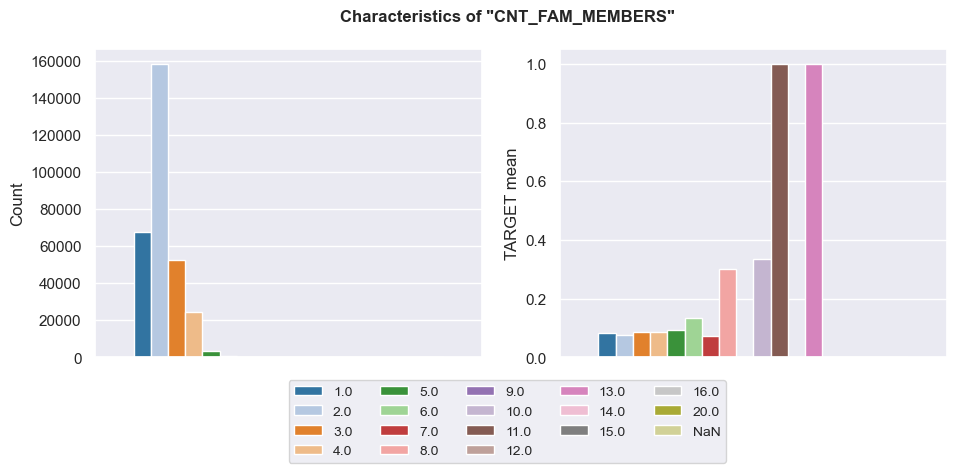

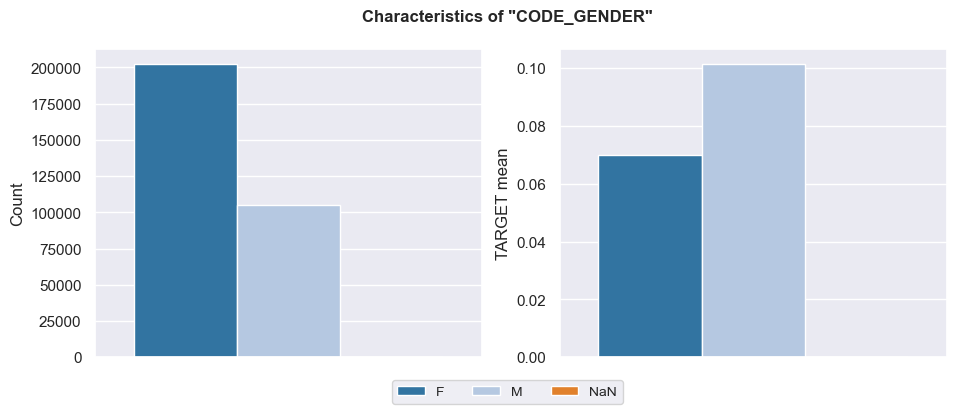

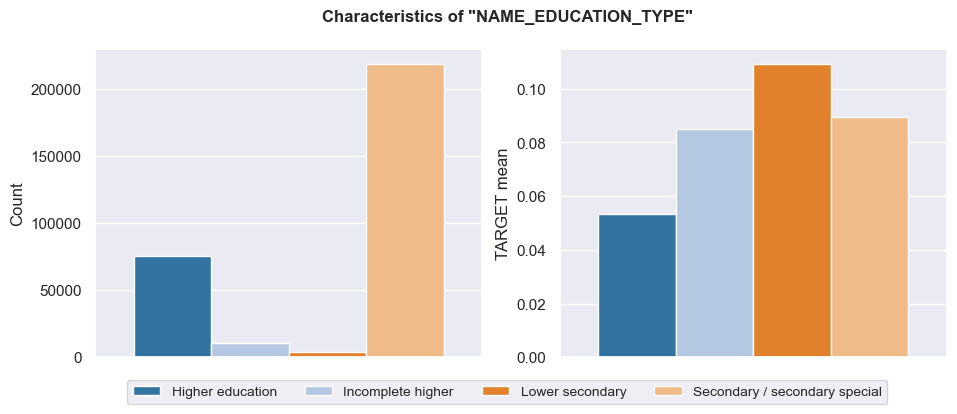

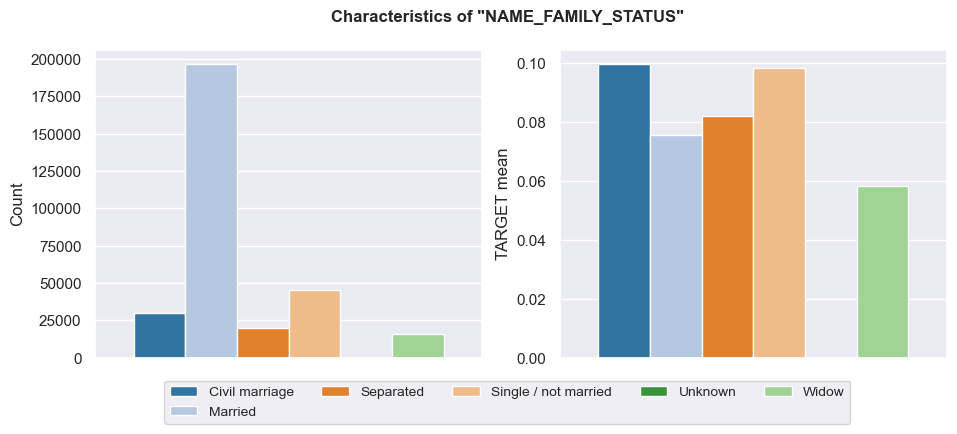

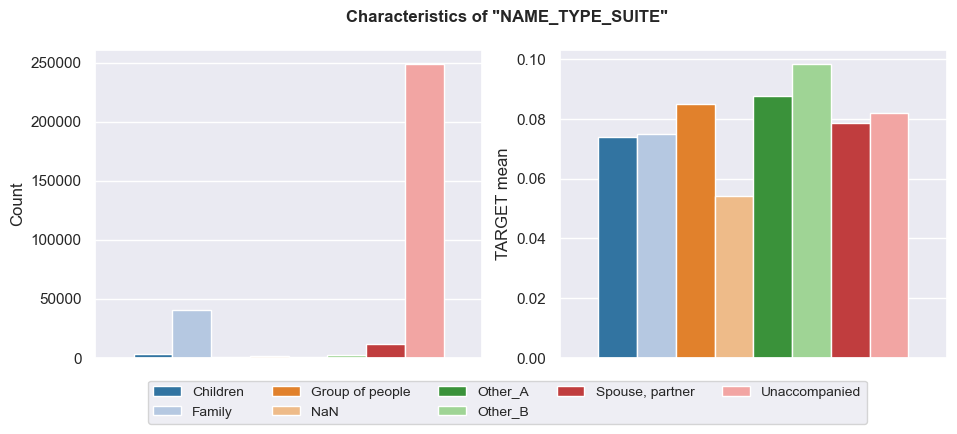

In [50]:
for col in utils.select_vars(df[feat_personal], numeric=False, cat_lim=25):
    utils.catvar_plot(df, col)

#### <a id="feat_events"></a> Признаки важных событий *feat_events*

Восьмой группой переменных являются признаки, которые рассчитывают период времени, прошедший с момента важного события в жизни клиента (период работы на последнем месте, выпуск удостоверяющего документа, регистрация по месту жительства и другое). Все переменные дискредитированы на интервалы по полугоду, а пропущенные значения заполнены средним значением.

In [51]:
utils.info_ext(df, feat_events)

dtype     obs  nulls  nulls_pct
DAYS_EMPLOYED           float64  252137  55374     0.1801
DAYS_ID_PUBLISH         float64  307511      0     0.0000
DAYS_LAST_PHONE_CHANGE  float64  307510      1     0.0000
DAYS_REGISTRATION       float64  307511      0     0.0000

In [52]:
utils.top_unique_values(df[feat_events], topvals=7, dropna=False)

Unique values         Top 1        Top 2        Top 3  \
DAYS_EMPLOYED                     97   nan (18.0%)   1.0 (6.2%)   2.0 (5.4%)   
DAYS_ID_PUBLISH                   38   23.0 (7.2%)  24.0 (6.9%)  22.0 (6.5%)   
DAYS_LAST_PHONE_CHANGE            26  -0.0 (17.9%)  2.0 (10.1%)   3.0 (9.5%)   
DAYS_REGISTRATION                124    2.0 (2.6%)   4.0 (2.6%)   1.0 (2.6%)   

                              Top 4        Top 5        Top 6        Top 7  \
DAYS_EMPLOYED            4.0 (5.0%)   3.0 (5.0%)   5.0 (4.8%)   6.0 (4.5%)   
DAYS_ID_PUBLISH         25.0 (6.4%)  26.0 (5.0%)  27.0 (3.3%)  19.0 (3.3%)   
DAYS_LAST_PHONE_CHANGE   4.0 (7.9%)   1.0 (7.0%)   9.0 (6.2%)   5.0 (5.9%)   
DAYS_REGISTRATION        3.0 (2.5%)   5.0 (2.4%)   6.0 (2.3%)  25.0 (2.1%)   

                        Other  
DAYS_EMPLOYED           51.0%  
DAYS_ID_PUBLISH         61.5%  
DAYS_LAST_PHONE_CHANGE  35.5%  
DAYS_REGISTRATION       83.0%

In [53]:
utils.iqr_outliers(df[feat_events])

min      Q1    mean  median      Q3      max  \
DAYS_EMPLOYED           0.0000  4.0000 13.0632  9.0000 17.0000  98.0000   
DAYS_ID_PUBLISH         0.0000  9.0000 16.4035 18.0000 24.0000  39.0000   
DAYS_LAST_PHONE_CHANGE -0.0000  2.0000  5.2727  4.0000  9.0000  24.0000   
DAYS_REGISTRATION       0.0000 11.0000 27.3183 25.0000 41.0000 135.0000   

                           std  Values < 1.5IQR  Values > 1.5IQR  
DAYS_EMPLOYED          12.8102                0            15786  
DAYS_ID_PUBLISH         8.2786                0                0  
DAYS_LAST_PHONE_CHANGE  4.5392                0              341  
DAYS_REGISTRATION      19.3077                0              602

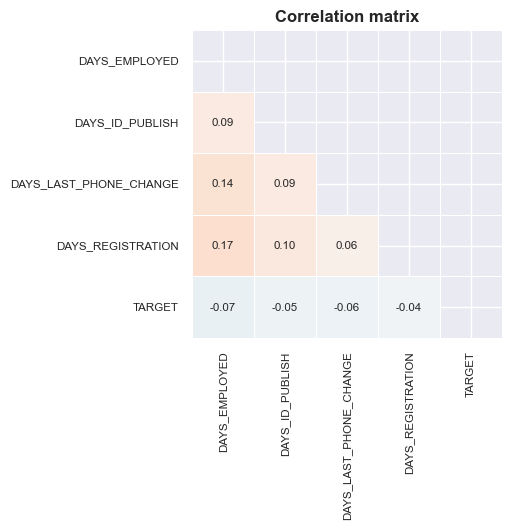

In [54]:
utils.corr_cols(df, feat_events)

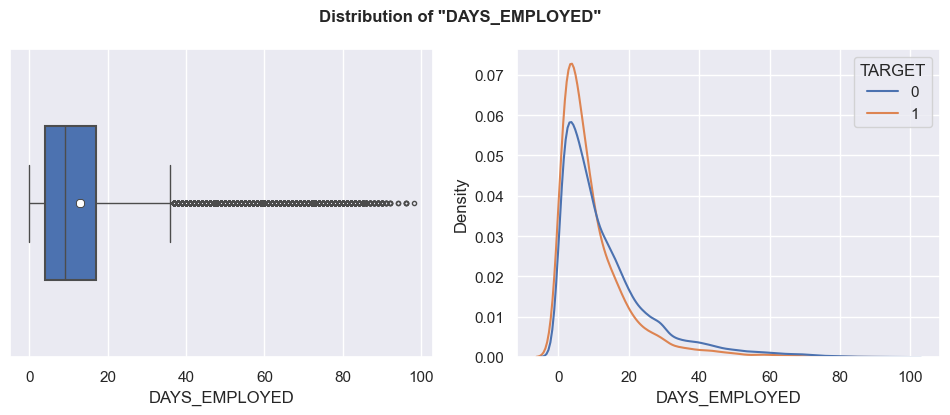

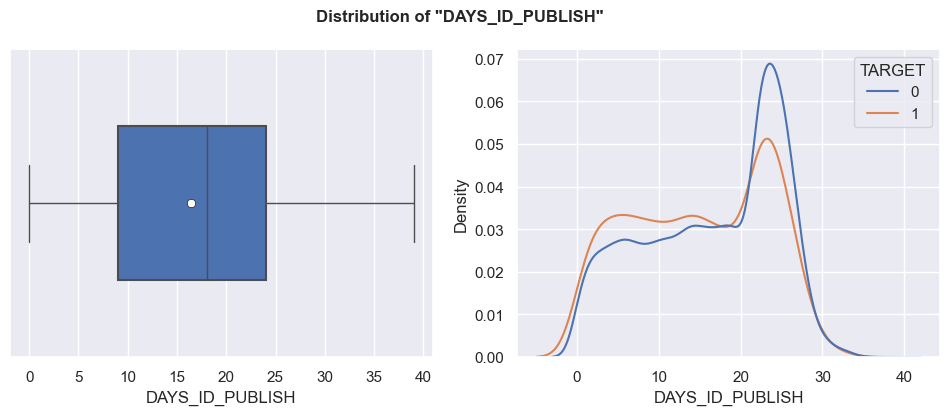

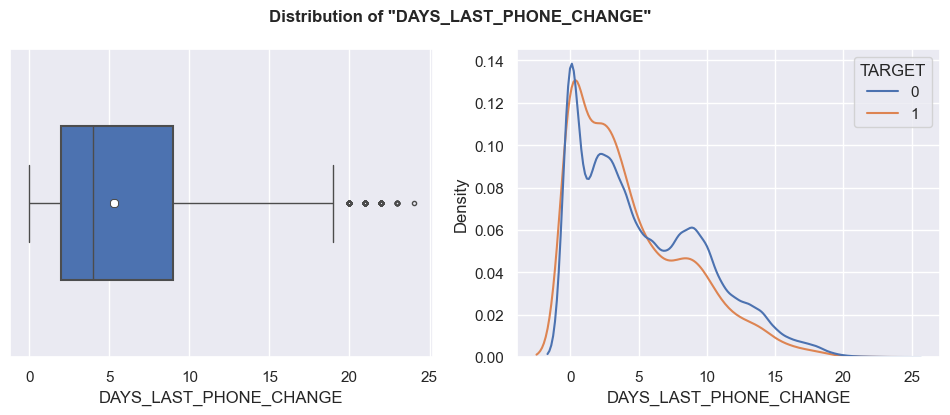

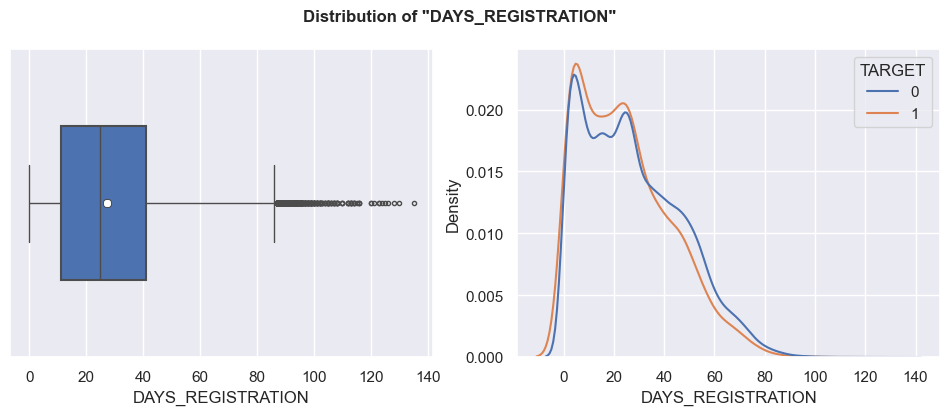

In [55]:
for col in utils.select_vars(df[feat_events], numeric=True, cat_lim=20):
    utils.numvar_plot(df, col)

#### <a id="feat_relocation"></a> Признаки, отслеживающие перемещения клиентов *feat_relocation*

Девятой группой переменных являются признаки, которые сигнализирует, если клиент живет или работает в населенном пункте, отличающимся от прописки. Всего в группу включено шесть переменных-индикаторов, из которых в модель включены только три, имеющие наибольшую корреляцию с целевой переменной и разделяющие наблюдения на две более равномерные группы.

In [56]:
utils.info_ext(df, feat_relocation)

dtype     obs  nulls  nulls_pct
LIVE_CITY_NOT_WORK_CITY      int64  307511      0     0.0000
LIVE_REGION_NOT_WORK_REGION  int64  307511      0     0.0000
REG_CITY_NOT_LIVE_CITY       int64  307511      0     0.0000
REG_CITY_NOT_WORK_CITY       int64  307511      0     0.0000
REG_REGION_NOT_LIVE_REGION   int64  307511      0     0.0000
REG_REGION_NOT_WORK_REGION   int64  307511      0     0.0000

In [57]:
utils.top_unique_values(df[feat_relocation], topvals=2, dropna=False)

Unique values      Top 1      Top 2 Other
LIVE_CITY_NOT_WORK_CITY                 2  0 (82.0%)  1 (18.0%)     –
LIVE_REGION_NOT_WORK_REGION             2  0 (95.9%)   1 (4.1%)     –
REG_CITY_NOT_LIVE_CITY                  2  0 (92.2%)   1 (7.8%)     –
REG_CITY_NOT_WORK_CITY                  2  0 (77.0%)  1 (23.0%)     –
REG_REGION_NOT_LIVE_REGION              2  0 (98.5%)   1 (1.5%)     –
REG_REGION_NOT_WORK_REGION              2  0 (94.9%)   1 (5.1%)     –

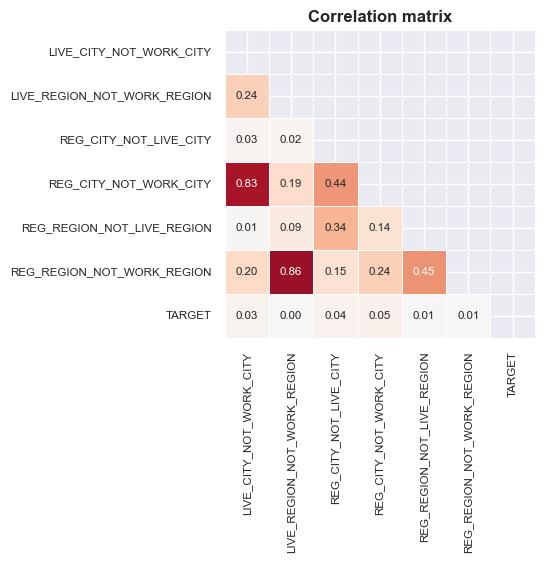

In [58]:
utils.corr_cols(df, feat_relocation)

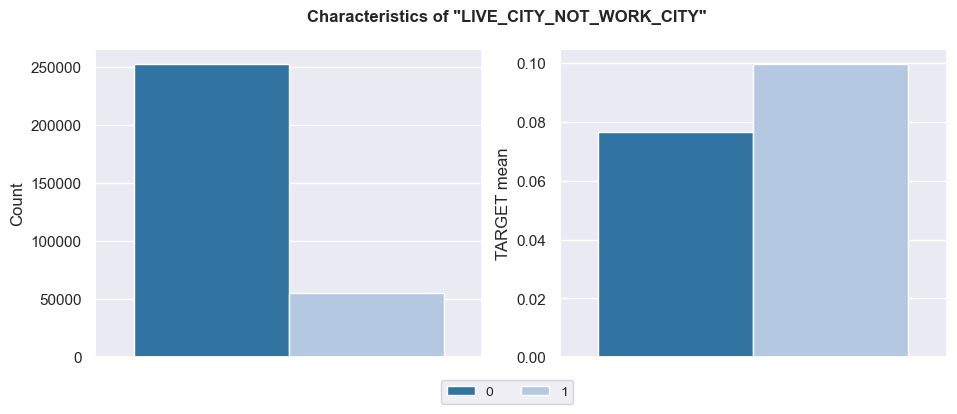

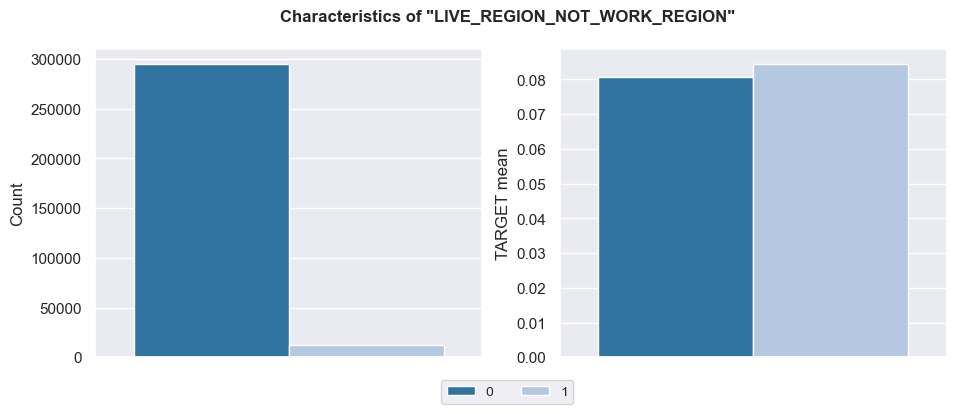

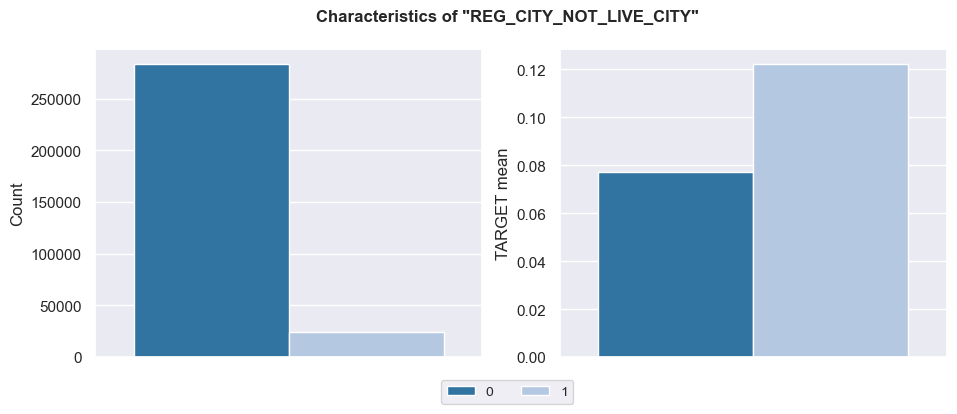

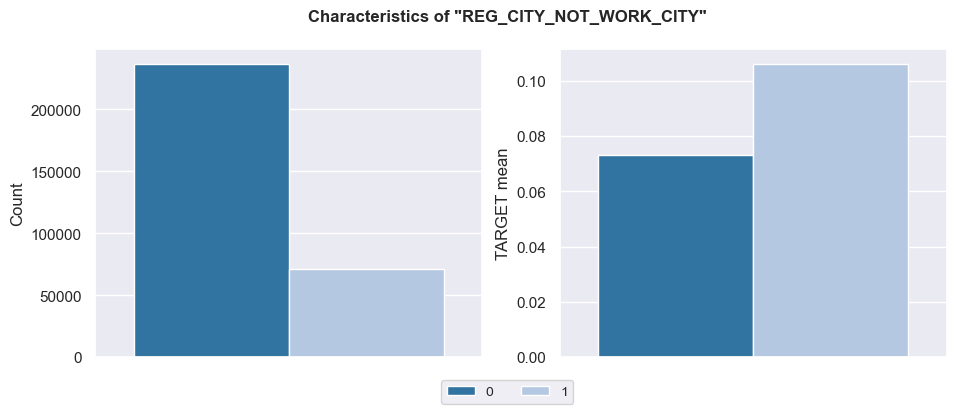

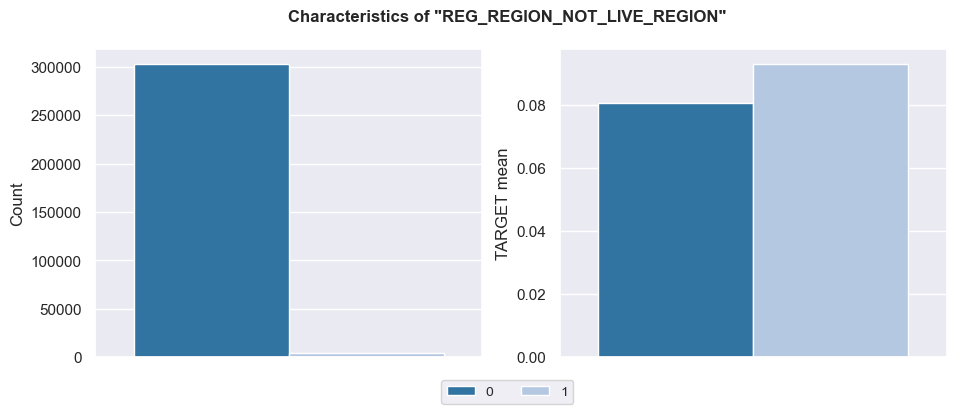

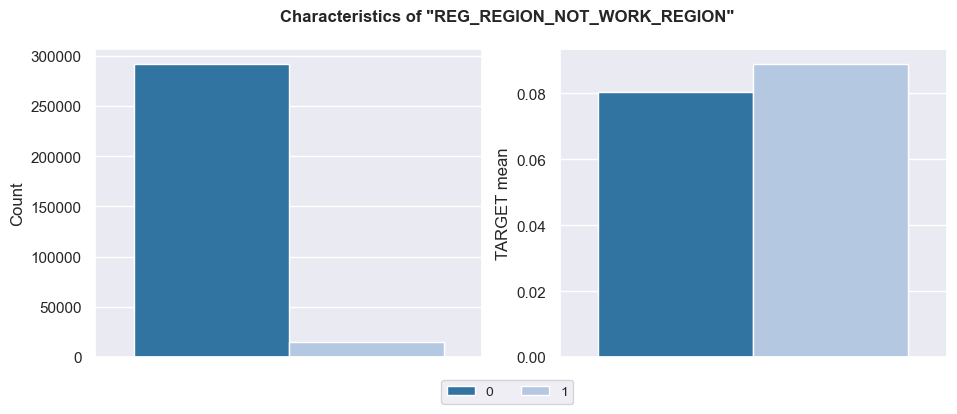

In [59]:
for col in utils.select_vars(df[feat_relocation], numeric=False):
    utils.catvar_plot(df, col)

#### <a id="feat_docs"></a> Признаки подачи сопутствующих документов *feat_docs*

Десятой группой переменных являются признаки, перечисляющие перечень документов, которые были поданы вместе с кредитной заявкой. В соответствии с коэффициентами корреляции с целевой переменной и ее средними значениями в зависимости от значения переменной, в дальнейшем будут использоваться только три признака из перечисленных (*FLAG_DOCUMENT_3*, *FLAG_DOCUMENT_6* и *FLAG_DOCUMENT_8*).

In [60]:
utils.info_ext(df, feat_docs)

dtype     obs  nulls  nulls_pct
FLAG_DOCUMENT_2   int64  307511      0     0.0000
FLAG_DOCUMENT_3   int64  307511      0     0.0000
FLAG_DOCUMENT_4   int64  307511      0     0.0000
FLAG_DOCUMENT_5   int64  307511      0     0.0000
FLAG_DOCUMENT_6   int64  307511      0     0.0000
FLAG_DOCUMENT_7   int64  307511      0     0.0000
FLAG_DOCUMENT_8   int64  307511      0     0.0000
FLAG_DOCUMENT_9   int64  307511      0     0.0000
FLAG_DOCUMENT_10  int64  307511      0     0.0000
FLAG_DOCUMENT_11  int64  307511      0     0.0000
FLAG_DOCUMENT_12  int64  307511      0     0.0000
FLAG_DOCUMENT_13  int64  307511      0     0.0000
FLAG_DOCUMENT_14  int64  307511      0     0.0000
FLAG_DOCUMENT_15  int64  307511      0     0.0000
FLAG_DOCUMENT_16  int64  307511      0     0.0000
FLAG_DOCUMENT_17  int64  307511      0     0.0000
FLAG_DOCUMENT_18  int64  307511      0     0.0000
FLAG_DOCUMENT_19  int64  307511      0     0.0000
FLAG_DOCUMENT_20  int64  307511      0     0.0000
FLAG_DOCUMENT_21  int64  307511      0     0.0000

In [61]:
utils.top_unique_values(df[feat_docs], topvals=2, dropna=False)

Unique values       Top 1      Top 2 Other
FLAG_DOCUMENT_2              2  0 (100.0%)   1 (0.0%)     –
FLAG_DOCUMENT_3              2   1 (71.0%)  0 (29.0%)     –
FLAG_DOCUMENT_4              2  0 (100.0%)   1 (0.0%)     –
FLAG_DOCUMENT_5              2   0 (98.5%)   1 (1.5%)     –
FLAG_DOCUMENT_6              2   0 (91.2%)   1 (8.8%)     –
FLAG_DOCUMENT_7              2  0 (100.0%)   1 (0.0%)     –
FLAG_DOCUMENT_8              2   0 (91.9%)   1 (8.1%)     –
FLAG_DOCUMENT_9              2   0 (99.6%)   1 (0.4%)     –
FLAG_DOCUMENT_10             2  0 (100.0%)   1 (0.0%)     –
FLAG_DOCUMENT_11             2   0 (99.6%)   1 (0.4%)     –
FLAG_DOCUMENT_12             2  0 (100.0%)   1 (0.0%)     –
FLAG_DOCUMENT_13             2   0 (99.6%)   1 (0.4%)     –
FLAG_DOCUMENT_14             2   0 (99.7%)   1 (0.3%)     –
FLAG_DOCUMENT_15             2   0 (99.9%)   1 (0.1%)     –
FLAG_DOCUMENT_16             2   0 (99.0%)   1 (1.0%)     –
FLAG_DOCUMENT_17             2  0 (100.0%)   1 (0.0%)     –
FLAG_DOCUMENT_18             2   0 (99.2%)   1 (0.8%)     –
FLAG_DOCUMENT_19             2   0 (99.9%)   1 (0.1%)     –
FLAG_DOCUMENT_20             2   0 (99.9%)   1 (0.1%)     –
FLAG_DOCUMENT_21             2  0 (100.0%)   1 (0.0%)     –

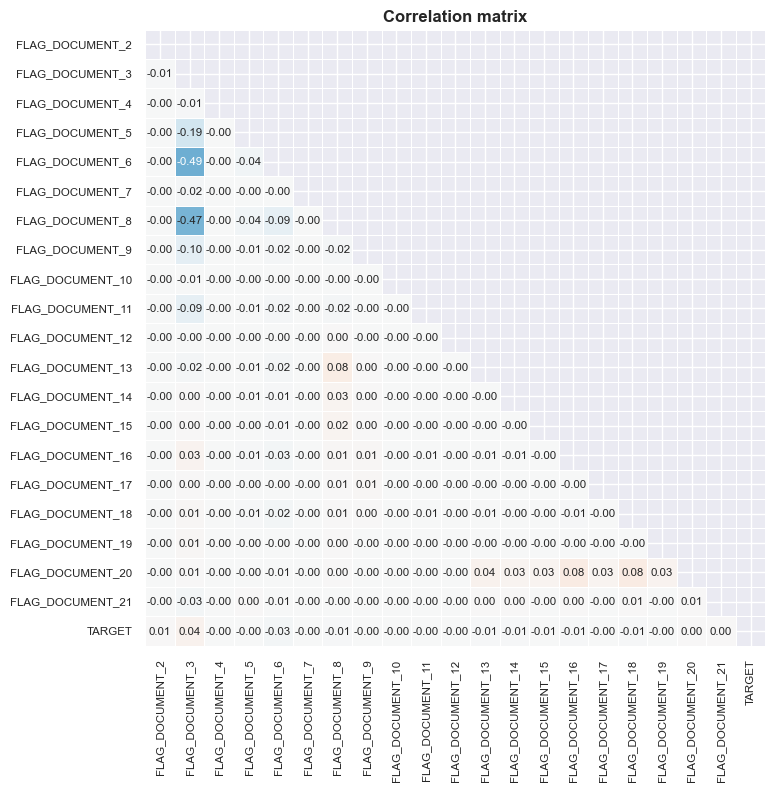

In [62]:
utils.corr_cols(df, feat_docs)

In [63]:
feat_docs_new = ['FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_8']

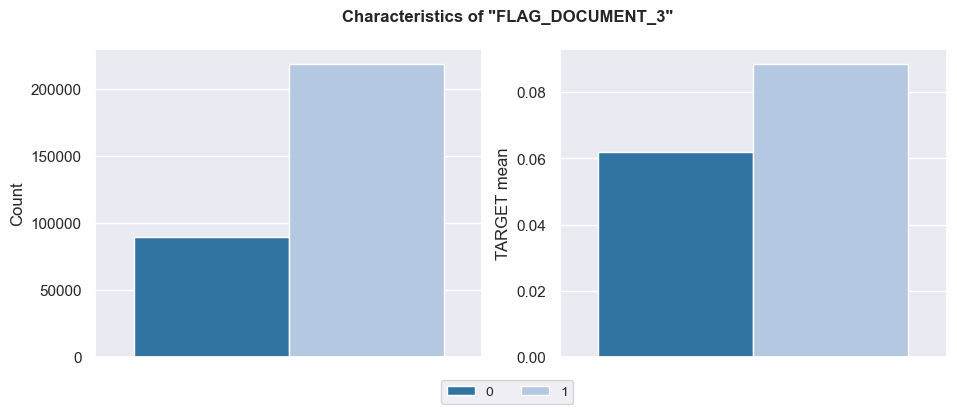

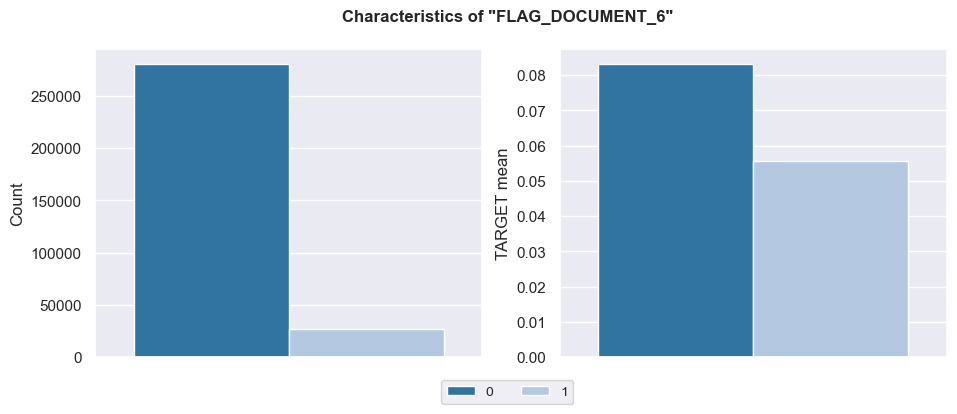

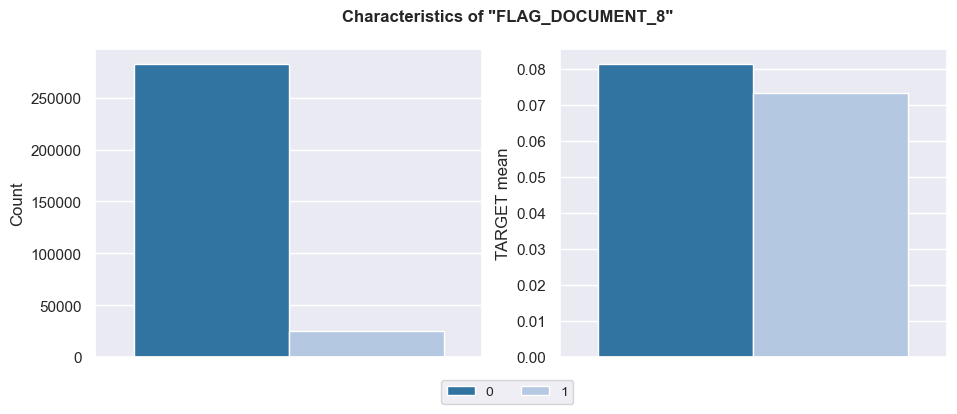

In [64]:
for col in utils.select_vars(df[feat_docs_new], numeric=False, cat_lim=10):
    utils.catvar_plot(df, col)

#### <a id="feat_housing"></a> Признаки с параметрами жилья клиентов *feat_housing*

Одиннадцатой группой переменных являются признаки, описывающие характеристики жилья, в котором проживает клиент (площадь, количество комнат и этажей, материал стен и другое). Всего в группе 47 признаков, большинство из которых рассчитано в трех вариант: нормализированное значения для жилья клиента относительно среднего, медианного и модального значения в выборке, имеющейся у организации. Так как подавляющее большинство признаков имеют схожее распределение в разрезе значений целевой переменной и высокую линейную зависимость между друг другом, из группы выбрано только восемь признаков - четыре численных и четыре категориальных.

In [65]:
utils.info_ext(df, feat_housing)

dtype     obs   nulls  nulls_pct
APARTMENTS_AVG                float64  151450  156061     0.5075
APARTMENTS_MEDI               float64  151450  156061     0.5075
APARTMENTS_MODE               float64  151450  156061     0.5075
BASEMENTAREA_AVG              float64  127568  179943     0.5852
BASEMENTAREA_MEDI             float64  127568  179943     0.5852
BASEMENTAREA_MODE             float64  127568  179943     0.5852
COMMONAREA_AVG                float64   92646  214865     0.6987
COMMONAREA_MEDI               float64   92646  214865     0.6987
COMMONAREA_MODE               float64   92646  214865     0.6987
ELEVATORS_AVG                 float64  143620  163891     0.5330
ELEVATORS_MEDI                float64  143620  163891     0.5330
ELEVATORS_MODE                float64  143620  163891     0.5330
EMERGENCYSTATE_MODE            object  161756  145755     0.4740
ENTRANCES_AVG                 float64  152683  154828     0.5035
ENTRANCES_MEDI                float64  152683  154828     0.5035
ENTRANCES_MODE                float64  152683  154828     0.5035
FLOORSMAX_AVG                 float64  154491  153020     0.4976
FLOORSMAX_MEDI                float64  154491  153020     0.4976
FLOORSMAX_MODE                float64  154491  153020     0.4976
FLOORSMIN_AVG                 float64   98869  208642     0.6785
FLOORSMIN_MEDI                float64   98869  208642     0.6785
FLOORSMIN_MODE                float64   98869  208642     0.6785
FONDKAPREMONT_MODE             object   97216  210295     0.6839
HOUSETYPE_MODE                 object  153214  154297     0.5018
LANDAREA_AVG                  float64  124921  182590     0.5938
LANDAREA_MEDI                 float64  124921  182590     0.5938
LANDAREA_MODE                 float64  124921  182590     0.5938
LIVINGAPARTMENTS_AVG          float64   97312  210199     0.6835
LIVINGAPARTMENTS_MEDI         float64   97312  210199     0.6835
LIVINGAPARTMENTS_MODE         float64   97312  210199     0.6835
LIVINGAREA_AVG                float64  153161  154350     0.5019
LIVINGAREA_MEDI               float64  153161  154350     0.5019
LIVINGAREA_MODE               float64  153161  154350     0.5019
NONLIVINGAPARTMENTS_AVG       float64   93997  213514     0.6943
NONLIVINGAPARTMENTS_MEDI      float64   93997  213514     0.6943
NONLIVINGAPARTMENTS_MODE      float64   93997  213514     0.6943
NONLIVINGAREA_AVG             float64  137829  169682     0.5518
NONLIVINGAREA_MEDI            float64  137829  169682     0.5518
NONLIVINGAREA_MODE            float64  137829  169682     0.5518
TOTALAREA_MODE                float64  159080  148431     0.4827
WALLSMATERIAL_MODE             object  151170  156341     0.5084
YEARS_BEGINEXPLUATATION_AVG   float64  157504  150007     0.4878
YEARS_BEGINEXPLUATATION_MEDI  float64  157504  150007     0.4878
YEARS_BEGINEXPLUATATION_MODE  float64  157504  150007     0.4878
YEARS_BUILD_AVG               float64  103023  204488     0.6650
YEARS_BUILD_MEDI              float64  103023  204488     0.6650
YEARS_BUILD_MODE              float64  103023  204488     0.6650

In [66]:
utils.top_unique_values(df[feat_housing], topvals=4, dropna=False)

Unique values         Top 1  \
APARTMENTS_AVG                        2340   nan (50.7%)   
APARTMENTS_MEDI                       1149   nan (50.7%)   
APARTMENTS_MODE                        761   nan (50.7%)   
BASEMENTAREA_AVG                      3781   nan (58.5%)   
BASEMENTAREA_MEDI                     3773   nan (58.5%)   
BASEMENTAREA_MODE                     3842   nan (58.5%)   
COMMONAREA_AVG                        3182   nan (69.9%)   
COMMONAREA_MEDI                       3203   nan (69.9%)   
COMMONAREA_MODE                       3129   nan (69.9%)   
ELEVATORS_AVG                          258   nan (53.3%)   
ELEVATORS_MEDI                          47   nan (53.3%)   
ELEVATORS_MODE                          27   nan (53.3%)   
EMERGENCYSTATE_MODE                      3    No (51.8%)   
ENTRANCES_AVG                          286   nan (50.3%)   
ENTRANCES_MEDI                          47   nan (50.3%)   
ENTRANCES_MODE                          31   nan (50.3%)   
FLOORSMAX_AVG                          404   nan (49.8%)   
FLOORSMAX_MEDI                          50   nan (49.8%)   
FLOORSMAX_MODE                          26   nan (49.8%)   
FLOORSMIN_AVG                          306   nan (67.8%)   
FLOORSMIN_MEDI                          48   nan (67.8%)   
FLOORSMIN_MODE                          26   nan (67.8%)   
FONDKAPREMONT_MODE                       5  None (68.4%)   
HOUSETYPE_MODE                           4  None (50.2%)   
LANDAREA_AVG                          3528   nan (59.4%)   
LANDAREA_MEDI                         3561   nan (59.4%)   
LANDAREA_MODE                         3564   nan (59.4%)   
LIVINGAPARTMENTS_AVG                  1869   nan (68.4%)   
LIVINGAPARTMENTS_MEDI                 1098   nan (68.4%)   
LIVINGAPARTMENTS_MODE                  737   nan (68.4%)   
LIVINGAREA_AVG                        5200   nan (50.2%)   
LIVINGAREA_MEDI                       5282   nan (50.2%)   
LIVINGAREA_MODE                       5302   nan (50.2%)   
NONLIVINGAPARTMENTS_AVG                387   nan (69.4%)   
NONLIVINGAPARTMENTS_MEDI               215   nan (69.4%)   
NONLIVINGAPARTMENTS_MODE               168   nan (69.4%)   
NONLIVINGAREA_AVG                     3291   nan (55.2%)   
NONLIVINGAREA_MEDI                    3324   nan (55.2%)   
NONLIVINGAREA_MODE                    3328   nan (55.2%)   
TOTALAREA_MODE                        5117   nan (48.3%)   
WALLSMATERIAL_MODE                       8  None (50.8%)   
YEARS_BEGINEXPLUATATION_AVG            286   nan (48.8%)   
YEARS_BEGINEXPLUATATION_MEDI           246   nan (48.8%)   
YEARS_BEGINEXPLUATATION_MODE           222   nan (48.8%)   
YEARS_BUILD_AVG                        150   nan (66.5%)   
YEARS_BUILD_MEDI                       152   nan (66.5%)   
YEARS_BUILD_MODE                       155   nan (66.5%)   

                                                 Top 2  \
APARTMENTS_AVG                           0.0825 (2.2%)   
APARTMENTS_MEDI                          0.0833 (2.3%)   
APARTMENTS_MODE                           0.084 (2.4%)   
BASEMENTAREA_AVG                            0.0 (4.8%)   
BASEMENTAREA_MEDI                           0.0 (4.9%)   
BASEMENTAREA_MODE                           0.0 (5.4%)   
COMMONAREA_AVG                              0.0 (2.7%)   
COMMONAREA_MEDI                             0.0 (2.8%)   
COMMONAREA_MODE                             0.0 (3.2%)   
ELEVATORS_AVG                              0.0 (27.9%)   
ELEVATORS_MEDI                             0.0 (28.3%)   
ELEVATORS_MODE                             0.0 (29.1%)   
EMERGENCYSTATE_MODE                       None (47.4%)   
ENTRANCES_AVG                           0.1379 (11.1%)   
ENTRANCES_MEDI                          0.1379 (11.6%)   
ENTRANCES_MODE                          0.1379 (11.7%)   
FLOORSMAX_AVG                           0.1667 (20.1%)   
FLOORSMAX_MEDI                          0.1667 (20.7%)   
FLOORSMAX_MODE                          0.1667

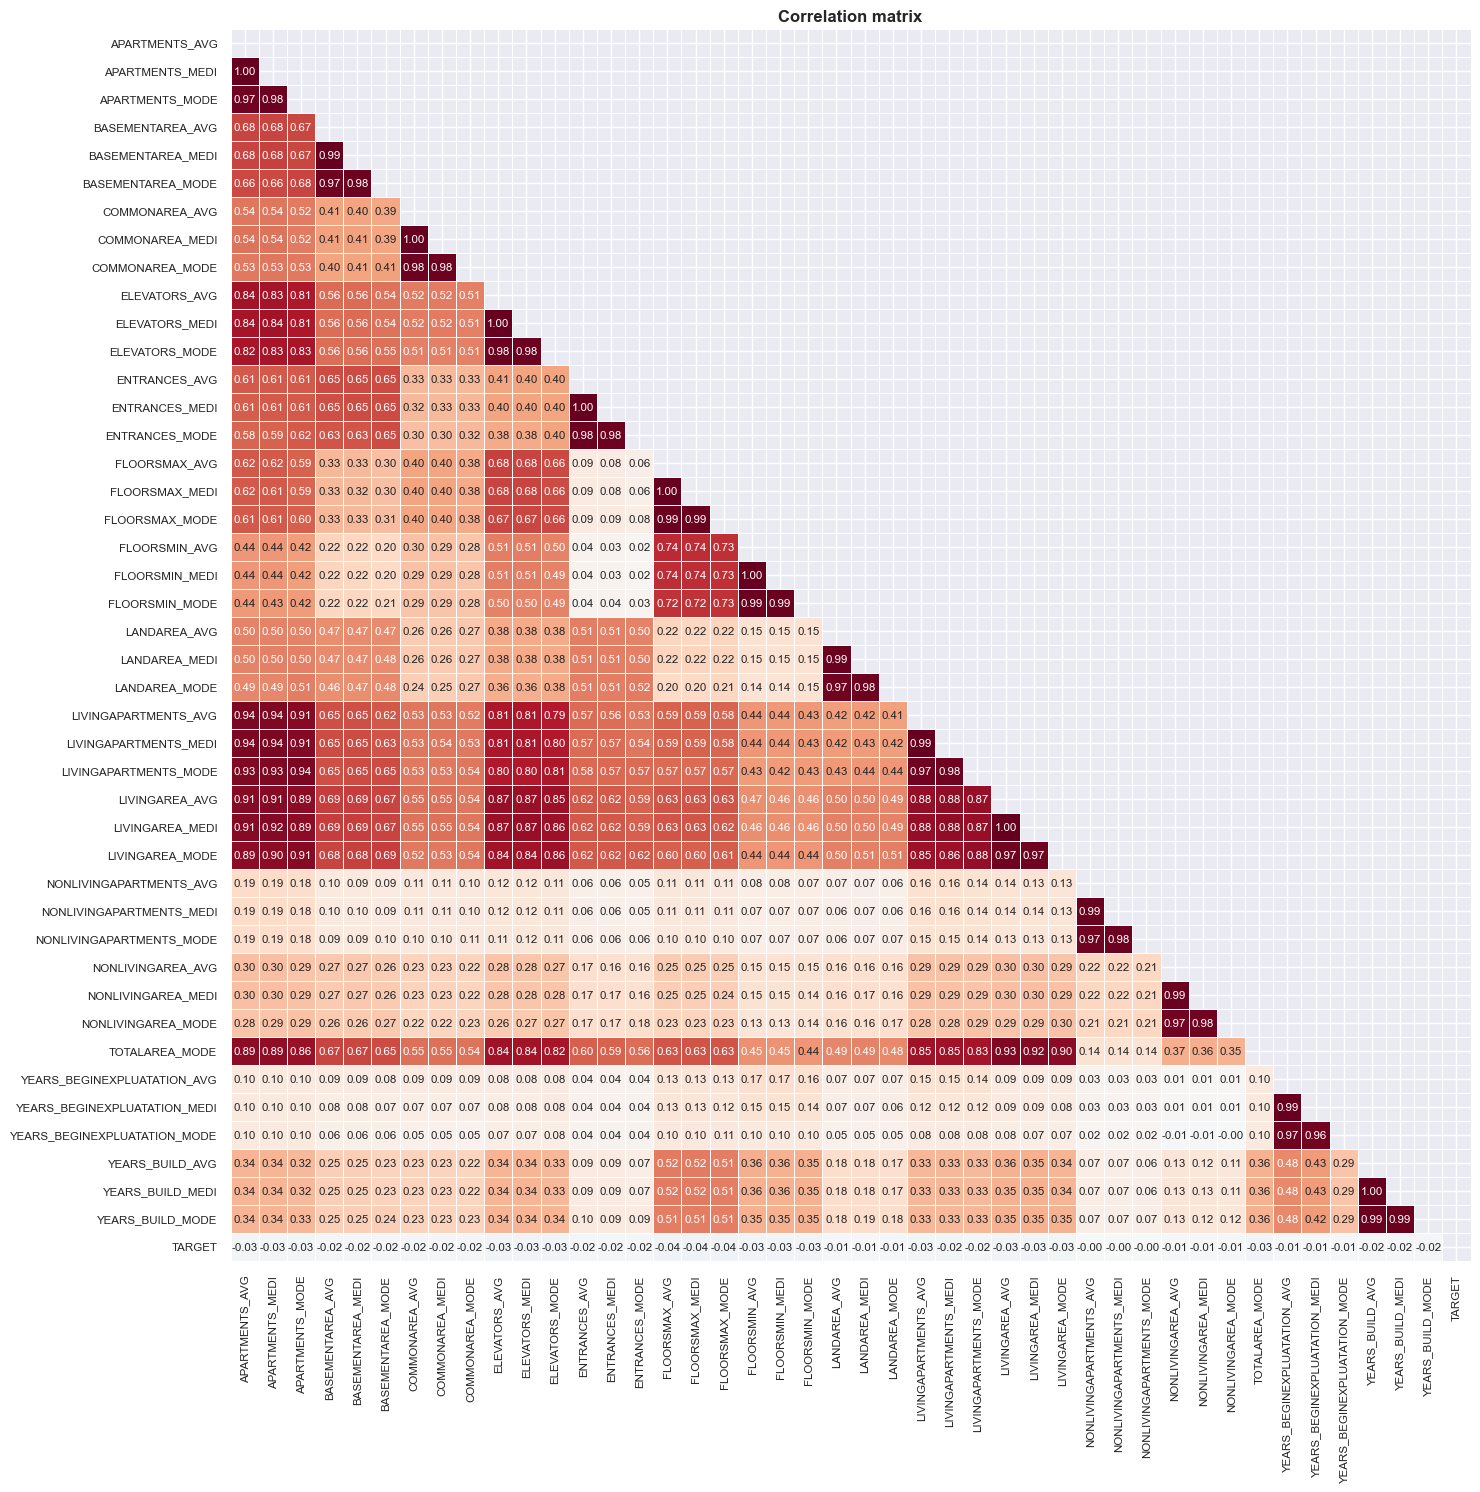

In [67]:
utils.corr_cols(df, feat_housing)

In [68]:
feat_housing_new = ['FLOORSMIN_AVG', 'TOTALAREA_MODE', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 
                    'EMERGENCYSTATE_MODE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE'
                ]

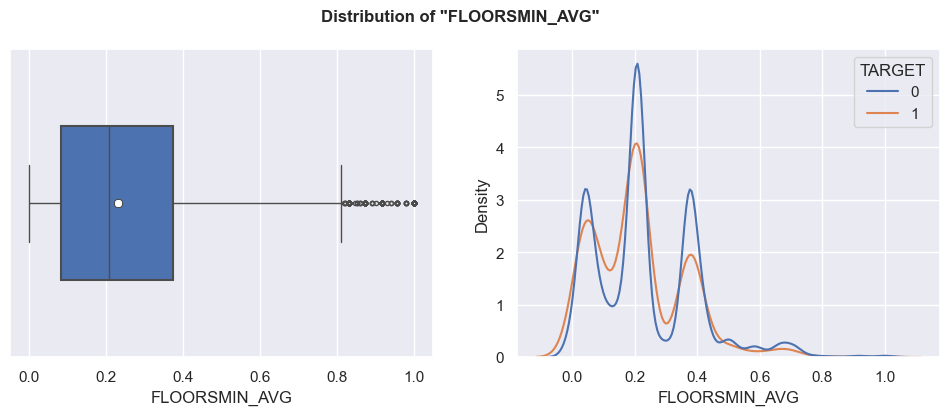

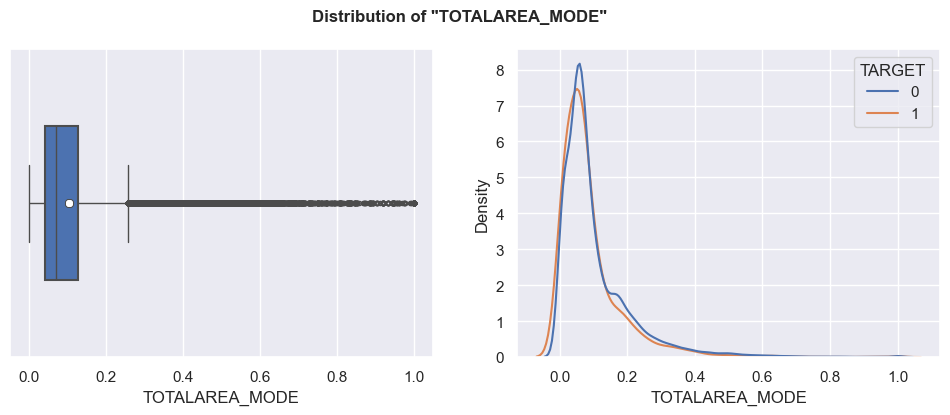

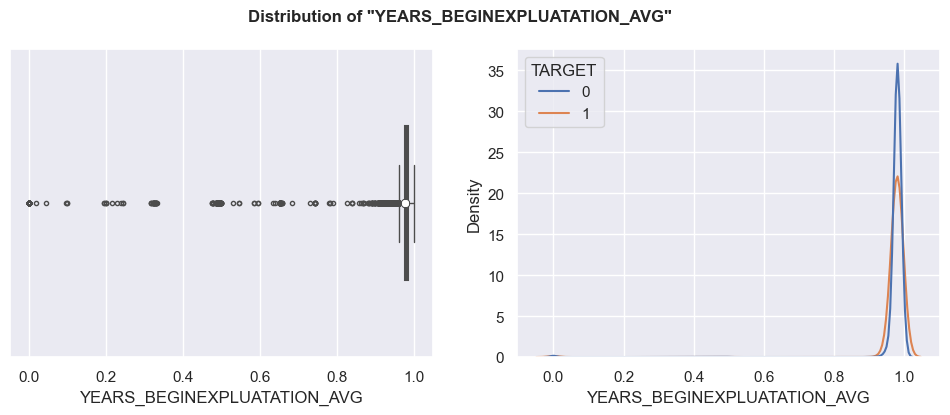

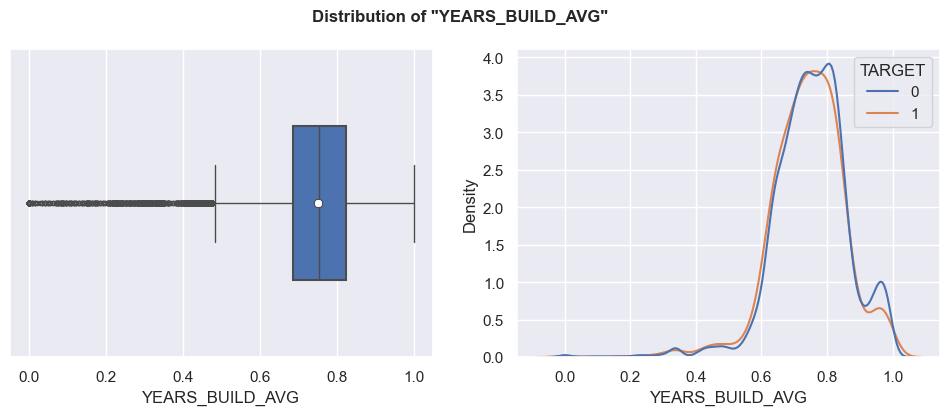

In [69]:
for col in utils.select_vars(df[feat_housing_new], numeric=True, cat_lim=10):
    utils.numvar_plot(df, col)

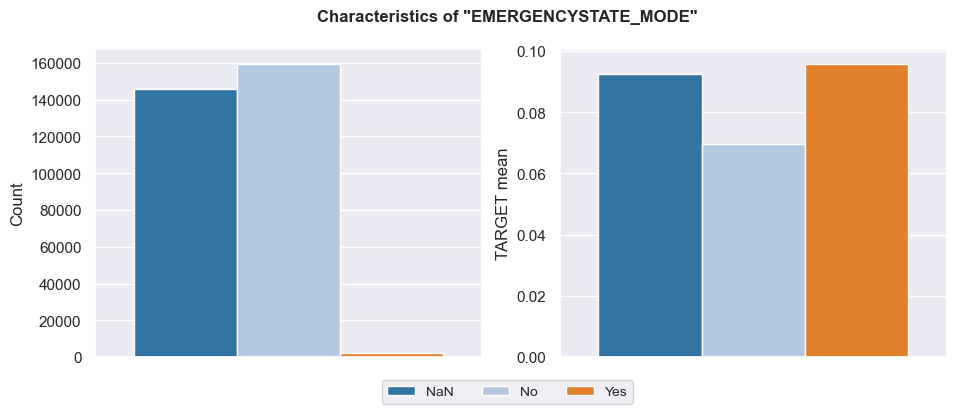

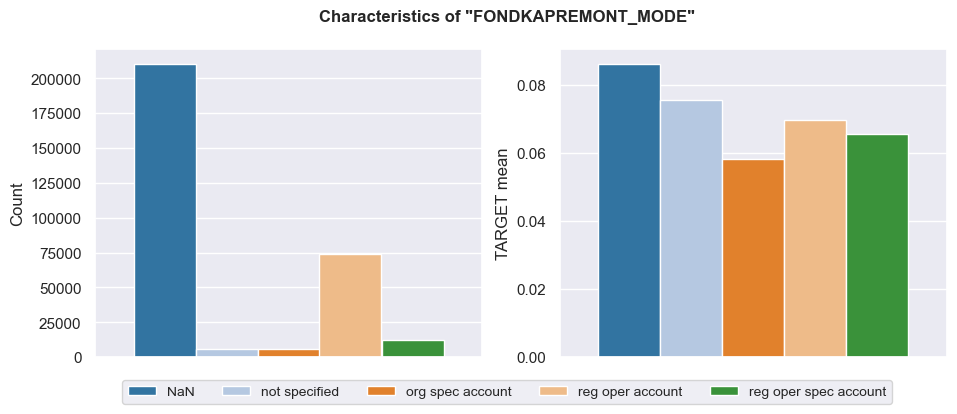

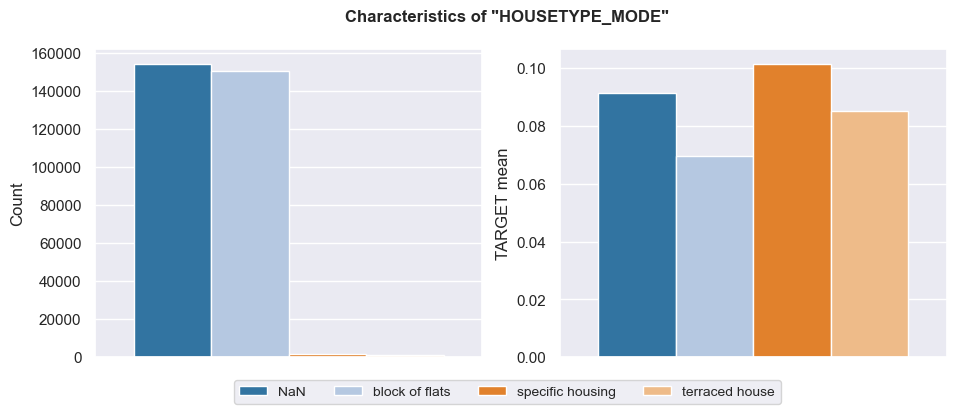

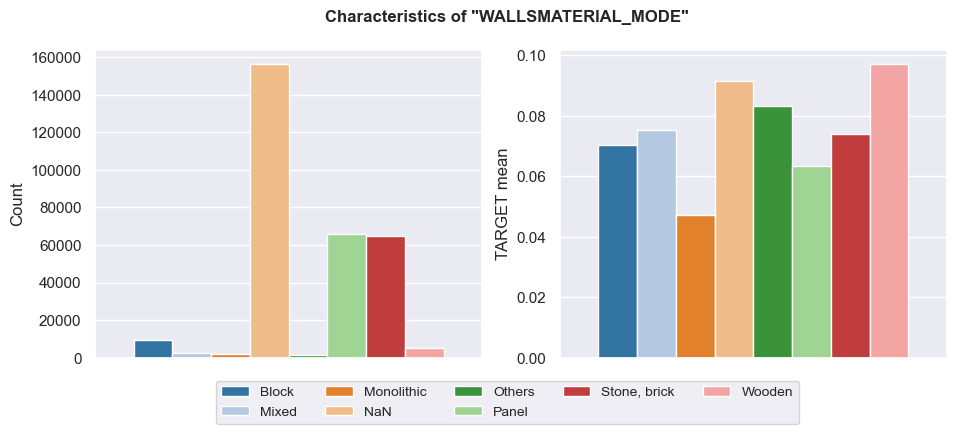

In [70]:
for col in utils.select_vars(df[feat_housing_new], numeric=False, cat_lim=10):
    utils.catvar_plot(df, col)

#### <a id="feat_contacts"></a> Признаки с данными о способах связи *feat_contacts*

Двенадцатая группа переменных составляет шесть признаков-индикаторов, указывающих перечень контактной информации, которую клиент указал при заполнении заявки. Кроме признака *FLAG_MOBIL*, для которого почти у 100% наблюдений указано значение *1*, все переменные включены в модель.

In [71]:
utils.info_ext(df, feat_contacts)

dtype     obs  nulls  nulls_pct
FLAG_CONT_MOBILE  int64  307511      0     0.0000
FLAG_EMAIL        int64  307511      0     0.0000
FLAG_EMP_PHONE    int64  307511      0     0.0000
FLAG_MOBIL        int64  307511      0     0.0000
FLAG_PHONE        int64  307511      0     0.0000
FLAG_WORK_PHONE   int64  307511      0     0.0000

In [72]:
utils.top_unique_values(df[feat_contacts], topvals=2, dropna=False)

Unique values       Top 1      Top 2 Other
FLAG_CONT_MOBILE             2   1 (99.8%)   0 (0.2%)     –
FLAG_EMAIL                   2   0 (94.3%)   1 (5.7%)     –
FLAG_EMP_PHONE               2   1 (82.0%)  0 (18.0%)     –
FLAG_MOBIL                   2  1 (100.0%)   0 (0.0%)     –
FLAG_PHONE                   2   0 (71.9%)  1 (28.1%)     –
FLAG_WORK_PHONE              2   0 (80.1%)  1 (19.9%)     –

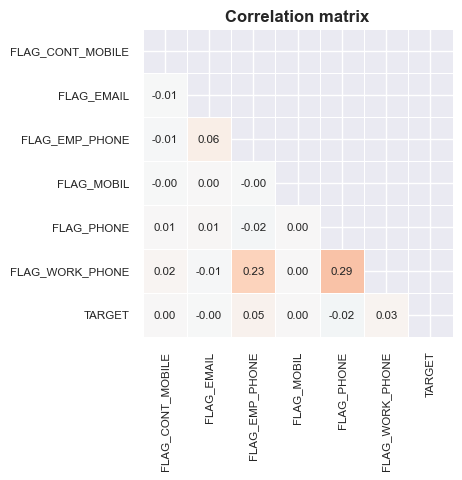

In [73]:
utils.corr_cols(df, feat_contacts)

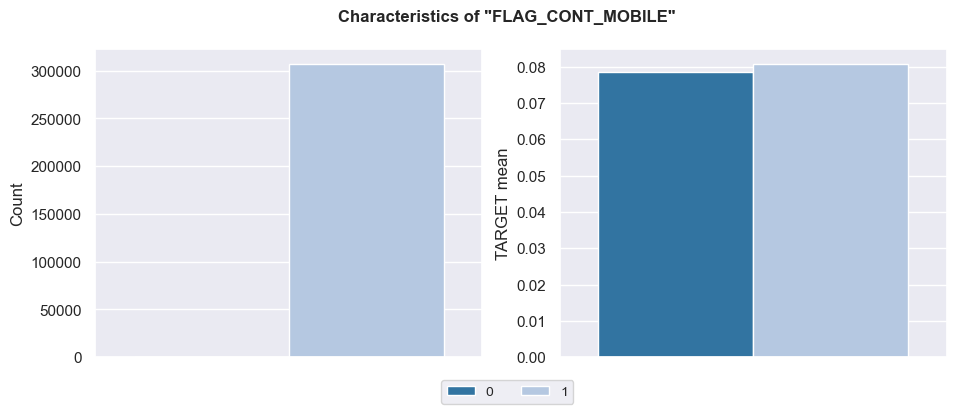

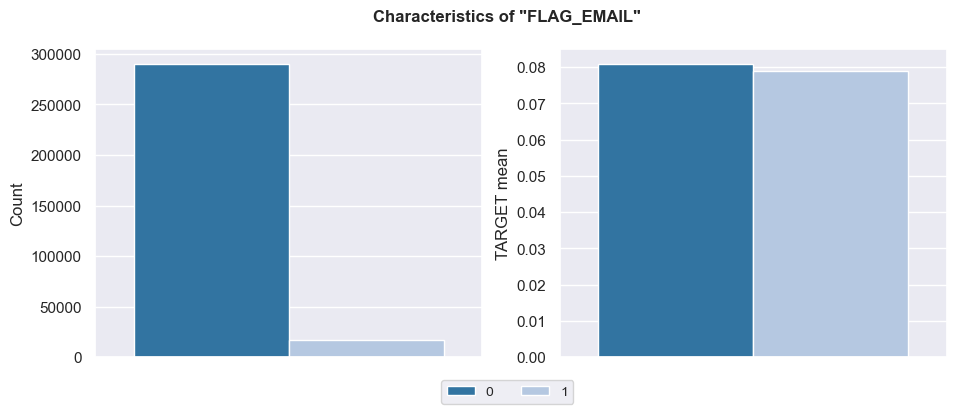

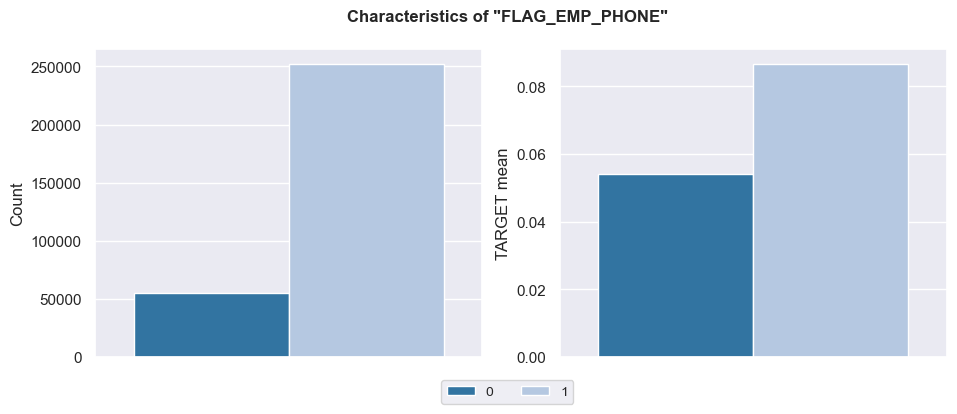

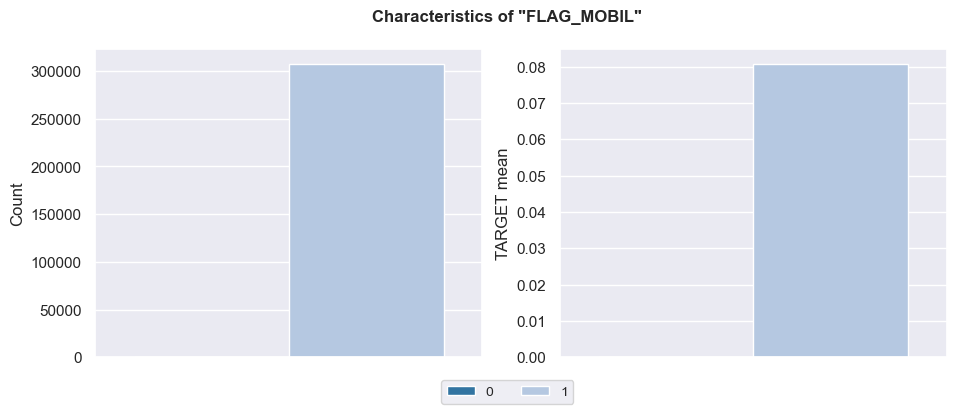

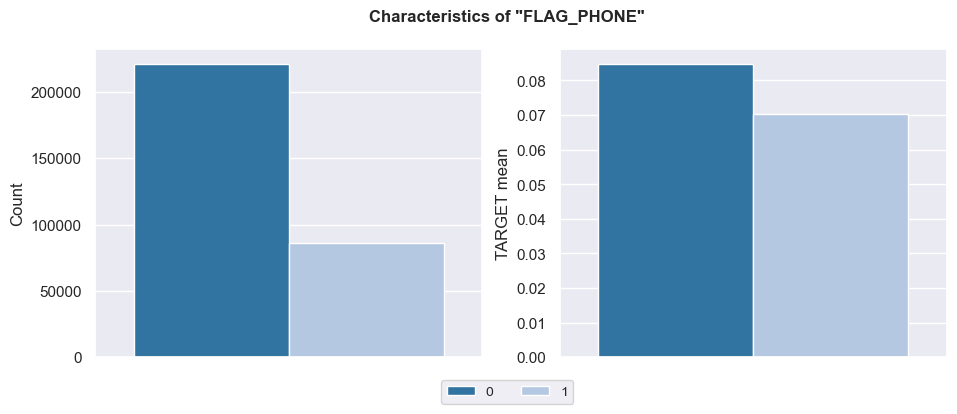

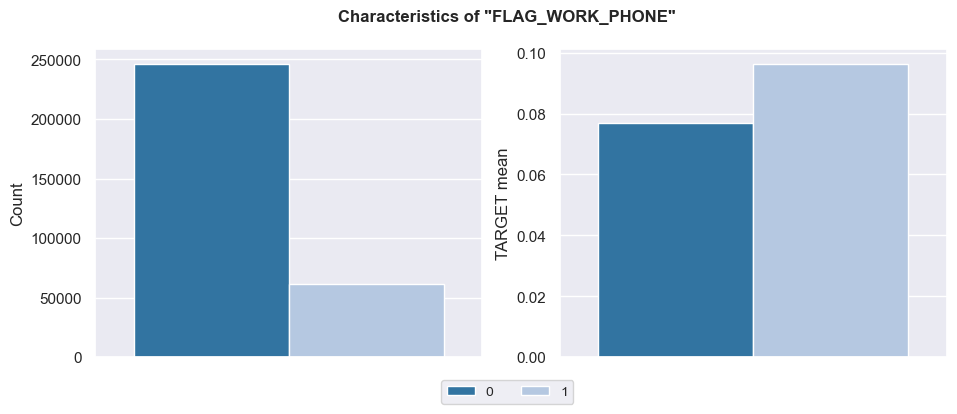

In [74]:
for col in utils.select_vars(df[feat_contacts], numeric=False):
    utils.catvar_plot(df, col)

### <a id="features_1"></a> Отбор и преобразование признаков

По результатам проведенного разведывательного анализа признаков в основной таблице заявок формируется перечень этапов их трансформации для каждой из рассмотренных групп в формате списков кортежей с наименованием шага и параметрами трансформера из модуля *Feature-engine*. Данные списки могут в последующем быть использованы в конструкторе *Pipeline* в экосистеме *sklearn*.

Основные трансформеры, которые были использованы в ходе предобработки данных:
* DropFeatures &mdash; удаление неиспользуемых признаков;
* MeanEncoder &mdash; кодирование категориальных признаков средним значением целевой переменной;
* AddMissingIndicator &mdash; добавление признака-индикатора пропущенных значений;
* MeanMedianImputer &mdash; заполнение пропущенных значений средним/медианным значением;
* RareLabelEncoder &mdash; группировка редковстречаемых категорий в категорию "Прочие";
* ArbitraryOutlierCapper &mdash; замена выбросов выбранным значением;
* CategoricalImputer &mdash; замена пропусков для категориальных признаков;
* OrdinalEncoder &mdash; кодирование категориальных признаков целочисленными значениями;
* ArbitraryNumberImputer &mdash; замена пропущенных значений выбранным числом.

In [75]:
pipelist_feat_loan = [
    ('impute_annuity', MeanMedianImputer(
        variables=['AMT_ANNUITY'], imputation_method='median')),

    ('drop_goods_price', DropFeatures(
        features_to_drop=['AMT_GOODS_PRICE'])),

    ('rare_hours', RareLabelEncoder(
        variables=['HOUR_APPR_PROCESS_START'], 
        tol=0.025, n_categories=10, replace_with='Rare', missing_values='ignore', ignore_format=True)),

    ('encode_dt_attrs', MeanEncoder(
        variables=['HOUR_APPR_PROCESS_START', 'WEEKDAY_APPR_PROCESS_START'], 
        missing_values='ignore', ignore_format=True, unseen='encode', smoothing=0.25)),

    ('encode_cr_type', OrdinalEncoder(
        variables=['NAME_CONTRACT_TYPE'], 
        encoding_method='arbitrary', missing_values='ignore', ignore_format=True, unseen='encode'))
]

pipelist_feat_income = [
    ('cap_income', ArbitraryOutlierCapper(
        max_capping_dict={'AMT_INCOME_TOTAL': 4e6}, missing_values='ignore')),

    ('rare_job_1', RareLabelEncoder(
        variables=['NAME_INCOME_TYPE'], 
        tol=0.025, n_categories=4, replace_with='Rare', missing_values='ignore', ignore_format=True)),

    ('rare_job_2', RareLabelEncoder(
        variables=['OCCUPATION_TYPE', 'ORGANIZATION_TYPE'], 
        tol=0.025, n_categories=8, replace_with='Rare', missing_values='ignore', ignore_format=True)),

    ('impute_job', CategoricalImputer(
        variables=['OCCUPATION_TYPE'], 
        imputation_method='missing', fill_value='Missing', return_object=True, ignore_format=True)),

    ('encode_work', MeanEncoder(
        variables=['NAME_INCOME_TYPE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE'], 
        missing_values='ignore', ignore_format=True, unseen='encode', smoothing=0.25))
]

pipelist_feat_solvency = [
    ('bool_scores', AddMissingIndicator(
        variables=['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3'], missing_only=False)),

    ('impute_scores', MeanMedianImputer(
        variables=['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3'], imputation_method='median')),

    ('drop_dpd_obs', DropFeatures(
        features_to_drop=['DEF_60_CNT_SOCIAL_CIRCLE', 'OBS_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE'])),

    ('bool_dpd_obs', AddMissingIndicator(
        variables=['DEF_30_CNT_SOCIAL_CIRCLE'], missing_only=False)),

    ('impute_dpd_obs', ArbitraryNumberImputer(variables=['DEF_30_CNT_SOCIAL_CIRCLE'], arbitrary_number=-1)),

    ('cap_dpd_obs', ArbitraryOutlierCapper(
        max_capping_dict={'DEF_30_CNT_SOCIAL_CIRCLE': 4}, missing_values='ignore'))
]

pipelist_feat_enquiries = [
    ('drop_enq', DropFeatures(
        features_to_drop=['AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON', 
                          'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR'])),

    ('enq_bool', AddMissingIndicator(
        variables=['AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY'], missing_only=False)),

    ('impute_enq', ArbitraryNumberImputer(
        variables=['AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY'], arbitrary_number=-1)),

    ('cap_enq', ArbitraryOutlierCapper(
        max_capping_dict={'AMT_REQ_CREDIT_BUREAU_HOUR': 1, 'AMT_REQ_CREDIT_BUREAU_DAY': 1}, missing_values='ignore'))
]

pipelist_feat_assets = [
    ('rare_housing', RareLabelEncoder(
        variables=['NAME_HOUSING_TYPE'], 
        tol=0.025, n_categories=3, replace_with='Rare', missing_values='ignore', ignore_format=True)),

    ('encode_housing_sit', MeanEncoder(
        variables=['NAME_HOUSING_TYPE'], 
        missing_values='ignore', ignore_format=True, unseen='encode', smoothing=0.25)),

    ('crop_car_age', ArbitraryOutlierCapper(
        max_capping_dict={'OWN_CAR_AGE': 3*12}, missing_values='ignore')),

    ('bool_car_age', AddMissingIndicator(
        variables=['OWN_CAR_AGE'], missing_only=False)),

    ('impute_car_age', ArbitraryNumberImputer(variables=['OWN_CAR_AGE'], arbitrary_number=-1))
]

pipelist_feat_geosocial = [
    ('drop_region_rating', DropFeatures(features_to_drop=['REGION_RATING_CLIENT']))
]

pipelist_feat_personal = [
    ('impute_gender', CategoricalImputer(
        variables=['CODE_GENDER'], imputation_method='frequent', return_object=True, ignore_format=True)),

    ('encode_gender', OrdinalEncoder(
        variables=['CODE_GENDER'], 
        encoding_method='arbitrary', missing_values='ignore', ignore_format=True, unseen='encode')),

    ('impute_fam_members', MeanMedianImputer(
        variables=['CNT_FAM_MEMBERS'], imputation_method='median')),

    ('cap_fam_members', ArbitraryOutlierCapper(
        max_capping_dict={'CNT_CHILDREN':3, 'CNT_FAM_MEMBERS':5}, missing_values='ignore')),

    ('encode_edu', MeanEncoder(
        variables=['NAME_EDUCATION_TYPE'], 
        missing_values='ignore', ignore_format=True, unseen='encode', smoothing=0.25)),

    ('encode_family_status', MeanEncoder(
        variables=['NAME_FAMILY_STATUS'], 
        missing_values='ignore', ignore_format=True, unseen='encode', smoothing=0.25)),

    ('impute_attend', CategoricalImputer(
        variables=['NAME_TYPE_SUITE'], 
        imputation_method='frequent', return_object=True, ignore_format=True)),

    ('rare_attend', RareLabelEncoder(
        variables=['NAME_TYPE_SUITE'], 
        tol=0.025, n_categories=3, replace_with='Rare', missing_values='ignore', ignore_format=True)),

    ('encode_attend', MeanEncoder(
        variables=['NAME_TYPE_SUITE'], 
        missing_values='ignore', ignore_format=True, unseen='encode', smoothing=0.25))
]

pipelist_feat_events = [
    ('bool_events', AddMissingIndicator(
        variables=['DAYS_EMPLOYED', 'DAYS_ID_PUBLISH', 'DAYS_LAST_PHONE_CHANGE', 'DAYS_REGISTRATION'], 
        missing_only=True)),
    ('impute_events', MeanMedianImputer(
        variables=['DAYS_EMPLOYED', 'DAYS_ID_PUBLISH', 'DAYS_LAST_PHONE_CHANGE', 'DAYS_REGISTRATION'], 
        imputation_method='mean'))
]

pipelist_feat_relocation = [
    ('drop_reloc', DropFeatures(
        features_to_drop=['LIVE_REGION_NOT_WORK_REGION', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION']))
]

pipelist_feat_docs = [
    ('drop_docs', DropFeatures(
        features_to_drop=list(set(feat_docs).difference(feat_docs_new))))
]

pipelist_feat_housing = [
    ('drop_housing', DropFeatures(
        features_to_drop=list(set(feat_housing).difference(feat_housing_new)))),

    ('bool_housing', AddMissingIndicator(
        variables=feat_housing_new, missing_only=True)),

    ('impute_housing_cat', CategoricalImputer(
        variables=['EMERGENCYSTATE_MODE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE'],
        imputation_method='missing', fill_value='Missing', return_object=True, ignore_format=True)),
    
    ('impute_housing_num', MeanMedianImputer(
        variables=['FLOORSMIN_AVG', 'TOTALAREA_MODE', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG'], 
        imputation_method='mean')),

    ('encode_housing', MeanEncoder(
        variables=['EMERGENCYSTATE_MODE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE'], 
        missing_values='ignore', ignore_format=True, unseen='encode', smoothing=0.25))
]

pipelist_feat_contacts = [
    ('drop_contacts', DropFeatures(
        features_to_drop=['FLAG_MOBIL']))
]

In [76]:
pipelist_feat_preproc = (pipelist_feat_loan 
                         + pipelist_feat_income 
                         + pipelist_feat_solvency 
                         + pipelist_feat_enquiries
                         + pipelist_feat_assets
                         + pipelist_feat_geosocial
                         + pipelist_feat_personal
                         + pipelist_feat_events
                         + pipelist_feat_relocation
                         + pipelist_feat_docs
                         + pipelist_feat_housing
                         + pipelist_feat_contacts
)
col_list = (feat_loan 
            + feat_income 
            + feat_solvency 
            + feat_enquiries
            + feat_assets
            + feat_geosocial
            + feat_personal
            + feat_events
            + feat_relocation
            + feat_docs
            + feat_housing
            + feat_contacts
)

### <a id="default_model"></a> Базовая модель

С имеющимся набором переменных в основной таблице (без учета новых расчетных) можно создать модель, которая будет выступать в качестве базовой. Ее результаты будут использоваться в дальнейшем для оценки улучшения качества прогноза по мере включения дополнительных, более информативных признаков. Базовая модель создана с помощью классификатора в составе *XGBoost* с использованием настроек, близких к дефолтным. Качество модели оценивается с помощью среднего значения метрики *AUC ROC*, полученного с помощью кросс-валидации на пяти фолдах. Для обученной модели также рассчитывается важность каждого из используемых признаков, как средний показатель прироста информации для всех промежуточных вершинах, в которых он участвует.

Базовая модель рассчитывается в двух вариантах: с минимальным набором признаков (группы признаков в *feat_loan*, *feat_income* и *feat_solvency*) и всеми признаками, доступными в основной таблице. В первом случае значение метрики *AUC ROC* по результатам кросс-валидации составляет ~0.74; включение в модель всех признаков увеличивает точность модели до ~0.75. Таким образом, даже без использования информации в смежных таблицах, содержащих детальную информацию о поведении клиента в прошлом, базовая модель позволяет достичь приемлемой, но не оптимальной, точности. Стоит отметить, что для обоих базовых моделей главными информативными признаками являются расчетные показатели кредитоспособности *EXT_SOURCE_3* и *EXT_SOURCE_2*, полученные от внешних источников. В идеале, использую информацию в смежных таблицах, необходимо спроектировать новые признаки, которые будут иметь сопоставимую объясняющую силу, как и указанные расчетные показатели, что должно позволить увеличить точность модели до ~0.80 (в идеальном сценарии).

In [77]:
# Cross-validation mean AUC ROC: 0.7413 (0.7357-0.7478)
feat_imp_1 = utils.default_model_cv(
    pipelist_feat_loan + pipelist_feat_income + pipelist_feat_solvency, 
    X=df[feat_loan + feat_income + feat_solvency], 
    y=df['TARGET']
)

pd.concat([feat_imp_1.head(), feat_imp_1.tail()])

Cross-validation mean AUC ROC: 0.7413 (0.7357-0.7478)


features  importance
0                  EXT_SOURCE_3     21.9858
1                  EXT_SOURCE_2     17.5646
2                  EXT_SOURCE_1      8.1145
3            NAME_CONTRACT_TYPE      7.9644
4              NAME_INCOME_TYPE      7.3369
12             AMT_INCOME_TOTAL      2.0998
13      HOUR_APPR_PROCESS_START      1.9597
14   WEEKDAY_APPR_PROCESS_START      1.6862
15              EXT_SOURCE_2_na      1.5199
16  DEF_30_CNT_SOCIAL_CIRCLE_na      0.0000

In [78]:
# Cross-validation mean AUC ROC: 0.7533 (0.7475-0.7600)
feat_imp_2 = utils.default_model_cv(
    pipelist_feat_preproc, 
    X=df[col_list], 
    y=df['TARGET']
)

pd.concat([feat_imp_2.head(), feat_imp_2.tail()])

Cross-validation mean AUC ROC: 0.7533 (0.7475-0.7600)


features  importance
0                     EXT_SOURCE_3      9.2768
1                     EXT_SOURCE_2      8.8414
2                     FLAG_OWN_CAR      5.2830
3              NAME_EDUCATION_TYPE      5.2729
4                      CODE_GENDER      4.2229
63  YEARS_BEGINEXPLUATATION_AVG_na      0.0000
64          EMERGENCYSTATE_MODE_na      0.0000
65           FONDKAPREMONT_MODE_na      0.0000
66               HOUSETYPE_MODE_na      0.0000
67           WALLSMATERIAL_MODE_na      0.0000

## <a id="joined_tables"></a> Вспомогательные таблицы с кредитной историей

### <a id="tbl_bureau"></a> Описательный анализ и отбор признаков в таблице *bureau*

В таблице *bureau* содержится информация о прошлых и текущих кредитах, оформленных клиентами, которая получена от кредитных бюро. Из 307 511 записей в основной таблице у порядка 14% отсутствуют корреспондирующие записи (отсутствует кредитная история). Данные в таблице имеют значительное количество пропусков для важных признаков (размер обязательного платежа - *AMT_ANNUITY*, максимальный размер задолженности по кредиту - *AMT_CREDIT_MAX_OVERDUE*). Отчасти это связано с тем, что данные в таблице относятся к разным типам кредитов и для некоторых признаки к ним не применимы. С другой стороны, отсутствие данных связано с качеством данных, получаемых от источников информации.

На основе данных в таблице спроектированы следующие признаки:
* **CB_HAS_MORTAGE** &mdash; признак-индикатор, если у клиента есть действующий ипотечный кредит;
* **CB_HAS_CARLOAN** &mdash; признак-индикатор, если у клиента есть действующий кредит на покупку автомобиля;
* **CB_HAS_CC** &mdash; количество действующих кредитных карт у клиента;
* **CB_ACT_LOANS_CNT** &mdash; количество действующих кредитных договоров;
* **CB_ACT_LOANS_AVG** &mdash; средний размер действующих кредитов;
* **CB_ACT_LOANS_SUM** &mdash; общий размер действующих кредитов;
* **CB_PST_LOANS_CNT** &mdash; количество прошлых кредитных договоров;
* **CB_PST_LOANS_AVG** &mdash; средний размер прошлых кредитов;
* **CB_PST_LOANS_SUM** &mdash; общий размер прошлых кредитов;
* **CB_LOANS_CNT_RATIO** &mdash; соотношение количества активных кредитов к прошлым;
* **CB_LOANS_AVG_RATIO** &mdash; соотношение среднего размера активных кредитов к прошлым;
* **CB_LOANS_SUM_RATIO** &mdash; соотношение общей суммы по активным кредитам к сумме прошлых.

К прошлым кредитам относятся кредиты, которые были заключены в течении пяти лет до даты подачи текущей заявки на кредит.

In [79]:
df_tmp = conx.execute("select * from bureau").fetch_df()

In [80]:
conx.execute(f"""
    select count(*) as missing_ids 
    from application_train as a
    left join bureau as b on a.sk_id_curr = b.sk_id_curr 
    where b.sk_id_curr is null
""").fetch_df()

missing_ids
0        44020

In [81]:
conx.execute(f"""
    select b.credit_type, count(*) as cnt, avg(target) as target_avr 
    from bureau as b
    join application_train as a on b.sk_id_curr = a.sk_id_curr 
    group by b.credit_type
    order by 2 desc
""").fetch_df()

CREDIT_TYPE      cnt  target_avr
0                                Consumer credit  1069610      0.0748
1                                    Credit card   343853      0.0880
2                                       Car loan    23757      0.0557
3                                       Mortgage    15607      0.0500
4                                      Microloan     9005      0.2064
5                  Loan for business development     1721      0.0616
6                           Another type of loan      854      0.0714
7                           Unknown type of loan      472      0.0614
8         Loan for working capital replenishment      377      0.1273
9                               Real estate loan       23      0.0000
10                     Cash loan (non-earmarked)       23      0.0435
11            Loan for the purchase of equipment       17      0.2353
12  Loan for purchase of shares (margin lending)        4      0.0000
13                          Mobile operator loan        1      0.0000
14                              Interbank credit        1      0.0000

In [82]:
conx.execute(f"""
    select b.credit_active, count(*) as cnt, avg(target) as target_avr 
    from bureau as b
    join application_train as a on b.sk_id_curr = a.sk_id_curr 
    group by b.credit_active
    order by 2 desc
""").fetch_df()

CREDIT_ACTIVE     cnt  target_avr
0        Closed  917733      0.0693
1        Active  541919      0.0929
2          Sold    5653      0.1010
3      Bad debt      20      0.2000

In [83]:
utils.info_ext(df_tmp, df_tmp.columns)

dtype      obs    nulls  nulls_pct
SK_ID_CURR                int64  1716428        0     0.0000
SK_ID_BUREAU              int64  1716428        0     0.0000
CREDIT_ACTIVE            object  1716428        0     0.0000
CREDIT_CURRENCY          object  1716428        0     0.0000
DAYS_CREDIT               int64  1716428        0     0.0000
CREDIT_DAY_OVERDUE        int64  1716428        0     0.0000
DAYS_CREDIT_ENDDATE     float64  1610875   105553     0.0615
DAYS_ENDDATE_FACT       float64  1082775   633653     0.3692
AMT_CREDIT_MAX_OVERDUE  float64   591940  1124488     0.6551
CNT_CREDIT_PROLONG        int64  1716428        0     0.0000
AMT_CREDIT_SUM          float64  1716415       13     0.0000
AMT_CREDIT_SUM_DEBT     float64  1458759   257669     0.1501
AMT_CREDIT_SUM_LIMIT    float64  1124648   591780     0.3448
AMT_CREDIT_SUM_OVERDUE  float64  1716428        0     0.0000
CREDIT_TYPE              object  1716428        0     0.0000
DAYS_CREDIT_UPDATE        int64  1716428        0     0.0000
AMT_ANNUITY             float64   489637  1226791     0.7147

In [84]:
pd.concat([df_tmp.head(3), df_tmp.tail(3)])

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0            215354       5714462        Closed      currency 1         -497   
1            215354       5714463        Active      currency 1         -208   
2            215354       5714464        Active      currency 1         -203   
1716425      100044       5057762        Closed      currency 1        -1809   
1716426      246829       5057770        Closed      currency 1        -1878   
1716427      246829       5057778        Closed      currency 1         -463   

         CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                         0            -153.0000          -153.0000   
1                         0           1,075.0000                NaN   
2                         0             528.0000                NaN   
1716425                   0          -1,628.0000          -970.0000   
1716426                   0          -1,513.0000        -1,513.0000   
1716427                   0                  NaN          -387.0000   

         AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                           NaN                   0     91,323.0000   
1                           NaN                   0    225,000.0000   
2                           NaN                   0    464,323.5000   
1716425                     NaN                   0     15,570.0000   
1716426                     NaN                   0     36,000.0000   
1716427                     NaN                   0     22,500.0000   

         AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0                     0.0000                   NaN                  0.0000   
1               171,342.0000                   NaN                  0.0000   
2                        NaN                   NaN                  0.0000   
1716425                  NaN                   NaN                  0.0000   
1716426               0.0000                0.0000                  0.0000   
1716427               0.0000                   NaN                  0.0000   

             CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0        Consumer credit                -131          NaN  
1            Credit card                 -20          NaN  
2        Consumer credit                 -16          NaN  
1716425  Consumer credit                -967          NaN  
1716426  Consumer credit               -1508          NaN  
1716427        Microloan                -387          NaN

### <a id="tbl_bureau_balance"></a> Описательный анализ и отбор признаков в таблице *bureau_balance*

В таблице *bureau_balance* содержится помесячные сведения о платежах клиентов по кредитам в рамках утвержденных платежных календарей. Для каждого месяца, относительно месяца подачи текущей заявки, указывается, информации о просрочке (0 - вовремя, 1-5 просрочка от 1 до 120 дней, C - кредит закрыт, X - отсутствие информации). Для примера показана информация для *SK_ID_BUREAU* = 6274029, когда в месяц подачи заявки допущена просрочка платежа (*DPD*) от 1 до 30 дней.


На основе данных в таблице спроектированы следующие признаки:
* **CB_DPD_FIRST_CNT** &mdash; среднее количество раз, когда была допущена просрочка по кредиту в первые 12 платежных периодов, по всем кредитам клиента;
* **CB_DPD_FIRST_SUM** &mdash; средняя сумма индикаторов, характеризующих длину просрочки (от 1 до 5), когда была допущена просрочка по кредиту в первые 12 платежных периодов, по всем кредитам клиента;
* **CB_DPD_LAST_CNT** &mdash; среднее количество раз, когда была допущена просрочка по кредиту в последние 12 платежных периодов, по всем кредитам клиента
* **CB_DPD_LAST_SUM** &mdash; средняя сумма индикаторов, характеризующих длину просрочки (от 1 до 5), когда была допущена просрочка по кредиту в последние 12 платежных периодов, по всем кредитам клиента;

К прошлым кредитам относятся кредиты, которые были заключены в течении пяти лет до даты подачи текущей заявки на кредит.

In [85]:
df_tmp = conx.execute("select * from bureau_balance").fetch_df()
utils.info_ext(df_tmp, df_tmp.columns)

dtype       obs  nulls  nulls_pct
SK_ID_BUREAU     int64  27299925      0     0.0000
MONTHS_BALANCE   int64  27299925      0     0.0000
STATUS          object  27299925      0     0.0000

In [86]:
conx.execute(f"select * from bureau_balance where sk_id_bureau = 6274029").fetch_df()

SK_ID_BUREAU  MONTHS_BALANCE STATUS
0       6274029               0      1
1       6274029              -1      0
2       6274029              -2      0
3       6274029              -3      0
4       6274029              -4      0
5       6274029              -5      X

### <a id="tbl_previous_application"></a> Описательный анализ и отбор признаков в таблице *previous_application*

В таблице *previous_application* содержится информация о предыдущих заявках клиентов на получение кредитов, включая информацию, схожую с той, которая содержится в основной таблице. Для заявок, которые были одобрены в прошлом (около 62% из 1,7 млн.), в связанных таблицах - в зависимости от вида кредита - присутствует информация о ежемесячных платежах.

На основе данных в таблице спроектированы следующие признаки:
* **PA_LOANS_APP_PCT** &mdash; доля кредитов, которая была ободрена;
* **PA_LOANS_REF_PCT** &mdash; доля кредитов, которая была не была ободрена;
* **PA_LOANS_UNU_PCT** &mdash; доля кредитов, которая была не была использована;
* **PA_LOANS_APP_AVG** &mdash; средний размер одобренных кредитов;
* **PA_LOANS_REF_AVG** &mdash; средний размер неодобренных кредитов;
* **PA_LOANS_UNU_AVG** &mdash; средний размер неиспользованных кредитов;
* **PA_LOANS_APP_SUM** &mdash; сумма одобренных кредитов;
* **PA_LOANS_REF_SUM** &mdash; сумма неодобренных кредитов;
* **PA_LOANS_UNU_SUM** &mdash; сумма неиспользованных кредитов;
* **PA_DAYS_DECISION_MAX** &mdash; количество дней, прошедших с момента подачи последней заявки;
* **PA_INSURED_AVG** &mdash; доля одобренных кредитов, на которые была оформлена страховка;
* **PA_LOANS_TERM_AVG** &mdash; средний срок одобренных кредитов (без учета кредитных карт);
* **PA_LOANS_TERM_MAX** &mdash; максимальный одобренных кредитов (без учета кредитных карт);
* **PA_PCT_RISK_AVG** &mdash; расчетная оценка среднего уровня риска для кредитов клиента;
* **PA_ACT_LOANS_CNT** &mdash; количество действующих кредитов в прошлых заявках;
* **PA_ACT_LOANS_AVG** &mdash; средний размер действующих кредитов в прошлых заявках;
* **PA_ACT_LOANS_SUM** &mdash; сумма действующих кредитов в прошлых заявках;
* **PA_ACT_LOANS_ANN_SUM** &mdash; сумма платежей по действующим кредитам в прошлых заявках;
* **AMT_ANN_INC_RATIO** &mdash; сумма переменных *AMT_ANNUITY* в основной таблице и *PA_ACT_LOANS_ANN_SUM*, указанной выше, к общему доходу клиента (*AMT_INCOME_TOTAL* в основной таблице).

In [87]:
df_tmp = conx.execute("select * from previous_application").fetch_df()

In [88]:
conx.execute(f"""
    select name_portfolio, count(*) as cnt
    from previous_application
    group by name_portfolio
    order by 2 desc
""").fetch_df()

NAME_PORTFOLIO     cnt
0            POS  691011
1           Cash  461563
2            XNA  372230
3          Cards  144985
4           Cars     425

In [89]:
conx.execute(f"""
    select name_contract_status, count(*) as cnt
    from previous_application
    group by name_contract_status
    order by 2 desc
""").fetch_df()

NAME_CONTRACT_STATUS      cnt
0             Approved  1036781
1             Canceled   316319
2              Refused   290678
3         Unused offer    26436

In [90]:
utils.info_ext(df_tmp, df_tmp.columns)

dtype      obs    nulls  nulls_pct
SK_ID_PREV                     int64  1670214        0     0.0000
SK_ID_CURR                     int64  1670214        0     0.0000
NAME_CONTRACT_TYPE            object  1670214        0     0.0000
AMT_ANNUITY                  float64  1297979   372235     0.2229
AMT_APPLICATION              float64  1670214        0     0.0000
AMT_CREDIT                   float64  1670213        1     0.0000
AMT_DOWN_PAYMENT             float64   774370   895844     0.5364
AMT_GOODS_PRICE              float64  1284699   385515     0.2308
WEEKDAY_APPR_PROCESS_START    object  1670214        0     0.0000
HOUR_APPR_PROCESS_START        int64  1670214        0     0.0000
FLAG_LAST_APPL_PER_CONTRACT   object  1670214        0     0.0000
NFLAG_LAST_APPL_IN_DAY         int64  1670214        0     0.0000
RATE_DOWN_PAYMENT            float64   774370   895844     0.5364
RATE_INTEREST_PRIMARY        float64     5951  1664263     0.9964
RATE_INTEREST_PRIVILEGED     float64     5951  1664263     0.9964
NAME_CASH_LOAN_PURPOSE        object  1670214        0     0.0000
NAME_CONTRACT_STATUS          object  1670214        0     0.0000
DAYS_DECISION                  int64  1670214        0     0.0000
NAME_PAYMENT_TYPE             object  1670214        0     0.0000
CODE_REJECT_REASON            object  1670214        0     0.0000
NAME_TYPE_SUITE               object   849809   820405     0.4912
NAME_CLIENT_TYPE              object  1670214        0     0.0000
NAME_GOODS_CATEGORY           object  1670214        0     0.0000
NAME_PORTFOLIO                object  1670214        0     0.0000
NAME_PRODUCT_TYPE             object  1670214        0     0.0000
CHANNEL_TYPE                  object  1670214        0     0.0000
SELLERPLACE_AREA               int64  1670214        0     0.0000
NAME_SELLER_INDUSTRY          object  1670214        0     0.0000
CNT_PAYMENT                  float64  1297984   372230     0.2229
NAME_YIELD_GROUP              object  1670214        0     0.0000
PRODUCT_COMBINATION           object  1669868      346     0.0002
DAYS_FIRST_DRAWING           float64   997149   673065     0.4030
DAYS_FIRST_DUE               float64   997149   673065     0.4030
DAYS_LAST_DUE_1ST_VERSION    float64   997149   673065     0.4030
DAYS_LAST_DUE                float64   997149   673065     0.4030
DAYS_TERMINATION             float64   997149   673065     0.4030
NFLAG_INSURED_ON_APPROVAL    float64   997149   673065     0.4030

In [91]:
utils.top_unique_values(df_tmp, topvals=4, dropna=False)

Unique values                            Top 1  \
SK_ID_PREV                        1670214                   2030495 (0.0%)   
SK_ID_CURR                         338857                    187868 (0.0%)   
NAME_CONTRACT_TYPE                      4               Cash loans (44.8%)   
AMT_ANNUITY                        357960                      nan (22.3%)   
AMT_APPLICATION                     93885                      0.0 (23.5%)   
AMT_CREDIT                          86804                      0.0 (20.2%)   
AMT_DOWN_PAYMENT                    29279                      nan (53.6%)   
AMT_GOODS_PRICE                     93886                      nan (23.1%)   
WEEKDAY_APPR_PROCESS_START              7                  TUESDAY (15.3%)   
HOUR_APPR_PROCESS_START                24                       11 (11.5%)   
FLAG_LAST_APPL_PER_CONTRACT             2                        Y (99.5%)   
NFLAG_LAST_APPL_IN_DAY                  2                        1 (99.6%)   
RATE_DOWN_PAYMENT                  207034                      nan (53.6%)   
RATE_INTEREST_PRIMARY                 149                      nan (99.6%)   
RATE_INTEREST_PRIVILEGED               26                      nan (99.6%)   
NAME_CASH_LOAN_PURPOSE                 25                      XAP (55.2%)   
NAME_CONTRACT_STATUS                    4                 Approved (62.1%)   
DAYS_DECISION                        2922                      -245 (0.1%)   
NAME_PAYMENT_TYPE                       4    Cash through the bank (61.9%)   
CODE_REJECT_REASON                      9                      XAP (81.0%)   
NAME_TYPE_SUITE                         8                     None (49.1%)   
NAME_CLIENT_TYPE                        4                 Repeater (73.7%)   
NAME_GOODS_CATEGORY                    28                      XNA (56.9%)   
NAME_PORTFOLIO                          5                      POS (41.4%)   
NAME_PRODUCT_TYPE                       3                      XNA (63.7%)   
CHANNEL_TYPE                            8  Credit and cash offices (43.1%)   
SELLERPLACE_AREA                     2097                       -1 (45.7%)   
NAME_SELLER_INDUSTRY                   11                      XNA (51.2%)   
CNT_PAYMENT                            50                      nan (22.3%)   
NAME_YIELD_GROUP                        5                      XNA (31.0%)   
PRODUCT_COMBINATION                    18                     Cash (17.1%)   
DAYS_FIRST_DRAWING                   2839                 365243.0 (55.9%)   
DAYS_FIRST_DUE                       2893                      nan (40.3%)   
DAYS_LAST_DUE_1ST_VERSION            4606                      nan (40.3%)   
DAYS_LAST_DUE                        2874                      nan (40.3%)   
DAYS_TERMINATION                     2831                      nan (40.3%)   
NFLAG_INSURED_ON_APPROVAL               3                      nan (40.3%)   

                                                           Top 2  \
SK_ID_PREV                                        1035848 (0.0%)   
SK_ID_CURR                                         265681 (0.0%)   
NAME_CONTRACT_TYPE                        Consumer loans (43.7%)   
AMT_ANNUITY                                        2250.0 (1.9%)   
AMT_APPLICATION                                   45000.0 (2.9%)   
AMT_CREDIT                                        45000.0 (2.1%)   
AMT_DOWN_PAYMENT                                     0.0 (22.1%)   
AMT_GOODS_PRICE                                   45000.0 (2.9%)   
WEEKDAY_APPR_PROCESS_START                     WEDNESDAY (15.3%)   
HOUR_APPR_PROCESS_START                               12 (11.1%)   
FLAG_LAST_APPL_PER_CONTRACT                             N (0.5%)   
NFLAG_LAST_APPL_IN_DAY                                  0 (0.4%)   
RATE_DOWN_PAYMENT                                    0.0 (22.1%)   
RATE_INTEREST_PRIMARY                  0.1891363481808909 (0.1%)   
RATE_INTEREST_PRIVILEGED               0.83

### <a id="tbl_installments_payments"></a> Описательный анализ и отбор признаков в таблице *installments_payments*

В таблице *installments_payments* содержится информация о каждом из платежей по кредиту с указанием отклонений в сроках и размере платежа. Для примера показана информация для *SK_ID_PREV* = 2532469, где для первого платежа произведено два оплаты, последняя из которых была после даты, установленной в платежном календаре.

На основе данных в таблице спроектированы следующие признаки:
* **IP_LOANS_DAYS_LATE_AVG** &mdash; среднее количество дней просрочки/аванса по кредитным платежам;
* **IP_CC_DAYS_LATE_AVG** &mdash; среднее количество дней просрочки/аванса по платежам по кредитным картам;
* **IP_LOANS_DPD** &mdash; среднее количество раз, когда была допущена просрочка по кредитным платежам;
* **IP_CC_DPD** &mdash; среднее количество раз, когда была допущена просрочка по платежам по кредитным картам.

In [92]:
df_tmp = conx.execute("select * from installments_payments").fetch_df()
utils.info_ext(df_tmp, df_tmp.columns)

dtype       obs  nulls  nulls_pct
SK_ID_PREV                int64  13605401      0     0.0000
SK_ID_CURR                int64  13605401      0     0.0000
NUM_INSTALMENT_VERSION  float64  13605401      0     0.0000
NUM_INSTALMENT_NUMBER     int64  13605401      0     0.0000
DAYS_INSTALMENT         float64  13605401      0     0.0000
DAYS_ENTRY_PAYMENT      float64  13602496   2905     0.0002
AMT_INSTALMENT          float64  13605401      0     0.0000
AMT_PAYMENT             float64  13602496   2905     0.0002

In [93]:
conx.execute(f"""
    select * from installments_payments
    where sk_id_prev = 2532469
    order by num_instalment_number
""").fetch_df()

SK_ID_PREV  SK_ID_CURR  NUM_INSTALMENT_VERSION  NUM_INSTALMENT_NUMBER  \
0     2532469      132543                  1.0000                      1   
1     2532469      132543                  1.0000                      1   
2     2532469      132543                  1.0000                      2   
3     2532469      132543                  1.0000                      3   
4     2532469      132543                  1.0000                      4   
5     2532469      132543                  1.0000                      5   
6     2532469      132543                  1.0000                      6   
7     2532469      132543                  2.0000                      7   

   DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  AMT_INSTALMENT  AMT_PAYMENT  
0        -439.0000           -435.0000     14,801.9850   4,149.8550  
1        -439.0000           -454.0000     14,801.9850  10,652.1300  
2        -409.0000           -424.0000     14,801.9850  14,801.9850  
3        -379.0000           -392.0000     14,801.9850  14,801.9850  
4        -349.0000           -392.0000     14,801.9850  14,801.9850  
5        -319.0000           -343.0000     14,801.9850  14,801.9850  
6        -289.0000           -323.0000     14,801.9850  14,801.9850  
7        -259.0000           -264.0000     77,300.8650  77,300.8650

### <a id="tbl_pos_cash_balance"></a> Описательный анализ и отбор признаков в таблице *pos_cash_balance*

В таблице *pos_cash_balance* содержится информация о длине просрочки по каждому из платежей по кредиту. Данная информация может быть рассчитана на основании данных в таблице *installments_payments* и по этой причине она не использовалась для создания новых признаков. Для примера показана информация для ранее использованного *SK_ID_PREV* = 2532469, как в последнем примере.

In [94]:
df_tmp = conx.execute("select * from pos_cash_balance").fetch_df()
utils.info_ext(df_tmp, df_tmp.columns)

dtype       obs  nulls  nulls_pct
SK_ID_PREV               int64  10001358      0     0.0000
SK_ID_CURR               int64  10001358      0     0.0000
MONTHS_BALANCE           int64  10001358      0     0.0000
CNT_INSTALMENT         float64   9975287  26071     0.0026
CNT_INSTALMENT_FUTURE  float64   9975271  26087     0.0026
NAME_CONTRACT_STATUS    object  10001358      0     0.0000
SK_DPD                   int64  10001358      0     0.0000
SK_DPD_DEF               int64  10001358      0     0.0000

In [95]:
conx.execute(f"""
    select * from pos_cash_balance
    where sk_id_prev = 2532469
    order by months_balance
""").fetch_df()

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  \
0     2532469      132543             -15         12.0000   
1     2532469      132543             -14         12.0000   
2     2532469      132543             -13         12.0000   
3     2532469      132543             -12         12.0000   
4     2532469      132543             -11         12.0000   
5     2532469      132543             -10         12.0000   
6     2532469      132543              -9         12.0000   
7     2532469      132543              -8          7.0000   

   CNT_INSTALMENT_FUTURE NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF  
0                12.0000               Active       0           0  
1                11.0000               Active       0           0  
2                10.0000               Active       0           0  
3                 9.0000               Active       0           0  
4                 8.0000               Active       0           0  
5                 7.0000               Active       0           0  
6                 6.0000               Active       0           0  
7                 0.0000            Completed       0           0

### <a id="tbl_credit_card_balance"></a> Описательный анализ и отбор признаков в таблице *credit_card_balance*

В таблице *credit_card_balance* содержится информация об операциях, балансе и задолженности по кредитным картам в разрезе месяцев, включая количество дней допущенной просрочки (если применимо). Для примера показана информация для *SK_ID_PREV* = 2320588, где в месяц *"-6"* лимит использования кредитного лимита составляет 16% в месяц *"-1"* - 92%.

На основе данных в таблице спроектирован один интегральный признак:
* **CC_LOADING_AVG** &mdash; показатель использования кредитного лимита по карте, рассчитанный как среднее соотношение баланса карты к лимиту по карте, агрегированное по месяцам и далее по идентификатору текущей кредитной заявки. Показатель принимает значение от 0 до 5, если кредитный лимит карты использован на 0-5% и >100%, соответственно.

In [96]:
df_tmp = conx.execute("select * from credit_card_balance").fetch_df()
utils.info_ext(df_tmp, df_tmp.columns)

dtype      obs   nulls  nulls_pct
SK_ID_PREV                    int64  3840312       0     0.0000
SK_ID_CURR                    int64  3840312       0     0.0000
MONTHS_BALANCE                int64  3840312       0     0.0000
AMT_BALANCE                 float64  3840312       0     0.0000
AMT_CREDIT_LIMIT_ACTUAL       int64  3840312       0     0.0000
AMT_DRAWINGS_ATM_CURRENT    float64  3090496  749816     0.1952
AMT_DRAWINGS_CURRENT        float64  3840312       0     0.0000
AMT_DRAWINGS_OTHER_CURRENT  float64  3090496  749816     0.1952
AMT_DRAWINGS_POS_CURRENT    float64  3090496  749816     0.1952
AMT_INST_MIN_REGULARITY     float64  3535076  305236     0.0795
AMT_PAYMENT_CURRENT         float64  3072324  767988     0.2000
AMT_PAYMENT_TOTAL_CURRENT   float64  3840312       0     0.0000
AMT_RECEIVABLE_PRINCIPAL    float64  3840312       0     0.0000
AMT_RECIVABLE               float64  3840312       0     0.0000
AMT_TOTAL_RECEIVABLE        float64  3840312       0     0.0000
CNT_DRAWINGS_ATM_CURRENT    float64  3090496  749816     0.1952
CNT_DRAWINGS_CURRENT          int64  3840312       0     0.0000
CNT_DRAWINGS_OTHER_CURRENT  float64  3090496  749816     0.1952
CNT_DRAWINGS_POS_CURRENT    float64  3090496  749816     0.1952
CNT_INSTALMENT_MATURE_CUM   float64  3535076  305236     0.0795
NAME_CONTRACT_STATUS         object  3840312       0     0.0000
SK_DPD                        int64  3840312       0     0.0000
SK_DPD_DEF                    int64  3840312       0     0.0000

In [97]:
conx.execute(f"""
    select * from main.credit_card_balance 
    where sk_id_prev = 2320588
    order by months_balance
""").fetch_df().iloc[:, 0:5]

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  AMT_BALANCE  \
0     2320588      421375              -6  49,954.8150   
1     2320588      421375              -5  50,373.8100   
2     2320588      421375              -4  27,302.4000   
3     2320588      421375              -3 125,559.9900   
4     2320588      421375              -2 253,124.6850   
5     2320588      421375              -1 291,222.7200   

   AMT_CREDIT_LIMIT_ACTUAL  
0                   315000  
1                   315000  
2                   315000  
3                   315000  
4                   315000  
5                   315000

In [98]:
del df, df_tmp
gc.collect()

31293

### <a id="features_2"></a> Преобразование новых признаков

Для получения всего набора данных, необходимого для построения модели, подготовлен *SQL* запросы, который агрегирует сведения в разрезе идентификатора кредитной заявки (*SK_ID_CURR*), которые представлены в смежных таблицах. Запросы хранятся в отдельных файлах - для тренировочной и тестовой выборок - и возвращают результирующий датафрейм, который содержит 165 переменных (163 признака), в том числе 43 спроектированных признака. Стоит обратить внимание на пропуски в примерно половине признаков, что связано с отсутствием данных о предыдущих кредитах. Т.е. это либо наблюдения, относящиеся к новым клиентам и/или клиентам, у которых ранее не были оформлены определенные виды кредитов.

In [99]:
with open('queries_train.sql', 'r') as f:
    query_train = f.read()

with open('queries_test.sql', 'r') as f:
    query_test = f.read()

X_train = conx.execute(query_train).fetch_df()
X_test = conx.execute(query_test).fetch_df()

X_train = post_query_process(X_train)
X_test = post_query_process(X_test)

y_train = X_train['TARGET']
y_test = pd.concat([X_test['SK_ID_CURR'], pd.Series(np.empty(X_test.shape[0]), name='TARGET')], axis=1)

X_train = X_train.drop(columns='TARGET')

conx.close()

In [100]:
print(f'X_train: {X_train.shape}; X_test: {X_test.shape}')
print(f'y_train: {y_train.shape}; y_test: {y_test.shape}')

X_train: (307511, 164); X_test: (48744, 164)
y_train: (307511,); y_test: (48744, 2)


In [101]:
pd.concat([X_train.head(3), X_train.tail(3)])

SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER  FLAG_OWN_CAR  \
0           362214         Cash loans           F             1   
1           264429         Cash loans           M             1   
2           185730         Cash loans           F             0   
307508      375278         Cash loans           F             0   
307509      380277         Cash loans           F             0   
307510      381212         Cash loans           M             1   

        FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL   AMT_CREDIT  \
0                     0             0       90,000.0000 625,500.0000   
1                     1             0      130,500.0000 609,898.5000   
2                     1             0      135,000.0000 463,626.0000   
307508                0             0      135,000.0000 983,299.5000   
307509                1             0       67,500.0000 545,040.0000   
307510                0             2      180,000.0000 765,000.0000   

        AMT_ANNUITY  AMT_GOODS_PRICE  ... PA_ACT_LOANS_ANN_SUM  \
0       20,308.5000     625,500.0000  ...          19,151.1000   
1       33,214.5000     526,500.0000  ...          13,494.4650   
2       23,800.5000     387,000.0000  ...          39,737.0700   
307508  37,453.5000     904,500.0000  ...               0.0000   
307509  26,640.0000     450,000.0000  ...               0.0000   
307510  22,495.5000     765,000.0000  ...               0.0000   

       IP_LOANS_DAYS_LATE_AVG IP_CC_DAYS_LATE_AVG IP_LOANS_DPD IP_CC_DPD  \
0                    -33.4211             -2.4737       0.5000    1.0000   
1                    -24.9167             -5.2292       0.0000    0.0000   
2                    -11.7812             -6.0455       0.0000    0.0000   
307508                    NaN                 NaN          NaN       NaN   
307509                    NaN                 NaN          NaN       NaN   
307510                    NaN                 NaN          NaN       NaN   

        CC_LOADING_AVG  AMT_ANN_CR_RATIO  AMT_CR_INC_RATIO  AMT_ANN_INC_RATIO  \
0               4.0000            3.2468          695.0000            43.8440   
1               1.6667            5.4459          467.3552            35.7923   
2               3.5000            5.1336          343.4267            47.0649   
307508             NaN            3.8090          728.3700            27.7433   
307509             NaN            4.8877          807.4667            39.4667   
307510             NaN            2.9406          425.0000            12.4975   

        OCCUPATION_LOW_SKILL  
0                          0  
1                          0  
2                          0  
307508                     0  
307509                     0  
307510                     0  

[6 rows x 164 columns]

In [102]:
pd.concat([X_test.head(3), X_test.tail(3)])

SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER  FLAG_OWN_CAR  \
0          253501         Cash loans           M             0   
1          283233         Cash loans           F             0   
2          406310         Cash loans           F             0   
48741      449942    Revolving loans           F             0   
48742      453940    Revolving loans           M             0   
48743      454245         Cash loans           F             0   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL     AMT_CREDIT  \
0                    1             0      112,500.0000   284,031.0000   
1                    1             0      112,500.0000   442,062.0000   
2                    1             2      121,500.0000   172,021.5000   
48741                1             0      315,000.0000 1,350,000.0000   
48742                0             1      225,000.0000   202,500.0000   
48743                0             0      225,000.0000   248,760.0000   

       AMT_ANNUITY  AMT_GOODS_PRICE  ... PA_ACT_LOANS_ANN_SUM  \
0      13,792.5000     229,500.0000  ...          90,385.8750   
1      24,111.0000     369,000.0000  ...          46,573.4700   
2      20,542.5000     148,500.0000  ...          36,907.8300   
48741  67,500.0000   1,350,000.0000  ...               0.0000   
48742  10,125.0000     202,500.0000  ...               0.0000   
48743  26,118.0000     225,000.0000  ...               0.0000   

      IP_LOANS_DAYS_LATE_AVG IP_CC_DAYS_LATE_AVG IP_LOANS_DPD IP_CC_DPD  \
0                   -13.3731             -4.2174       0.7143    0.0000   
1                   -16.0476              0.0000       0.0000    0.0000   
2                    -6.8718             -1.2083       0.8000    0.0000   
48741                    NaN                 NaN          NaN       NaN   
48742                    NaN                 NaN          NaN       NaN   
48743                    NaN                 NaN          NaN       NaN   

       CC_LOADING_AVG  AMT_ANN_CR_RATIO  AMT_CR_INC_RATIO  AMT_ANN_INC_RATIO  \
0              2.1667            4.8560          252.4720            92.6030   
1              0.0000            5.4542          392.9440            62.8306   
2              4.8333           11.9418          141.5815            47.2842   
48741             NaN            5.0000          428.5714            21.4286   
48742             NaN            5.0000           90.0000             4.5000   
48743             NaN           10.4993          110.5600            11.6080   

       OCCUPATION_LOW_SKILL  
0                         0  
1                         0  
2                         0  
48741                     0  
48742                     0  
48743                     0  

[6 rows x 164 columns]

In [103]:
# Engineered features
utils.info_ext(X_train, X_train.columns).loc['CB_HAS_MORTAGE':]

dtype     obs   nulls  nulls_pct
CB_HAS_MORTAGE            int32  307511       0     0.0000
CB_HAS_CARLOAN            int32  307511       0     0.0000
CB_HAS_CC               float64  307511       0     0.0000
CB_ACT_LOANS_CNT        float64  307511       0     0.0000
CB_ACT_LOANS_AVG        float64  307511       0     0.0000
CB_ACT_LOANS_SUM        float64  307511       0     0.0000
CB_PST_LOANS_CNT        float64  307511       0     0.0000
CB_PST_LOANS_AVG        float64  307511       0     0.0000
CB_PST_LOANS_SUM        float64  307511       0     0.0000
CB_LOANS_CNT_RATIO      float64  307511       0     0.0000
CB_LOANS_AVG_RATIO      float64  307511       0     0.0000
CB_LOANS_SUM_RATIO      float64  307511       0     0.0000
CB_DPD_FIRST_CNT        float64   89106  218405     0.7102
CB_DPD_FIRST_SUM        float64   89106  218405     0.7102
CB_DPD_LAST_CNT         float64   89106  218405     0.7102
CB_DPD_LAST_SUM         float64   89106  218405     0.7102
PA_LOANS_APP_PCT        float64  291015   16496     0.0536
PA_LOANS_REF_PCT        float64  291015   16496     0.0536
PA_LOANS_UNU_PCT        float64  291015   16496     0.0536
PA_LOANS_APP_AVG        float64  291015   16496     0.0536
PA_LOANS_REF_AVG        float64  291015   16496     0.0536
PA_LOANS_UNU_AVG        float64  291015   16496     0.0536
PA_LOANS_APP_SUM        float64  291015   16496     0.0536
PA_LOANS_REF_SUM        float64  291015   16496     0.0536
PA_LOANS_UNU_SUM        float64  291015   16496     0.0536
PA_DAYS_DECISION_MAX    float64  291015   16496     0.0536
PA_INSURED_AVG          float64  291015   16496     0.0536
PA_LOANS_TERM_AVG       float64  291015   16496     0.0536
PA_LOANS_TERM_MAX       float64  291015   16496     0.0536
PA_PCT_RISK_AVG         float64  291015   16496     0.0536
PA_ACT_LOANS_CNT          int64  307511       0     0.0000
PA_ACT_LOANS_AVG        float64  307511       0     0.0000
PA_ACT_LOANS_SUM        float64  307511       0     0.0000
PA_ACT_LOANS_ANN_SUM    float64  307511       0     0.0000
IP_LOANS_DAYS_LATE_AVG  float64  268041   39470     0.1284
IP_CC_DAYS_LATE_AVG     float64   39131  268380     0.8727
IP_LOANS_DPD            float64  268041   39470     0.1284
IP_CC_DPD               float64   39131  268380     0.8727
CC_LOADING_AVG          float64   46222  261289     0.8497
AMT_ANN_CR_RATIO        float64  307499      12     0.0000
AMT_CR_INC_RATIO        float64  307511       0     0.0000
AMT_ANN_INC_RATIO       float64  307499      12     0.0000
OCCUPATION_LOW_SKILL      int64  307511       0     0.0000

In [104]:
pipelist_feat_new = [
    ('impute_new_ratios', MeanMedianImputer(
        variables=['AMT_ANN_CR_RATIO', 'AMT_ANN_INC_RATIO'], imputation_method='median')),

    ('bool_new_feat', AddMissingIndicator(
        variables=['CB_DPD_FIRST_CNT', 'CB_DPD_FIRST_SUM', 'CB_DPD_LAST_CNT', 'CB_DPD_LAST_SUM',
        'PA_LOANS_APP_PCT', 'PA_LOANS_REF_PCT', 'PA_LOANS_UNU_PCT', 
        'PA_LOANS_APP_AVG', 'PA_LOANS_REF_AVG', 'PA_LOANS_UNU_AVG',
        'PA_LOANS_APP_SUM', 'PA_LOANS_REF_SUM', 'PA_LOANS_UNU_SUM',
        'PA_DAYS_DECISION_MAX', 'PA_INSURED_AVG', 'PA_LOANS_TERM_AVG', 'PA_LOANS_TERM_MAX', 'PA_PCT_RISK_AVG',
        'IP_LOANS_DAYS_LATE_AVG', 'IP_CC_DAYS_LATE_AVG', 'IP_LOANS_DPD', 'IP_CC_DPD',
        'CC_LOADING_AVG'], missing_only=False)),

    ('impute_new_feat', ArbitraryNumberImputer(
        variables=['CB_DPD_FIRST_CNT', 'CB_DPD_FIRST_SUM', 'CB_DPD_LAST_CNT', 'CB_DPD_LAST_SUM',
        'PA_LOANS_APP_PCT', 'PA_LOANS_REF_PCT', 'PA_LOANS_UNU_PCT', 
        'PA_LOANS_APP_AVG', 'PA_LOANS_REF_AVG', 'PA_LOANS_UNU_AVG',
        'PA_LOANS_APP_SUM', 'PA_LOANS_REF_SUM', 'PA_LOANS_UNU_SUM',
        'PA_DAYS_DECISION_MAX', 'PA_INSURED_AVG', 'PA_LOANS_TERM_AVG', 'PA_LOANS_TERM_MAX', 'PA_PCT_RISK_AVG',
        'IP_LOANS_DAYS_LATE_AVG', 'IP_CC_DAYS_LATE_AVG', 'IP_LOANS_DPD', 'IP_CC_DPD',
        'CC_LOADING_AVG'], arbitrary_number=0)),

    ('drop_ids', DropFeatures(
        features_to_drop=['SK_ID_CURR']))
]

## <a id="main_model"></a> Построение прогнозной модели

### <a id="data_prep"></a> Подготовка данных для модели

С учетом спроектированных признаков формируется итоговый вариант *pipeline* для преобразования признаков в формат, требуемый для модели (создание признаков-индикаторов для пропущенных значений и их заполнение). После применения всех трансформаторов, датафрейм содержит 134 переменных.

In [105]:
pipelist_feat_preproc += pipelist_feat_new

pipe_feat_preproc = Pipeline(pipelist_feat_preproc)
pipe_feat_preproc.fit(X_train, y_train)

X_train_cln = pipe_feat_preproc.transform(X_train)
X_test_cln = pipe_feat_preproc.transform(X_test)

print(f'X_train: {X_train_cln.shape}; X_test: {X_test_cln.shape}')

X_train: (307511, 134); X_test: (48744, 134)


### <a id="model_hp"></a> Оптимизация модели и гиперпараметров

Определение оптимальных гиперпараметров модели осуществляется с помощью модуля *Optuna* в ходе кросс-валидации в два этапа:
1. В начале при фиксированном количестве деревьев (*num_boost_round=200*) формируется пространство поиска гиперпараметров с широким диапазоном возможных значений для каждого из них. Для ускорения поиска оптимального набора применяется: 
    * механизм раннего прекращения работы *XGBoost*, если в течении 20 итераций не наблюдается улучшения выбранной метрики;
    * встроенные в *Optuna* семплер гиперпараметров на основе байесовской оптимизации и механизм ранней остановки экспериментов (максимально до 250).

In [106]:
# # https://datascience.stackexchange.com/questions/74351/what-is-the-proper-way-to-use-early-stopping-with-cross-validation
# # https://www.capitalone.com/tech/machine-learning/how-to-control-your-xgboost-model/
#
# def objective(trial):
#         dtrain = xgb.DMatrix(X_train_cln, label=y_train)

#         grid_params = {
#                 'booster': 'gbtree',
#                 'tree_method': 'hist',
#                 'verbosity': 1,
#                 'objective': 'binary:logistic',
#                 'eval_metric': 'auc',
#                 'max_depth':        trial.suggest_int('max_depth', 2, 8),
#                 'learning_rate':    trial.suggest_float('learning_rate', 0.0, 1, step=0.05),
#                 'min_child_weight': trial.suggest_float('min_child_weight', 0.0, 100, step=1),
#                 'subsample':        trial.suggest_float('subsample', 0.5, 1, step=0.05),
#                 'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1, step=0.05),
#                 'scale_pos_weight': trial.suggest_int('scale_pos_weight', 1, 12, step=1),
#                 'reg_alpha':        trial.suggest_float('reg_alpha', 0.0, 10.0, step=0.05),
#                 'reg_lambda':       trial.suggest_float('reg_lambda', 0.0, 10.0, step=0.05),
#                 'gamma':            trial.suggest_float('gamma', 0.0, 10.0, step=0.05),
#                 'nthread': 6,
#                 'seed': 4567
#         }

#         pruning_callback = optuna.integration.XGBoostPruningCallback(trial, 'test-auc')
#         cv_history = xgb.cv(
#                 params=grid_params,
#                 dtrain=dtrain,
#                 nfold=5,
#                 stratified=True,
#                 shuffle=True,
#                 metrics='auc',
#                 num_boost_round=200,
#                 early_stopping_rounds=20,
#                 as_pandas=True,
#                 verbose_eval=None,
#                 show_stdv=False,
#                 seed=4567,
#                 callbacks=[pruning_callback]
#         )

#         trial.set_user_attr('n_estimators', len(cv_history))
#         mean_auc = cv_history['test-auc-mean'].values[-1]
#         return mean_auc

In [107]:
# pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=135)
# study = optuna.create_study(study_name='hc_default_risk', pruner=pruner, direction='maximize')
# study.optimize(objective, n_trials=250)

# cv_results = study.trials_dataframe()
# cv_results.to_excel('cv_results.xlsx', index=False)

# hp = study.best_params
# for k, v in hp.items():
#     print(f"{k:>20s}: {v}")
# print(f"{'best objective value':>20s}: {study.best_value}")

# with open('best_params.json', 'w') as f:
#     json.dump(hp, f, indent=4)

In [108]:
cv_results = pd.read_excel('cv_results.xlsx')
cv_results = cv_results.sort_values(by='value', ascending=False).loc[:, [c for c in cv_results.columns if not c.startswith('date') and not c.startswith('dur')]].head()
display(cv_results)

number  value  params_colsample_bytree  params_gamma  \
182     182 0.7810                   0.6500        0.6500   
234     234 0.7809                   0.8000        0.2000   
221     221 0.7806                   0.8000        0.0500   
226     226 0.7806                   0.8000        0.4500   
242     242 0.7806                   0.8000        0.2000   

     params_learning_rate  params_max_depth  params_min_child_weight  \
182                0.1500                 6                       88   
234                0.1500                 6                       88   
221                0.1500                 6                       90   
226                0.1500                 6                       89   
242                0.1500                 6                       82   

     params_reg_alpha  params_reg_lambda  params_scale_pos_weight  \
182            9.2000             1.5000                        1   
234            8.2500             2.7000                        1   
221            7.6500             2.4000                        1   
226            7.9000             2.5500                        1   
242            9.2000             3.3000                        1   

     params_subsample  user_attrs_n_estimators     state  
182            0.9500                 200.0000  COMPLETE  
234            0.9500                 200.0000  COMPLETE  
221            0.9500                 200.0000  COMPLETE  
226            0.9500                 200.0000  COMPLETE  
242            0.9500                 200.0000  COMPLETE

2. Далее, для найденной комбинации гиперпараметров определяется наибольшее количество деревьев, которое может быть использовано в модели не приводя к переобучению (уменьшение значения выбранной метрики на out-of-fold выборке). Перебор значений количества деревьев осуществляется на отрезке от 100 до 2000. В результате, как отражено на графике ниже, максимальное значение *AUC ROC* достигается в диапазоне от 200 до 300 деревьев.

In [109]:
# def objective(trial):
#         dtrain = xgb.DMatrix(X_train_cln, label=y_train)

#         grid_params = {
#                 'booster': 'gbtree',
#                 'tree_method': 'hist',
#                 'verbosity': 1,
#                 'objective': 'binary:logistic',
#                 'eval_metric': 'auc',
#                 'max_depth': 6,
#                 'learning_rate': 0.15,
#                 'min_child_weight': 88.0,
#                 'subsample': 0.95,
#                 'colsample_bytree': 0.65,
#                 'scale_pos_weight': 1,
#                 'reg_alpha': 9.20,
#                 'reg_lambda': 1.5,
#                 'gamma': 0.65,
#                 'nthread': 6,
#                 'seed': 4567
#         }

#         cv_history = xgb.cv(
#                 params=grid_params,
#                 dtrain=dtrain,
#                 nfold=5,
#                 stratified=True,
#                 shuffle=True,
#                 metrics='auc',
#                 num_boost_round=trial.suggest_int('num_boost_round', 0, 10000, step=1),
#                 as_pandas=True,
#                 verbose_eval=None,
#                 show_stdv=False,
#                 seed=4567,
#         )

#         trial.set_user_attr('train-auc-mean', cv_history['train-auc-mean'].values[-1])
#         trial.set_user_attr('test-auc-mean', cv_history['test-auc-mean'].values[-1])
#         mean_auc = cv_history['test-auc-mean'].values[-1]
#         return mean_auc

In [110]:
# search_space = {
#     'num_boost_round': np.arange(100, 2001, 100).tolist()
# }

# sampler = optuna.samplers.GridSampler(search_space)
# study = optuna.create_study(study_name='hc_default_risk_bst', sampler=sampler, direction='maximize')
# study.optimize(objective)

# cv_results_bst = study.trials_dataframe()
# cv_results_bst.to_excel('cv_results_bst.xlsx', index=False)

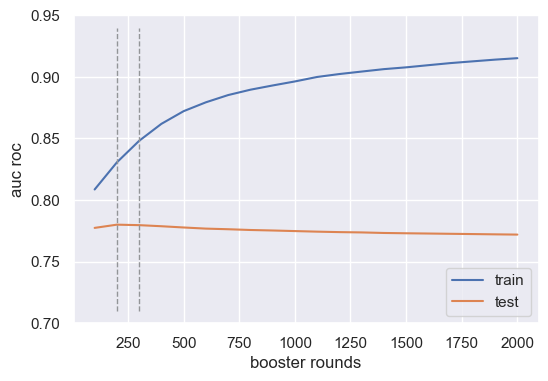

In [111]:
cv_results_bst = (
    pd.read_excel('cv_results_bst.xlsx')
        .sort_values(by='user_attrs_test-auc-mean', ascending=False)
        .loc[:, ['number', 'params_num_boost_round', 'user_attrs_train-auc-mean', 'user_attrs_test-auc-mean']]
)

fig, ax = plt.subplots(figsize=(6, 4))
sns.lineplot(x=cv_results_bst['params_num_boost_round'], y=cv_results_bst['user_attrs_train-auc-mean'], label='train')
sns.lineplot(x=cv_results_bst['params_num_boost_round'], y=cv_results_bst['user_attrs_test-auc-mean'], label='test')
ax.set(ylim=(0.7, 0.95), xlabel='booster rounds', ylabel='auc roc')
ax.axvline(x=200, ymin=0.04, ymax=0.96, linewidth=1, linestyle='--', color='#939598')
ax.axvline(x=300, ymin=0.04, ymax=0.96, linewidth=1, linestyle='--', color='#939598');

### <a id="model_predict"></a> Прогноз для тестовой выборки

Для финальной модели к *pipeline* с шагами по предобработке данных добавляется итоговый шаг с моделью, которая содержит найденные на предыдущем этапе гиперпараметрами. Обучение модели происходит в рамках полной цепочки действий, позволяющей - в случае необходимости - изменить параметры любого из шагов. На основе обученной модели формируется прогноз для тестовой выборки, который сохранятеся в отдельный файл для последующей отправки на платформу *Kaggle*.

In [135]:
xgb_mdl = XGBClassifier(
                booster='gbtree',
                tree_method='hist',
                verbosity=1,
                objective='binary:logistic',
                n_estimators=300,
                max_depth=6,
                learning_rate=0.15,
                min_child_weight=88.0,
                subsample=0.95,
                colsample_bytree=0.65,
                scale_pos_weight=1,
                reg_alpha=9.20,
                reg_lambda=1.5,
                gamma=0.65,
                importance_type='gain',
                n_jobs=None,
                seed=4567
)

pipelist_mdl = [('xgb_mdl', xgb_mdl)]
pipe_mdl = Pipeline(pipelist_feat_preproc + pipelist_mdl)
pipe_mdl.fit(X=X_train, y=y_train)

Pipeline(steps=[('impute_annuity',
                 MeanMedianImputer(variables=['AMT_ANNUITY'])),
                ('drop_goods_price',
                 DropFeatures(features_to_drop=['AMT_GOODS_PRICE'])),
                ('rare_hours',
                 RareLabelEncoder(ignore_format=True, missing_values='ignore',
                                  tol=0.025,
                                  variables=['HOUR_APPR_PROCESS_START'])),
                ('encode_dt_attrs',
                 MeanEncoder(ignore_format=True, missing_values='ignore',...
                                    variables=['CODE_GENDER'])),
                ('encode_gender',
                 OrdinalEncoder(encoding_method='arbitrary', ignore_format=True,
                                missing_values='ignore', unseen='encode',
                                variables=['CODE_GENDER'])),
                ('impute_fam_members',
                 MeanMedianImputer(variables=['CNT_FAM_MEMBERS'])),
                ('cap_fam_members',
                 ArbitraryOutlierCapper(max_capping_dict={'CNT_CHILDREN': 3,
                                                          'CNT_FAM_MEMBERS': 5},
                                        missing_values='ignore')), ...])

In [136]:
y_test['TARGET'] = pipe_mdl.predict_proba(X_test)[:, 1]
y_test.round(6).to_csv('submission.csv', index=False)

pd.concat([
    y_test['TARGET'].round(1).value_counts(),
    y_test['TARGET'].round(1).value_counts(normalize=True)*100], 
    axis=1
)

count  proportion
TARGET                   
0.0000  26636     54.6447
0.1000  15438     31.6716
0.2000   4152      8.5180
0.3000   1573      3.2271
0.4000    629      1.2904
0.5000    234      0.4801
0.6000     64      0.1313
0.7000     15      0.0308
0.8000      3      0.0062

### <a id="model_save"></a> Сохранение модели

В целях получения прогнозов из модели в будущем, весь *pipeline* сохраняется в виде *joblib* файла (аналог встроенного в стандартную библиотеку *python* модуля *pickle*). Проверка показывает, что результаты прогнозов из обученной и сохраненной модели совпадают. Таким образом, полученные с помощью *SQL* запросов данные могут, при обновлении в источнике данных, быть загружены заново и использованы для получения прогноза с использованием сохраненной модели.

In [137]:
joblib.dump(pipe_mdl, 'hc_model.joblib')

['hc_model.joblib']

In [138]:
hc_model = joblib.load('hc_model.joblib')

In [139]:
# Compare prediction values from pipeline and joblib dump
np.c_[
    y_test['TARGET'].to_numpy()[0:5].reshape(-1, 1),
    hc_model.predict_proba(X_test.iloc[0:5, :])[:, 1].reshape(-1, 1)
]

array([[0.0723, 0.0723],
       [0.0406, 0.0406],
       [0.1505, 0.1505],
       [0.0133, 0.0133],
       [0.046 , 0.046 ]], dtype=float32)

### <a id="model_results"></a> Оценка прогноза для соревнования *Kaggle* 

Результат, использую метрику *AUC ROC*, по итогам отправки прогноза для тестовой выборки на платформу *Kaggle* составляет 0.77862 для публичного рейтинга и 0.77323 для приватного рейтинга (разница -0.00539). Урезанная версия кода, используемого на платформе, длосупна [по ссылке](./kaggle_code.py). 

![ER diagram](./leaderboard.png)

## <a id="conclusions"></a> Результаты и выводы

На топ 25 признаков приходится 51,2% объяснительной мощности модели, в том числе 14,6%, источником которых являются сгенерированные признаки. Наиболее значимыми из них являются средний процент использования кредитного лимита по имеющимся кредитным картам (*CC_LOADING_AVG*), процент отказа по прошлым кредитным заявкам (*PA_LOANS_REF_PCT*) и среднее количество просроченных платежей по кредитным картам (*IP_CC_DPD*).

В целом новые сгенерированные признаки позволили улучшить выбранную метрику качества классификации на два процентных пункта с 0.7533 по результатам кросс-валидации на тренинговых данных до 0.7732 на тестовых данных. К сожалению, ни один из новых признаков не смог превзойти по важности составные индикаторы кредитного риска (переменные *EXT_SOURCE_n*), присутствующие в исходных данных, что указывает на потенциал поиска дополнительных информативных признаков.

Top 25 important features account for 51.2%, including 10 engineered features explaining 14.6%.


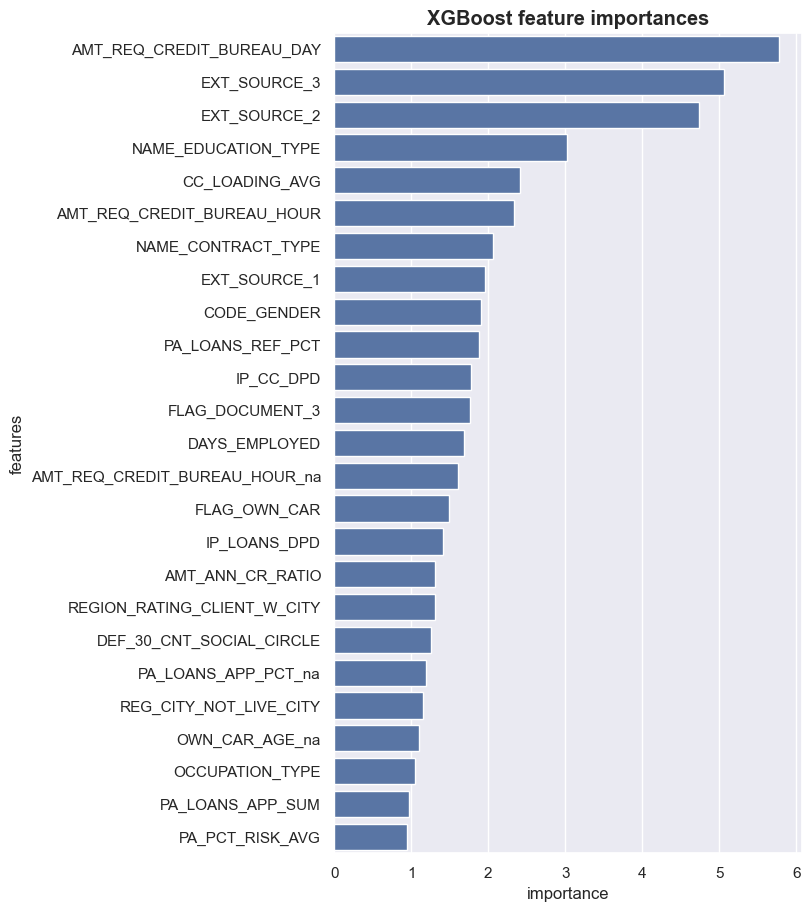

In [149]:
feat_imp = pd.DataFrame({
            'features': pipe_mdl._final_estimator.feature_names_in_,
            'importance': pipe_mdl._final_estimator.feature_importances_*100
        }).sort_values(by='importance', ascending=False).reset_index(drop=True).iloc[0:25, :]

print(f"Top 25 important features account for {feat_imp['importance'].sum():.1f}%, including 10 engineered features explaining {feat_imp.loc[[4,9,10,13,15,16,19,21,23,24], 'importance'].sum():.1f}%.")

fig, ax = plt.subplots(figsize=(8, 9), layout='constrained')
sns.barplot(x=feat_imp['importance'], y=feat_imp['features'], ax=ax)
ax.set_title('XGBoost feature importances', fontsize='large', fontweight='bold');